# 呱吉只是個會脫褲子的小丑還是有政治理念的議員？

## 檢視呱吉投入政治到底做到了些什麼

### <a href='#1.體制有問題，就該從頭改變，不是選上了才想要怎麼改變'>1.  體制有問題，就該從頭改變，不是選上才想要怎麼改變</a>
「花一千萬元就跟其他候選人沒兩樣，我不做海報、旗幟，不想打不環保的選戰。」
### <a href='#2.有人說票都是來自粉絲，是真的嗎?'>2.  有人說票都是來自粉絲，是真的嗎?</a>
將粉絲轉換為實際投票，真的很多嗎？
### <a href='#3.競選政見有做到嗎？網路輿情分析，看看呱吉被大家討論的事件都是什麼'>3.  競選政見有做到嗎？網路輿情分析，看看呱吉被大家討論的事件都是什麼</a>
問政品質人人稱讚，那有人考慮過內容是否有用嗎？
### <a href='#4.結論'>4.   結論</a>

In [167]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx
from matplotlib import cm
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
from ast import literal_eval
import jieba
from collections import Counter
from tqdm import tqdm_notebook
import torch.nn.functional as F
from snownlp import SnowNLP
import torch
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from numpy import dot
from numpy.linalg import norm
from os import path
import os

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

### 1.體制有問題，就該從頭改變，不是選上了才想要怎麼改變

1. 預處理
2. 呱吉的收入
    1. 根據月份
    2. 根據收入科目
3. 捐超過總金額1%的人是誰
4. 呱吉的支出
    1. 根據支出金額
    2. 根據支出用途
    3. 根據支出科目
5. 比較其他同區當選人
    1. 從收入來看
        1. 從收入科目來看
        2. 來看看一票要花多少錢
    2. 從支出來看
        1. 支出項目
        2. 治獻金餘額
    3. 來看特定候選人怎麼超支
6. 與其他無黨籍當選人比較
    1. 從收入來看
        1. 從收入項目來看
    1. 從支出來看
        1. 從支出項目來看
        2. 政治獻金餘額
7. 比較楊靜宇議員的收入支出

#### 1. 預處理

In [661]:
df = pd.read_csv("data.csv")
df['年月']  = df['交易日期'].apply(lambda x: int(x.split(' ')[0]+x.split(' ')[2]))
df_year = df[['年月','收入金額']]
df.head()

項目名稱         選舉名稱 申報序號／年度             交易日期    收支科目     捐贈者／支出對象    身分證／統一編號  \
0  邱威傑  107年臺北市議員選舉      首次  107 年 09 月 03 日    匿名捐贈           匿名         NaN   
1  邱威傑  107年臺北市議員選舉      首次  107 年 09 月 06 日  交通旅運支出          邱威傑  A12*******   
2  邱威傑  107年臺北市議員選舉      首次  107 年 09 月 10 日    雜支支出  02-27615220    42429764   
3  邱威傑  107年臺北市議員選舉      首次  107 年 09 月 19 日    宣傳支出         翔茂商行    72646774   
4  邱威傑  107年臺北市議員選舉      首次  107 年 09 月 25 日  交通旅運支出          邱威傑  A12*******   

   收入金額  支出金額      支出用途 金錢類          地址 聯絡電話  資料更正日期     年月  
0   147     0       NaN  金錢         NaN  NaN     NaN  10709  
1     0   255  搭乘交通工具支出  金錢  臺北市信義區****  NaN     NaN  10709  
2     0   685      餐飲費用  金錢  臺北市南京東****  NaN     NaN  10709  
3     0  4266    競選團隊背心  金錢  新竹市香山區****  NaN     NaN  10709  
4     0   180  搭乘交通工具支出  金錢  臺北市信義區****  NaN     NaN  10709

#### 2. 呱吉的收入

##### A. 根據月份

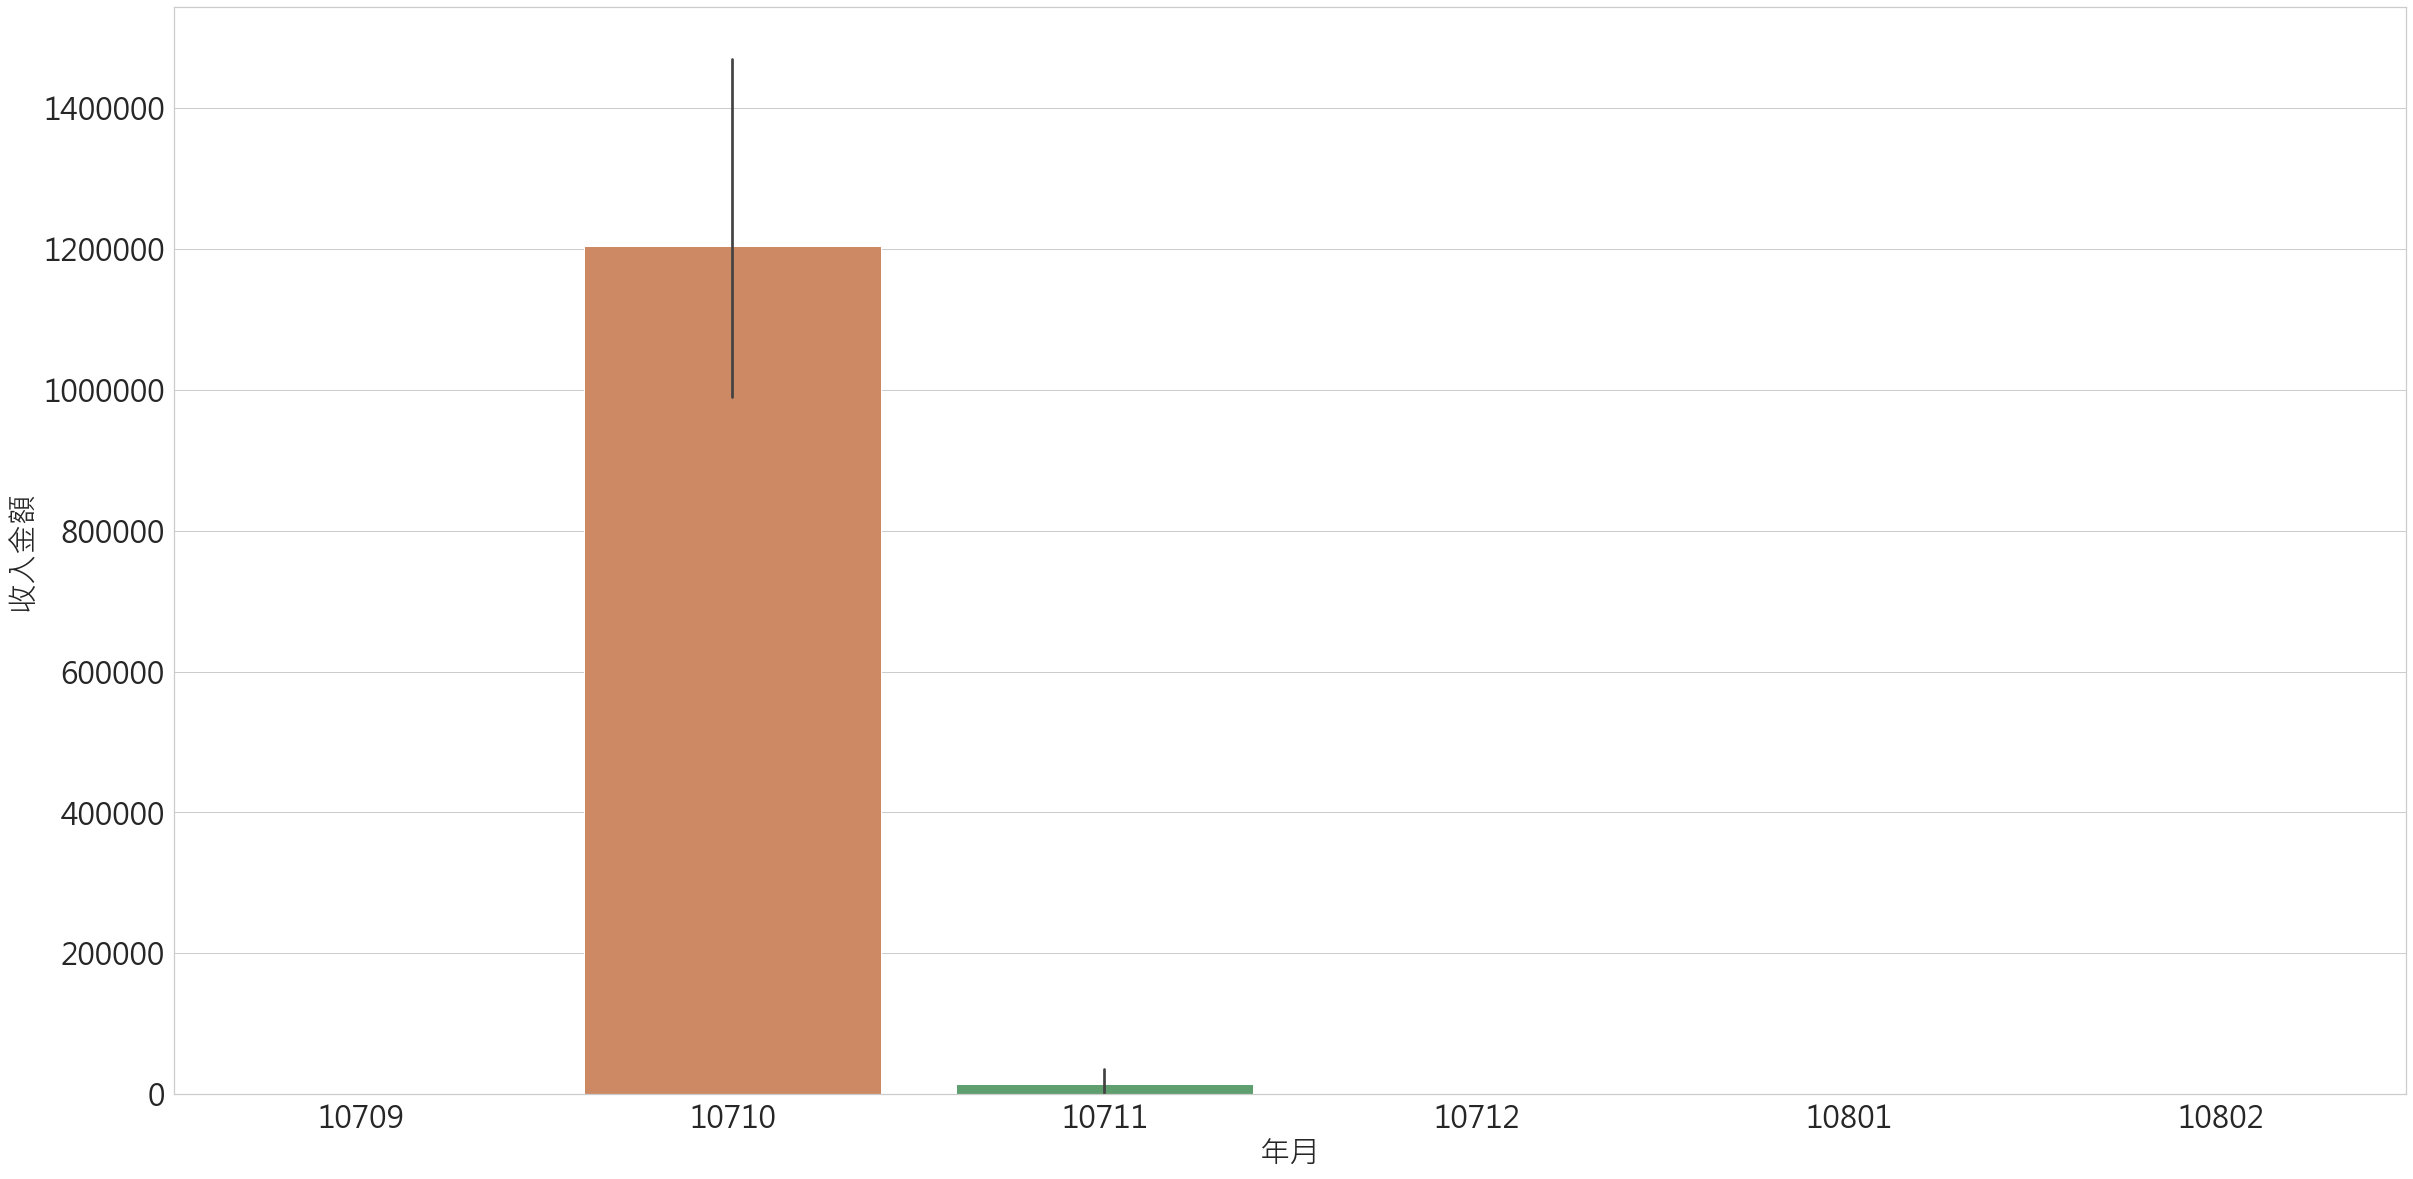

In [662]:
plt.figure(figsize=(40, 20))
plt.ylabel('收入金額',fontsize=30)
plt.xlabel('年月',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax = sns.barplot(x="年月", y="收入金額", data=df_year, estimator=sum)

##### B. 根據收入科目

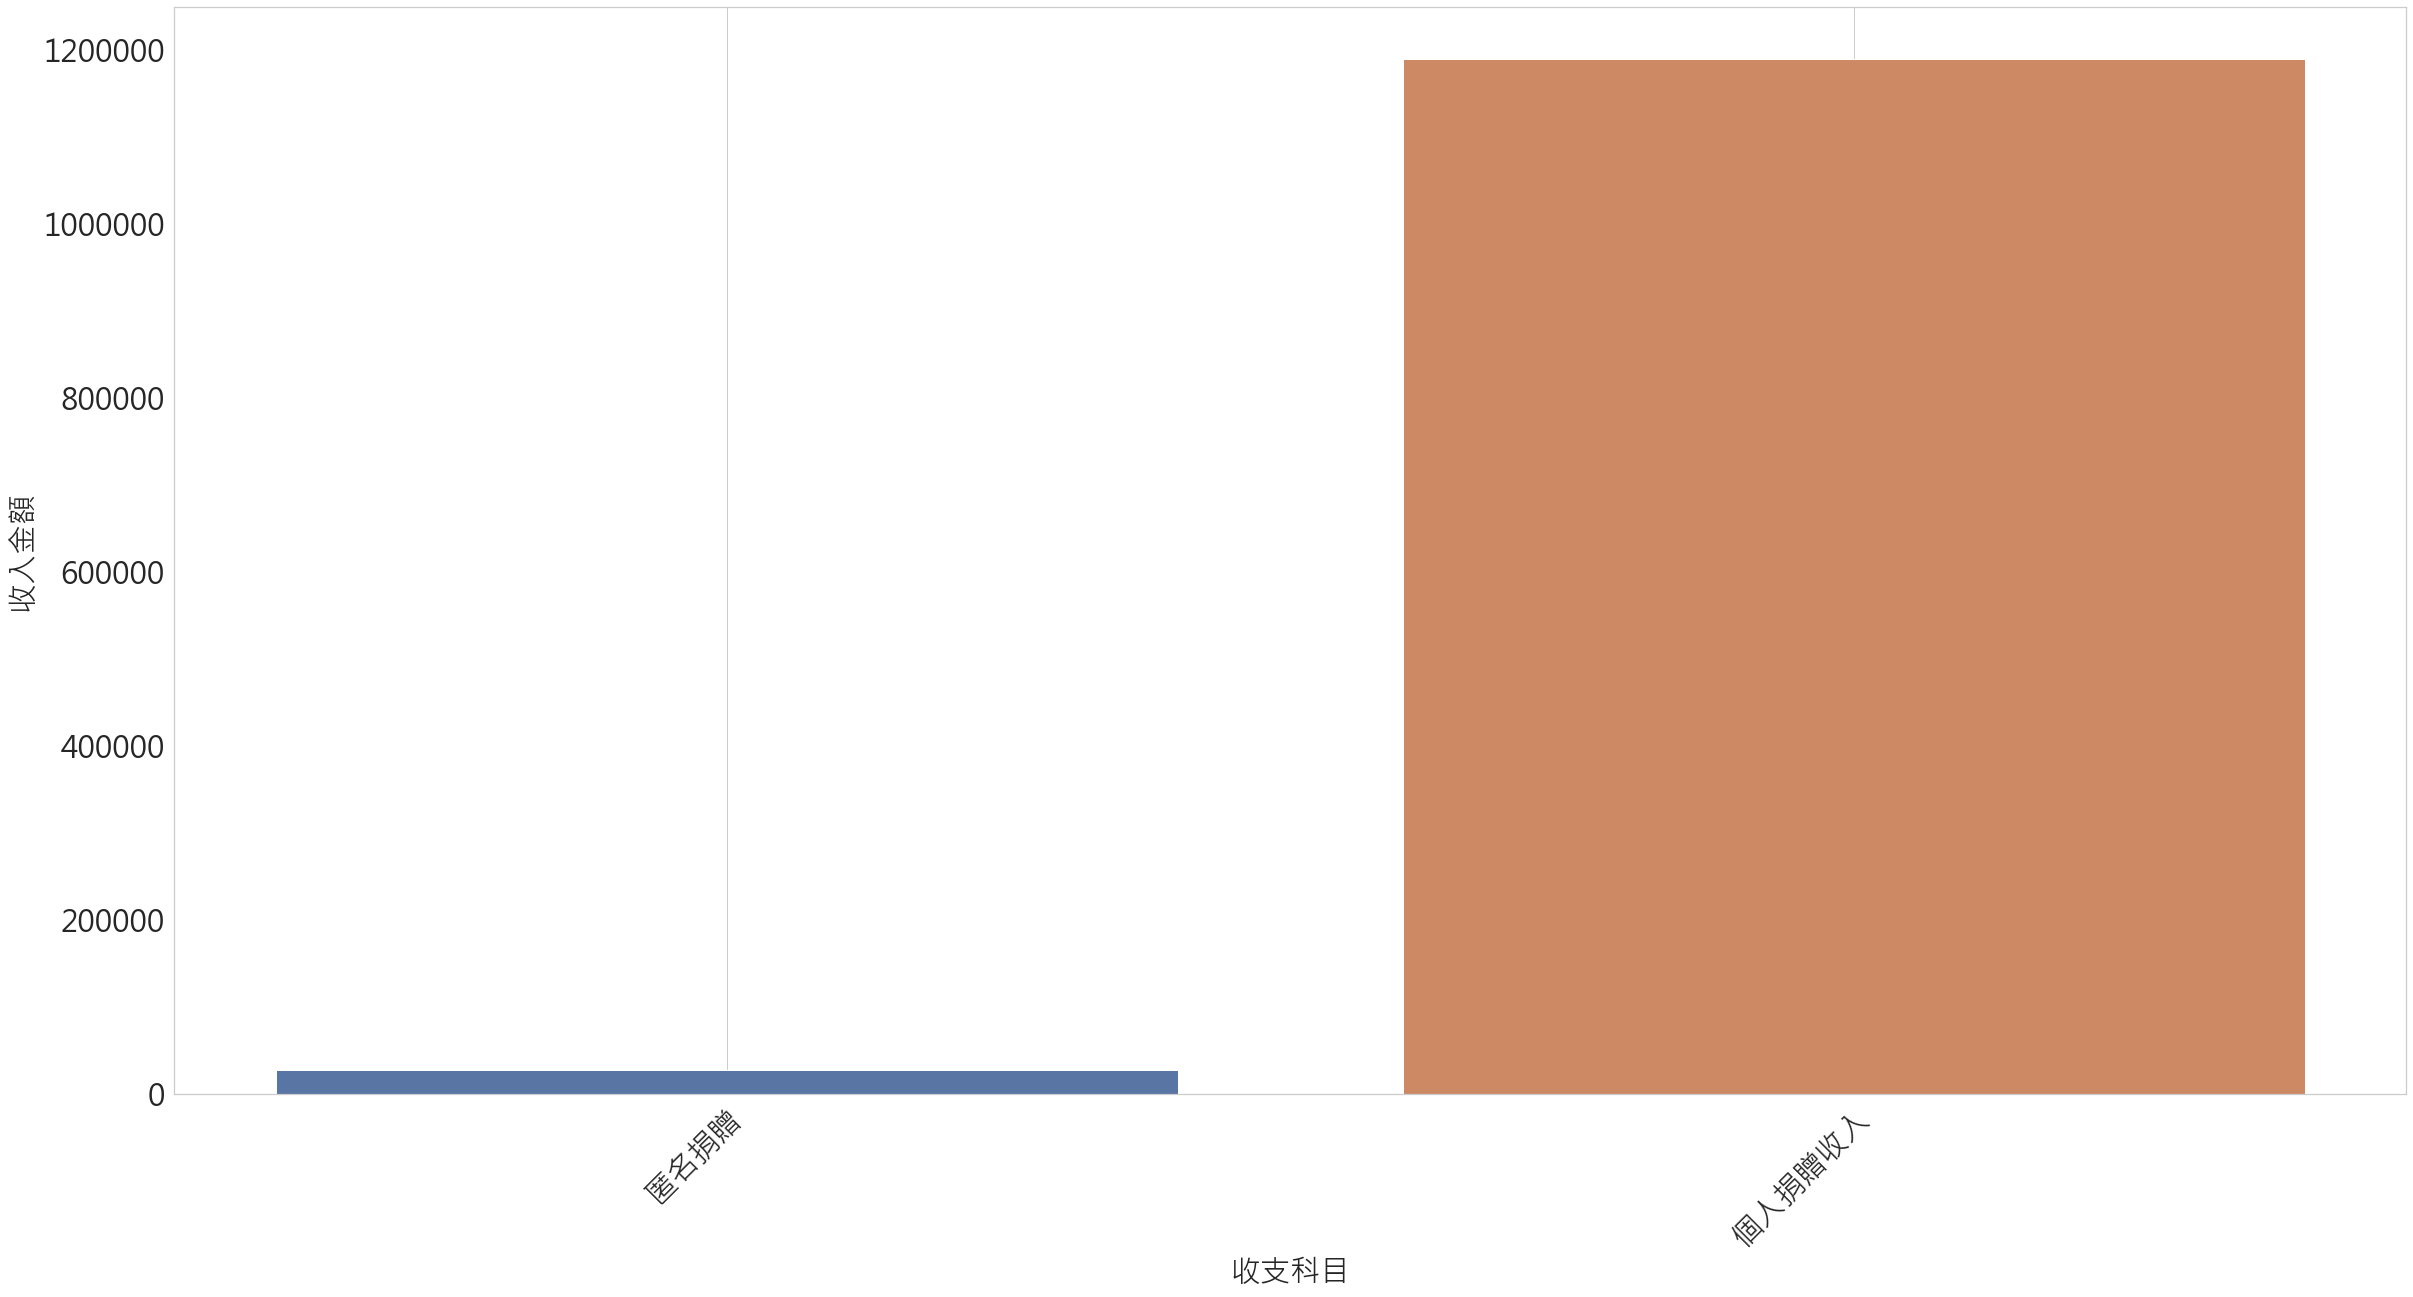

In [663]:
expense = df[df['收入金額']!=0].groupby(by='收支科目').sum()
expense = expense.reset_index()
expense = expense.sort_values(by='收入金額')
expense = expense[expense['收入金額']>=1000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="收支科目", y="收入金額", data=expense[['收支科目','收入金額']], estimator=sum)
label = ax.get_xticklabels()
plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('收入金額',fontsize=30)
plt.xlabel('收支科目',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

##### 3. 捐超過總金額1%的人是誰

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  # Remove the CWD from sys.path while we load stuff.


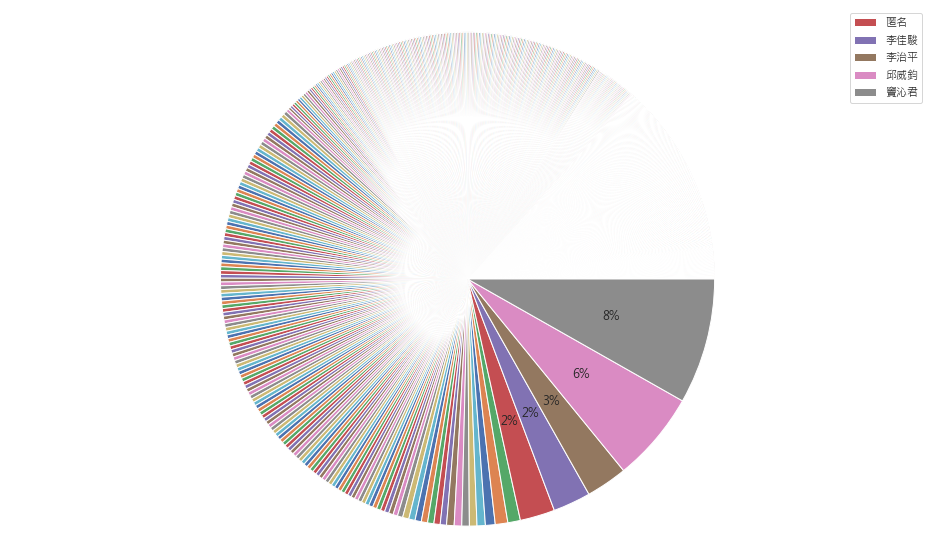

In [664]:
income = df[df['收入金額']!=0].groupby(by='捐贈者／支出對象').sum().sort_values(by='收入金額')
sizes = income[['收入金額']]

fig1, ax = plt.subplots()

def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 1 else ''


p,t,a = ax.pie(sizes.values, autopct=autopct_more_than_1)
ax.axis('equal') 

normsizes = sizes/sizes.sum()*100
h,l = zip(*[(h,lab) for h,lab,i in zip(p,sizes.index.values,normsizes.values) if i > 1])
ax.legend(h, l,loc="best", bbox_to_anchor=(1,1))

fig = plt.gcf()
fig.set_size_inches(16.5, 10)

plt.show()

#### 4. 呱吉的支出

#### A. 根據支出金額

貝殼放大為群眾募資公司，負責規劃整個募款工作，其餘支出為人名的推測為幕僚。

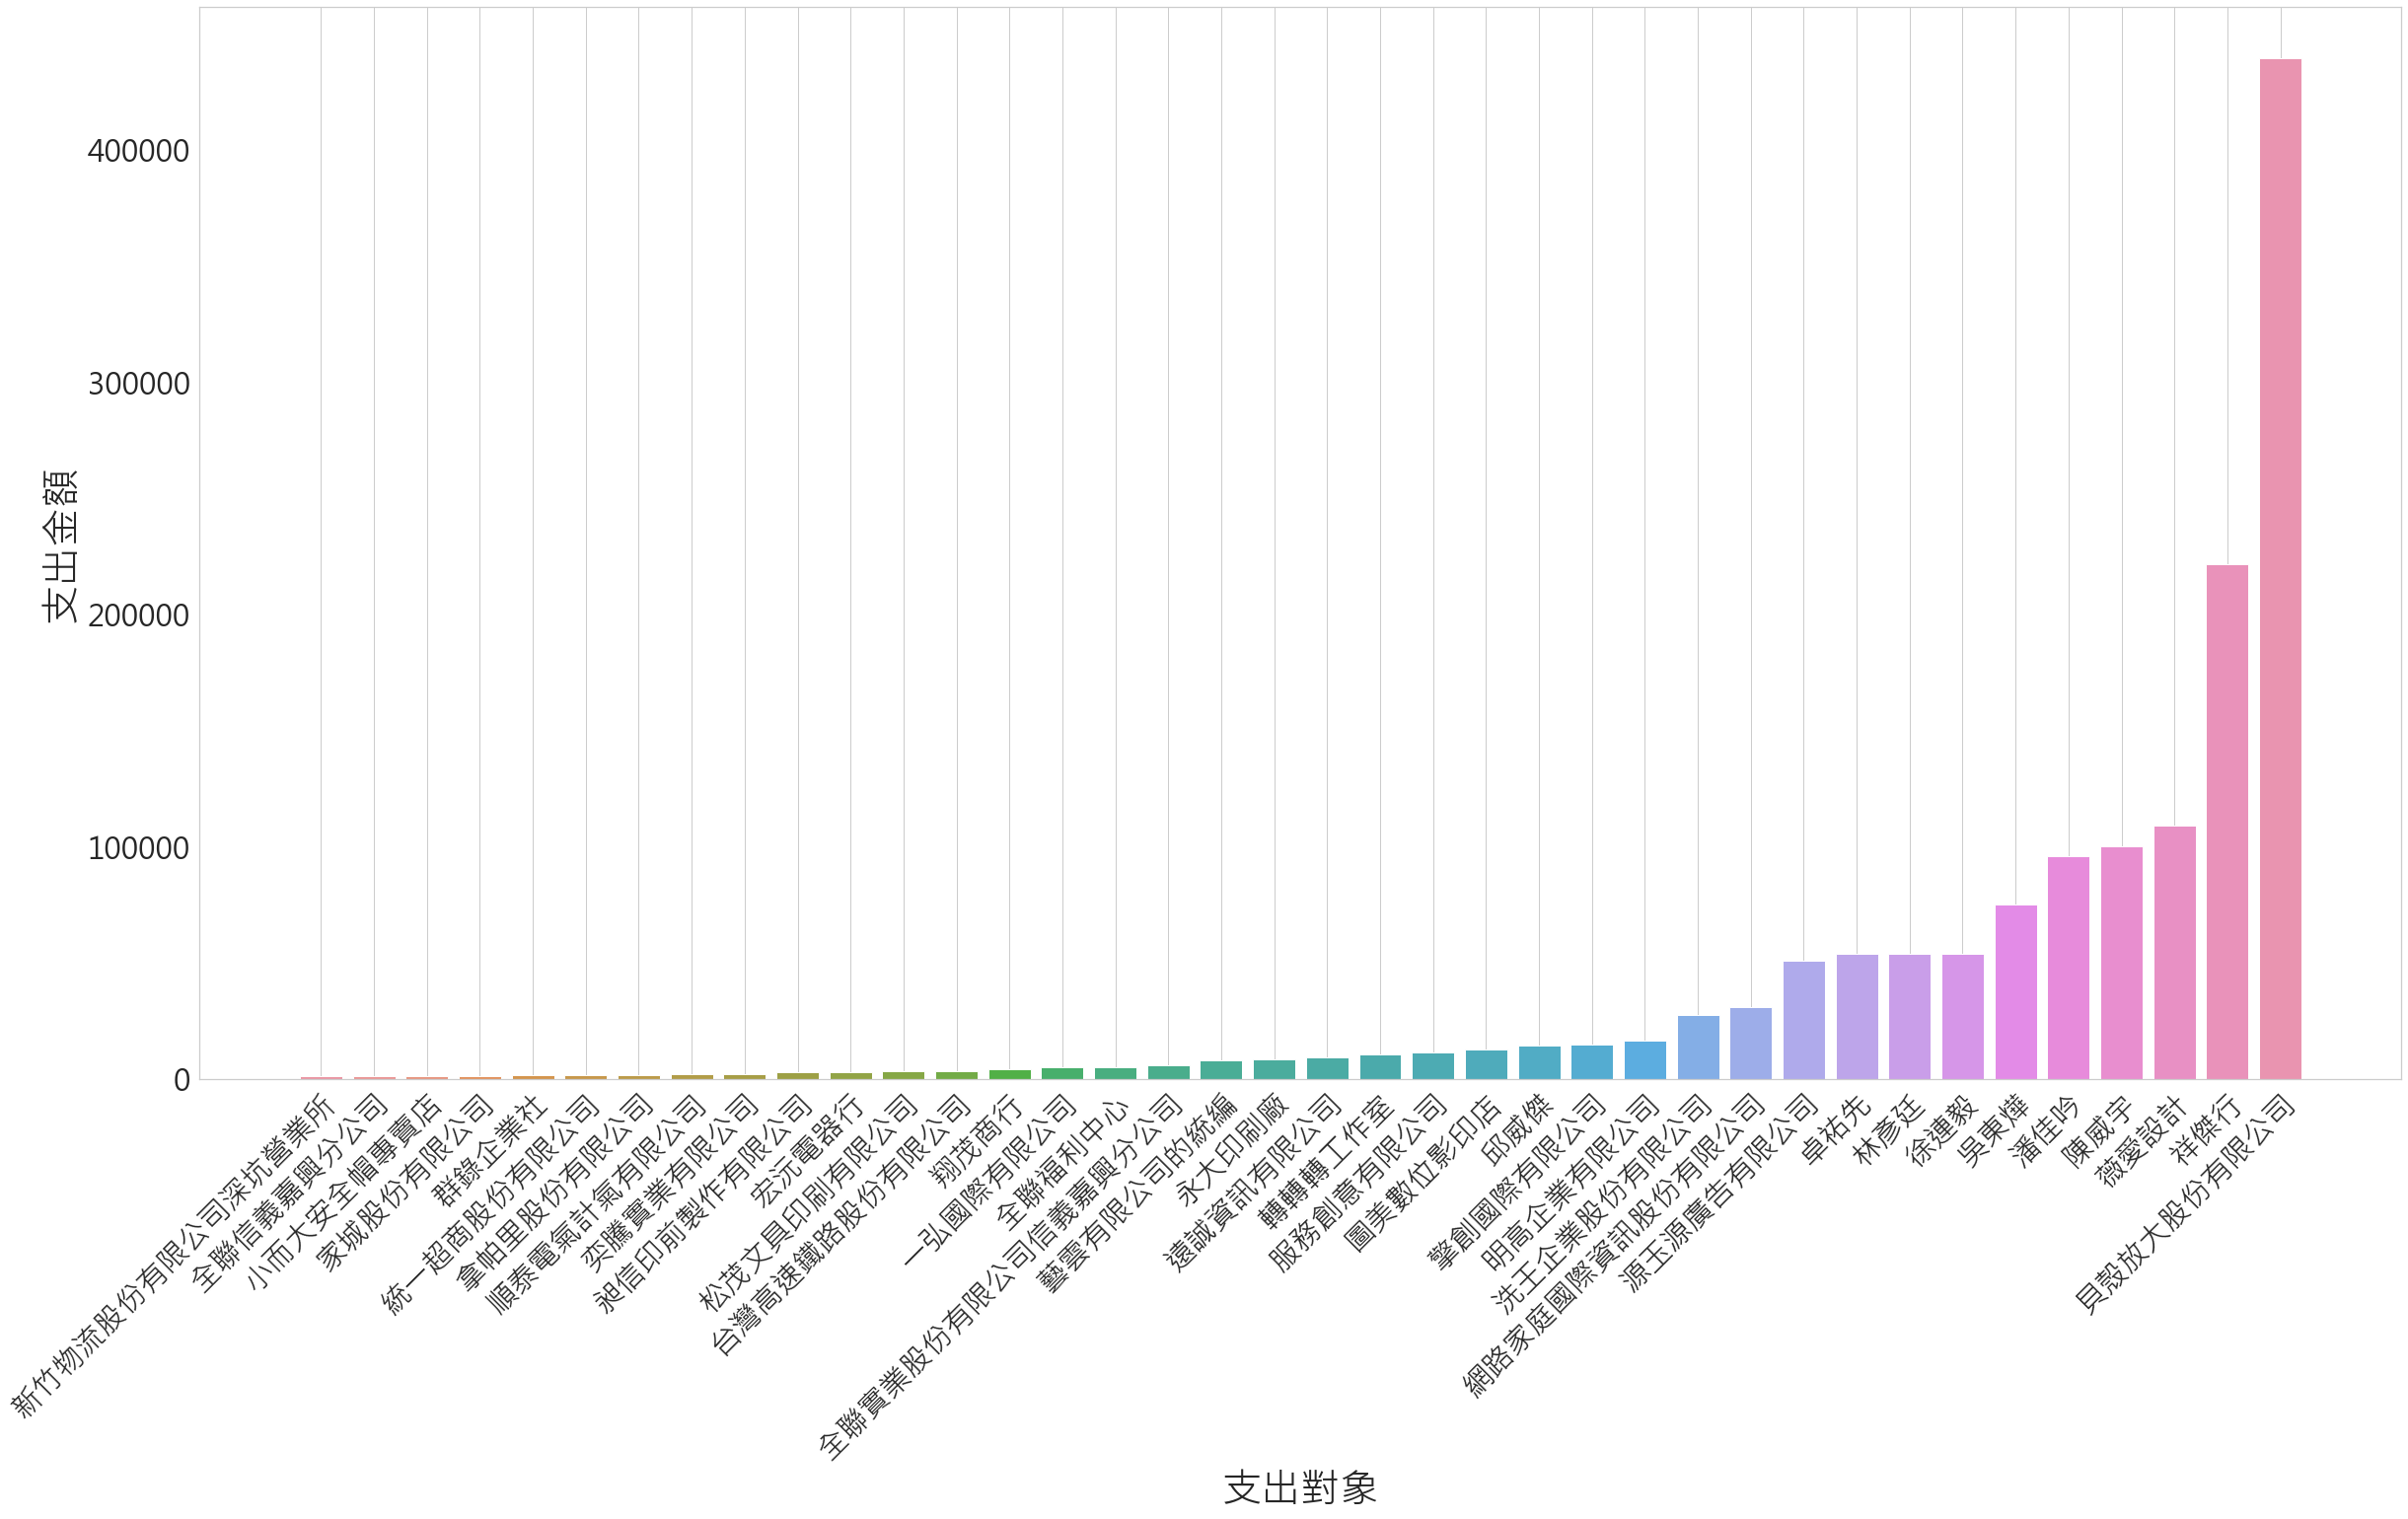

In [665]:
expense = df[df['支出金額']!=0].groupby(by='捐贈者／支出對象').sum()
expense = expense.reset_index()
expense = expense.sort_values(by='支出金額')
expense = expense[expense['支出金額']>=1000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="捐贈者／支出對象", y="支出金額", data=expense[['捐贈者／支出對象','支出金額']], estimator=sum)
label = ax.get_xticklabels()
plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('支出金額',fontsize=40)
plt.xlabel('支出對象',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

##### B. 根據支出用途

最高支出即為支出給貝殼放大

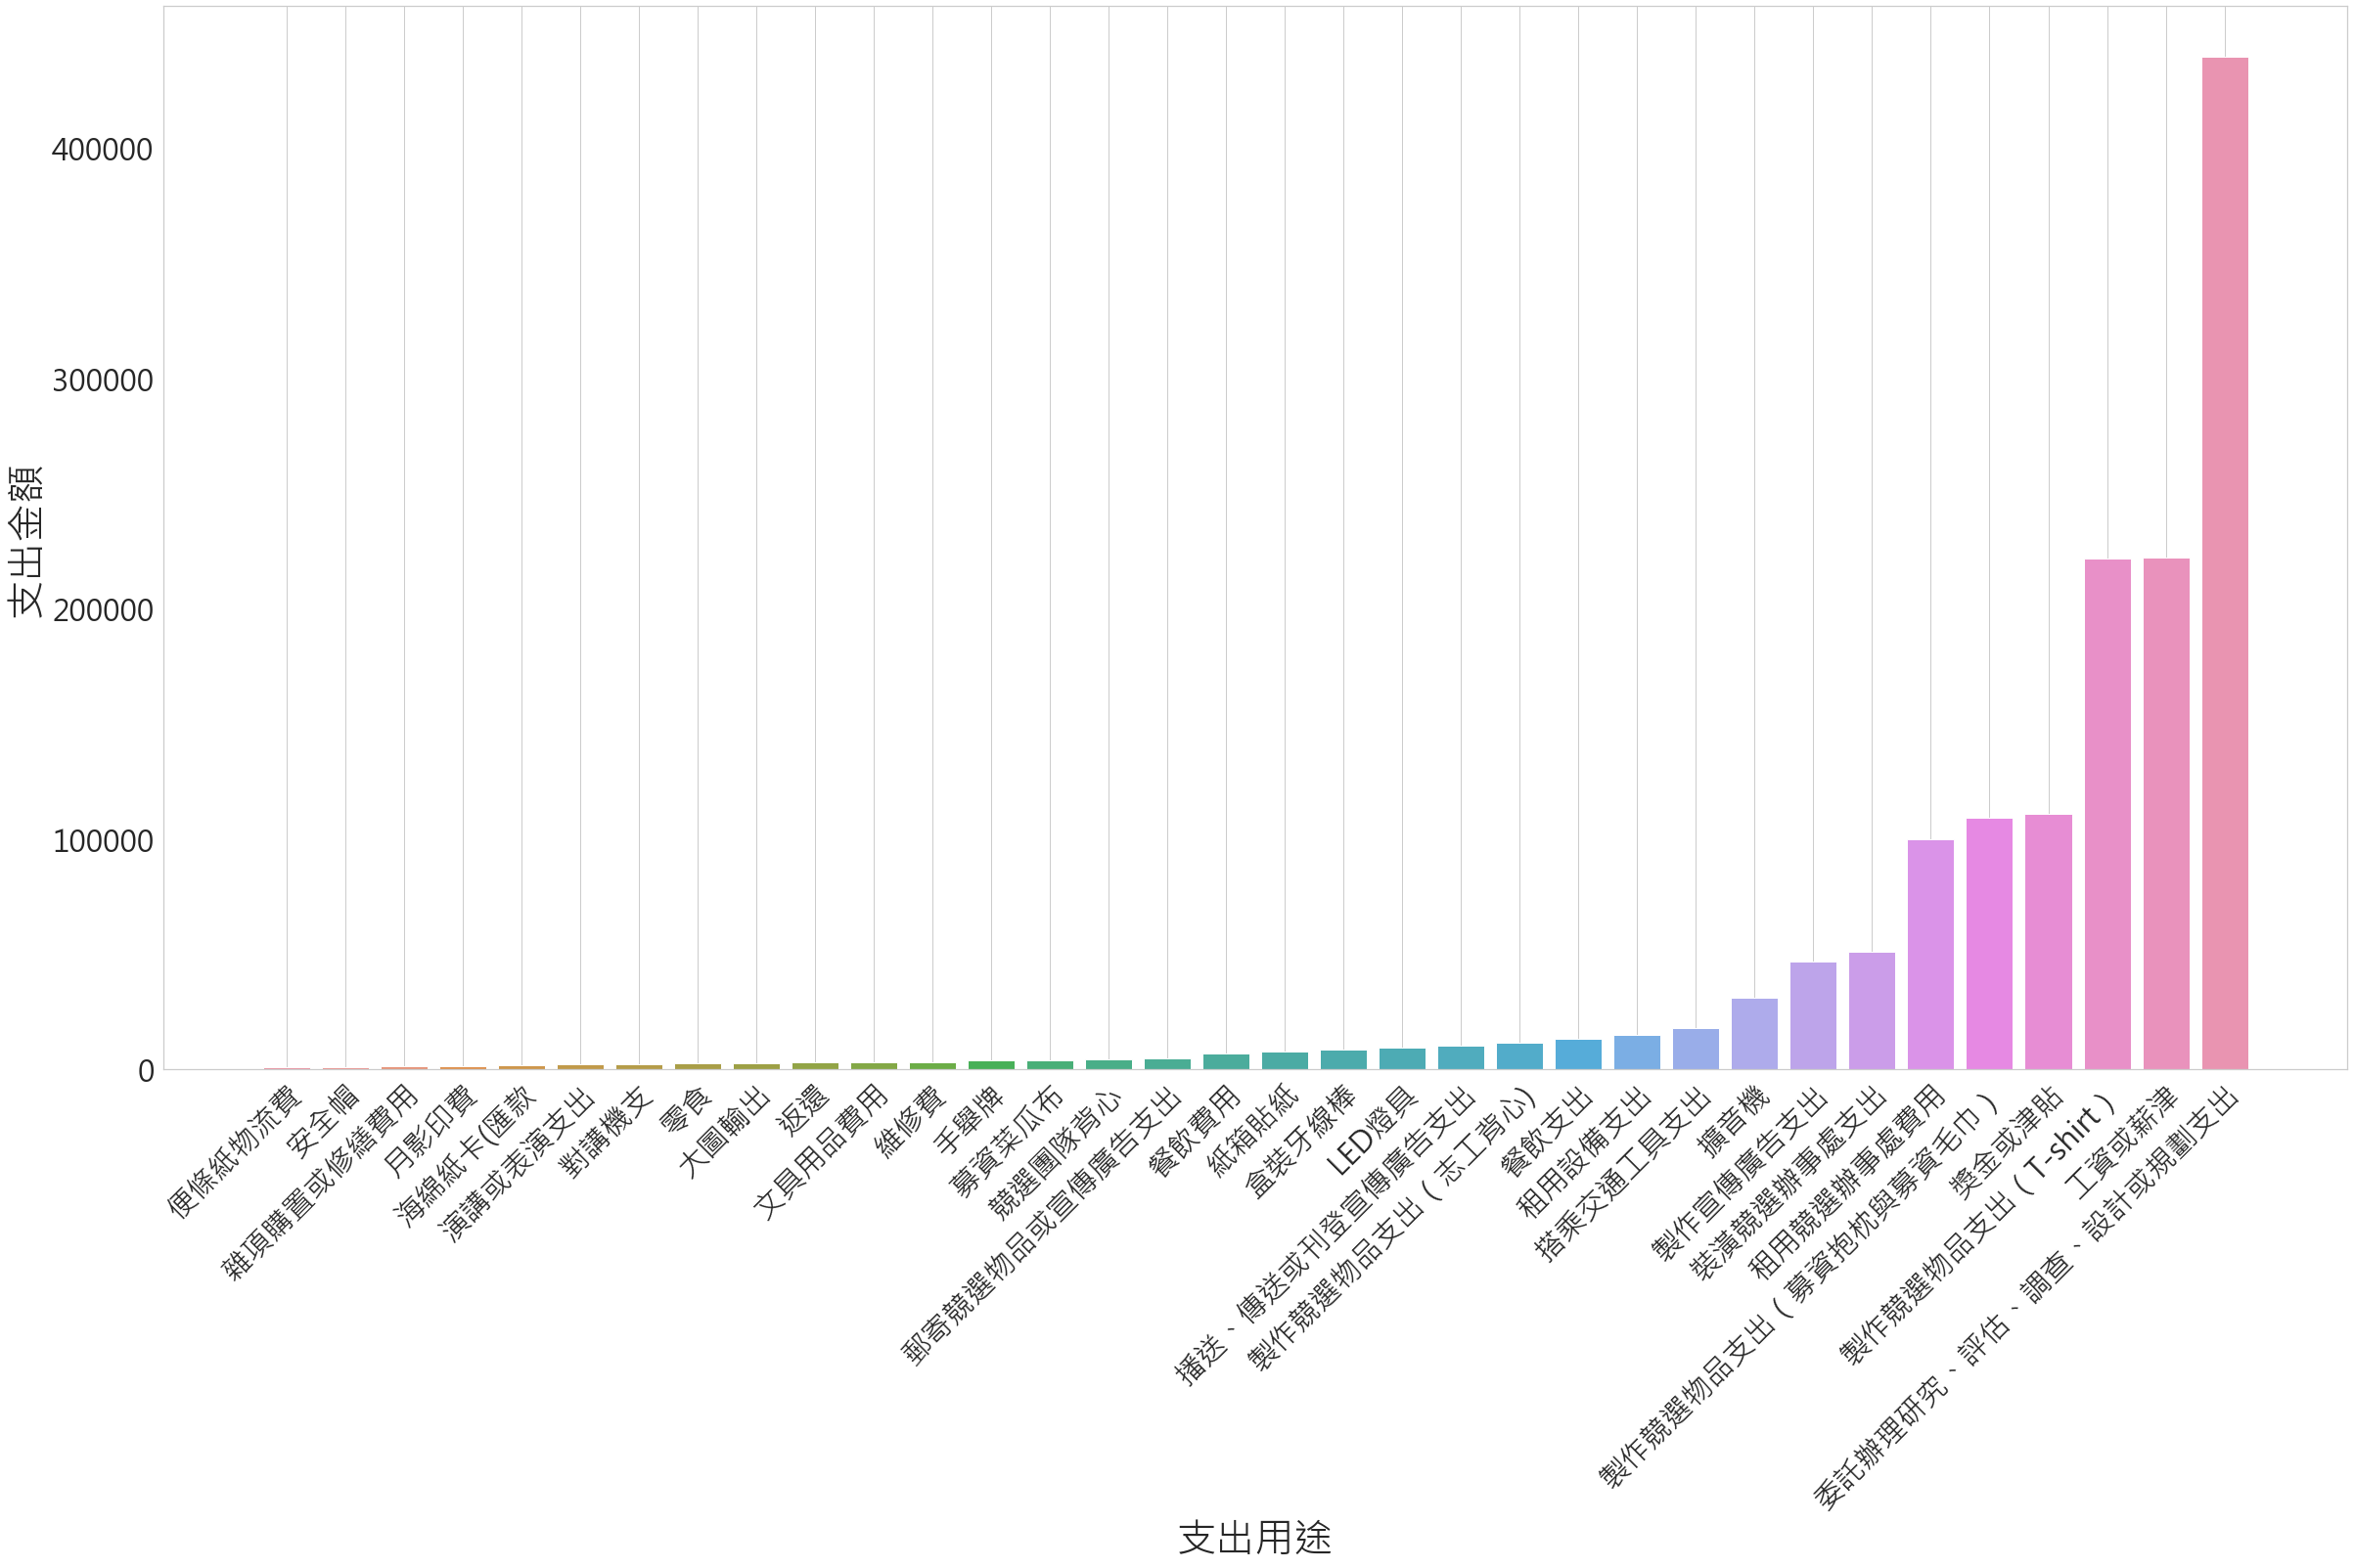

In [666]:
expense = df[df['支出金額']!=0].groupby(by='支出用途').sum().reset_index().sort_values(by='支出金額')
expense = expense[expense['支出金額']>=1000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="支出用途", y="支出金額", data=expense[['支出用途','支出金額']], estimator=sum)
label = ax.get_xticklabels()
plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('支出金額',fontsize=40)
plt.xlabel('支出用途',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

##### C. 根據支出科目

可以看到除了宣傳支出較高以外，其他都非常低

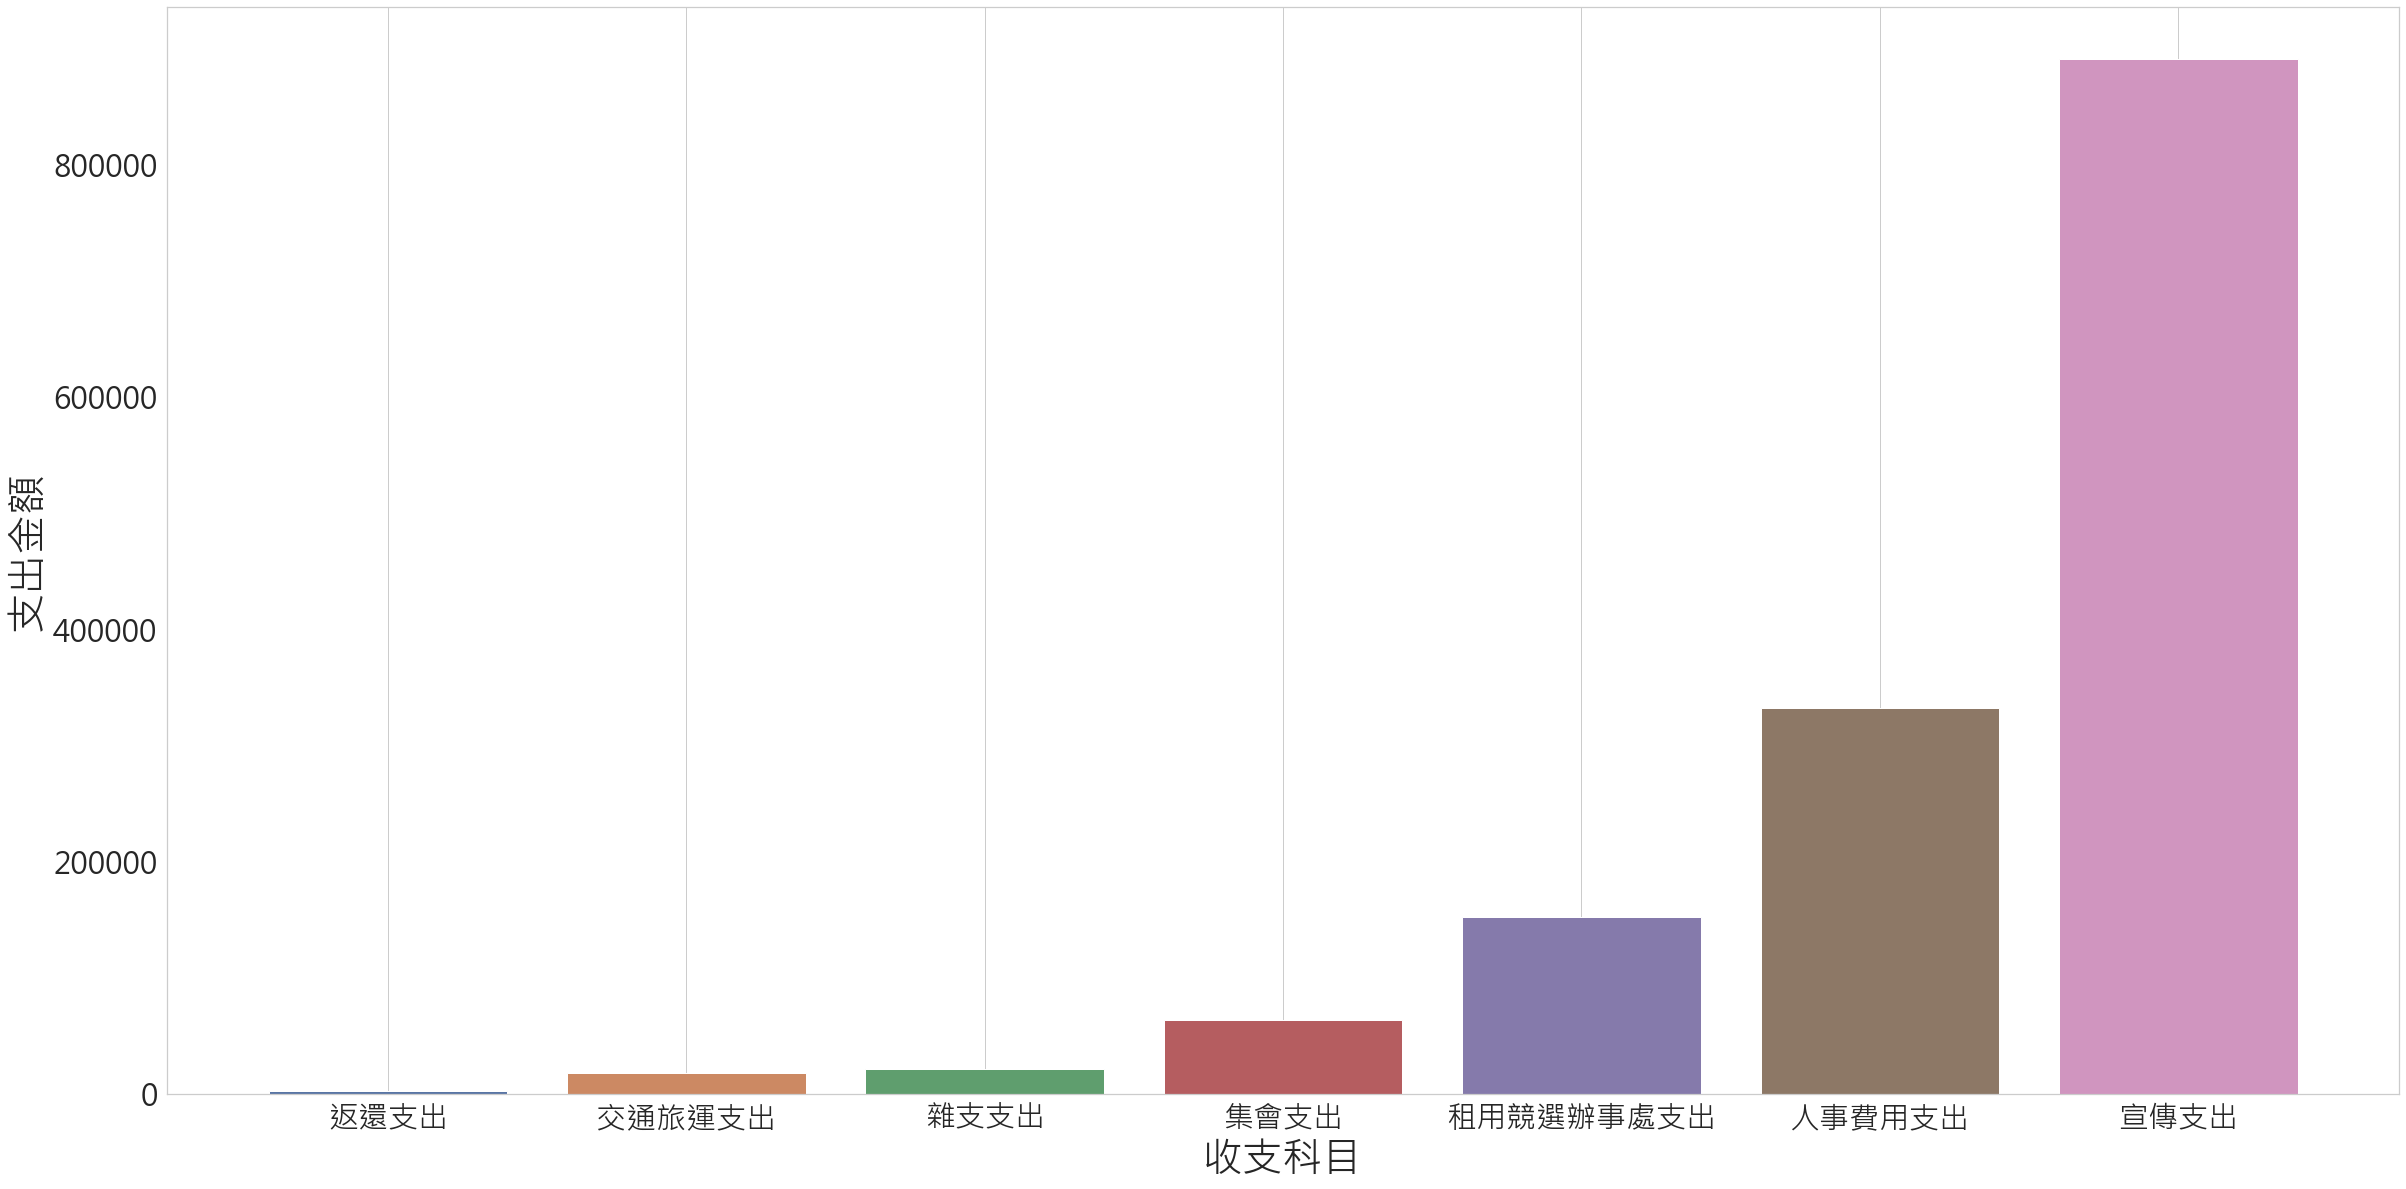

In [667]:
expense = df[df['支出金額']!=0].groupby(by='收支科目').sum().reset_index().sort_values(by='支出金額')
expense = expense[expense['支出金額']>=1000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="收支科目", y="支出金額", data=expense[['收支科目','支出金額']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('支出金額',fontsize=40)
plt.xlabel('收支科目',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### 5. 比較其他同區當選人

In [668]:
o_df = pd.read_csv("松山區當選人.csv",encoding='utf-8')
o_df.head()

項目名稱         選舉名稱 申報序號／年度             交易日期    收支科目      捐贈者／支出對象 身分證／統一編號  \
0  張茂楠  107年臺北市議員選舉      首次  107 年 04 月 30 日    雜支支出  台北農產運銷股份有限公司  4550147   
1  張茂楠  107年臺北市議員選舉      首次  107 年 04 月 30 日    雜支支出  台北農產運銷股份有限公司  4550147   
2  張茂楠  107年臺北市議員選舉      首次  107 年 05 月 01 日  交通旅運支出     台灣中油忠孝東路站  1113283   
3  張茂楠  107年臺北市議員選舉      首次  107 年 05 月 04 日    宣傳支出    中華郵政股份有限公司  3741302   
4  張茂楠  107年臺北市議員選舉      首次  107 年 05 月 07 日    宣傳支出    中華郵政股份有限公司  3741302   

   收入金額  支出金額       支出用途 金錢類          地址       聯絡電話  資料更正日期  
0     0  2025     洋蔥、大蒜頭  金錢  臺北市中山區****        NaN     NaN  
1     0  1800        大蒜頭  金錢  臺北市中山區****        NaN     NaN  
2     0  1579         油資  金錢  臺北市信義區****  0227*****     NaN  
3     0  6300  郵寄競選物品-郵資  金錢  臺北市大安區****  0223*****     NaN  
4     0  5700  郵寄競選物品-郵資  金錢  臺北市大安區****  0223*****     NaN

In [669]:
o_df['項目名稱'].unique()

array(['張茂楠', '許家蓓', '王鴻薇', '戴錫欽', '陳永德', '徐巧芯', '許淑華', '秦慧珠', '洪健益'],
      dtype=object)

In [670]:
jang = o_df[o_df['項目名稱'] == '張茂楠']
shiu = o_df[o_df['項目名稱'] ==  '許家蓓']
wang = o_df[o_df['項目名稱'] == '王鴻薇']
dai = o_df[o_df['項目名稱'] == '戴錫欽']
chen = o_df[o_df['項目名稱'] == '陳永德']
shiu2 = o_df[o_df['項目名稱'] == '徐巧芯']
shiu3 = o_df[o_df['項目名稱'] == '許淑華']
chin = o_df[o_df['項目名稱'] == '秦慧珠']
hung =o_df[o_df['項目名稱'] == '洪健益']
o_df = pd.concat([o_df,df],axis=0,sort=False)

#### A. 從收入來看

兩千萬，才能選議員嗎？

##### 可以看到許多候選人基本上都是無限上綱的在收政治獻金

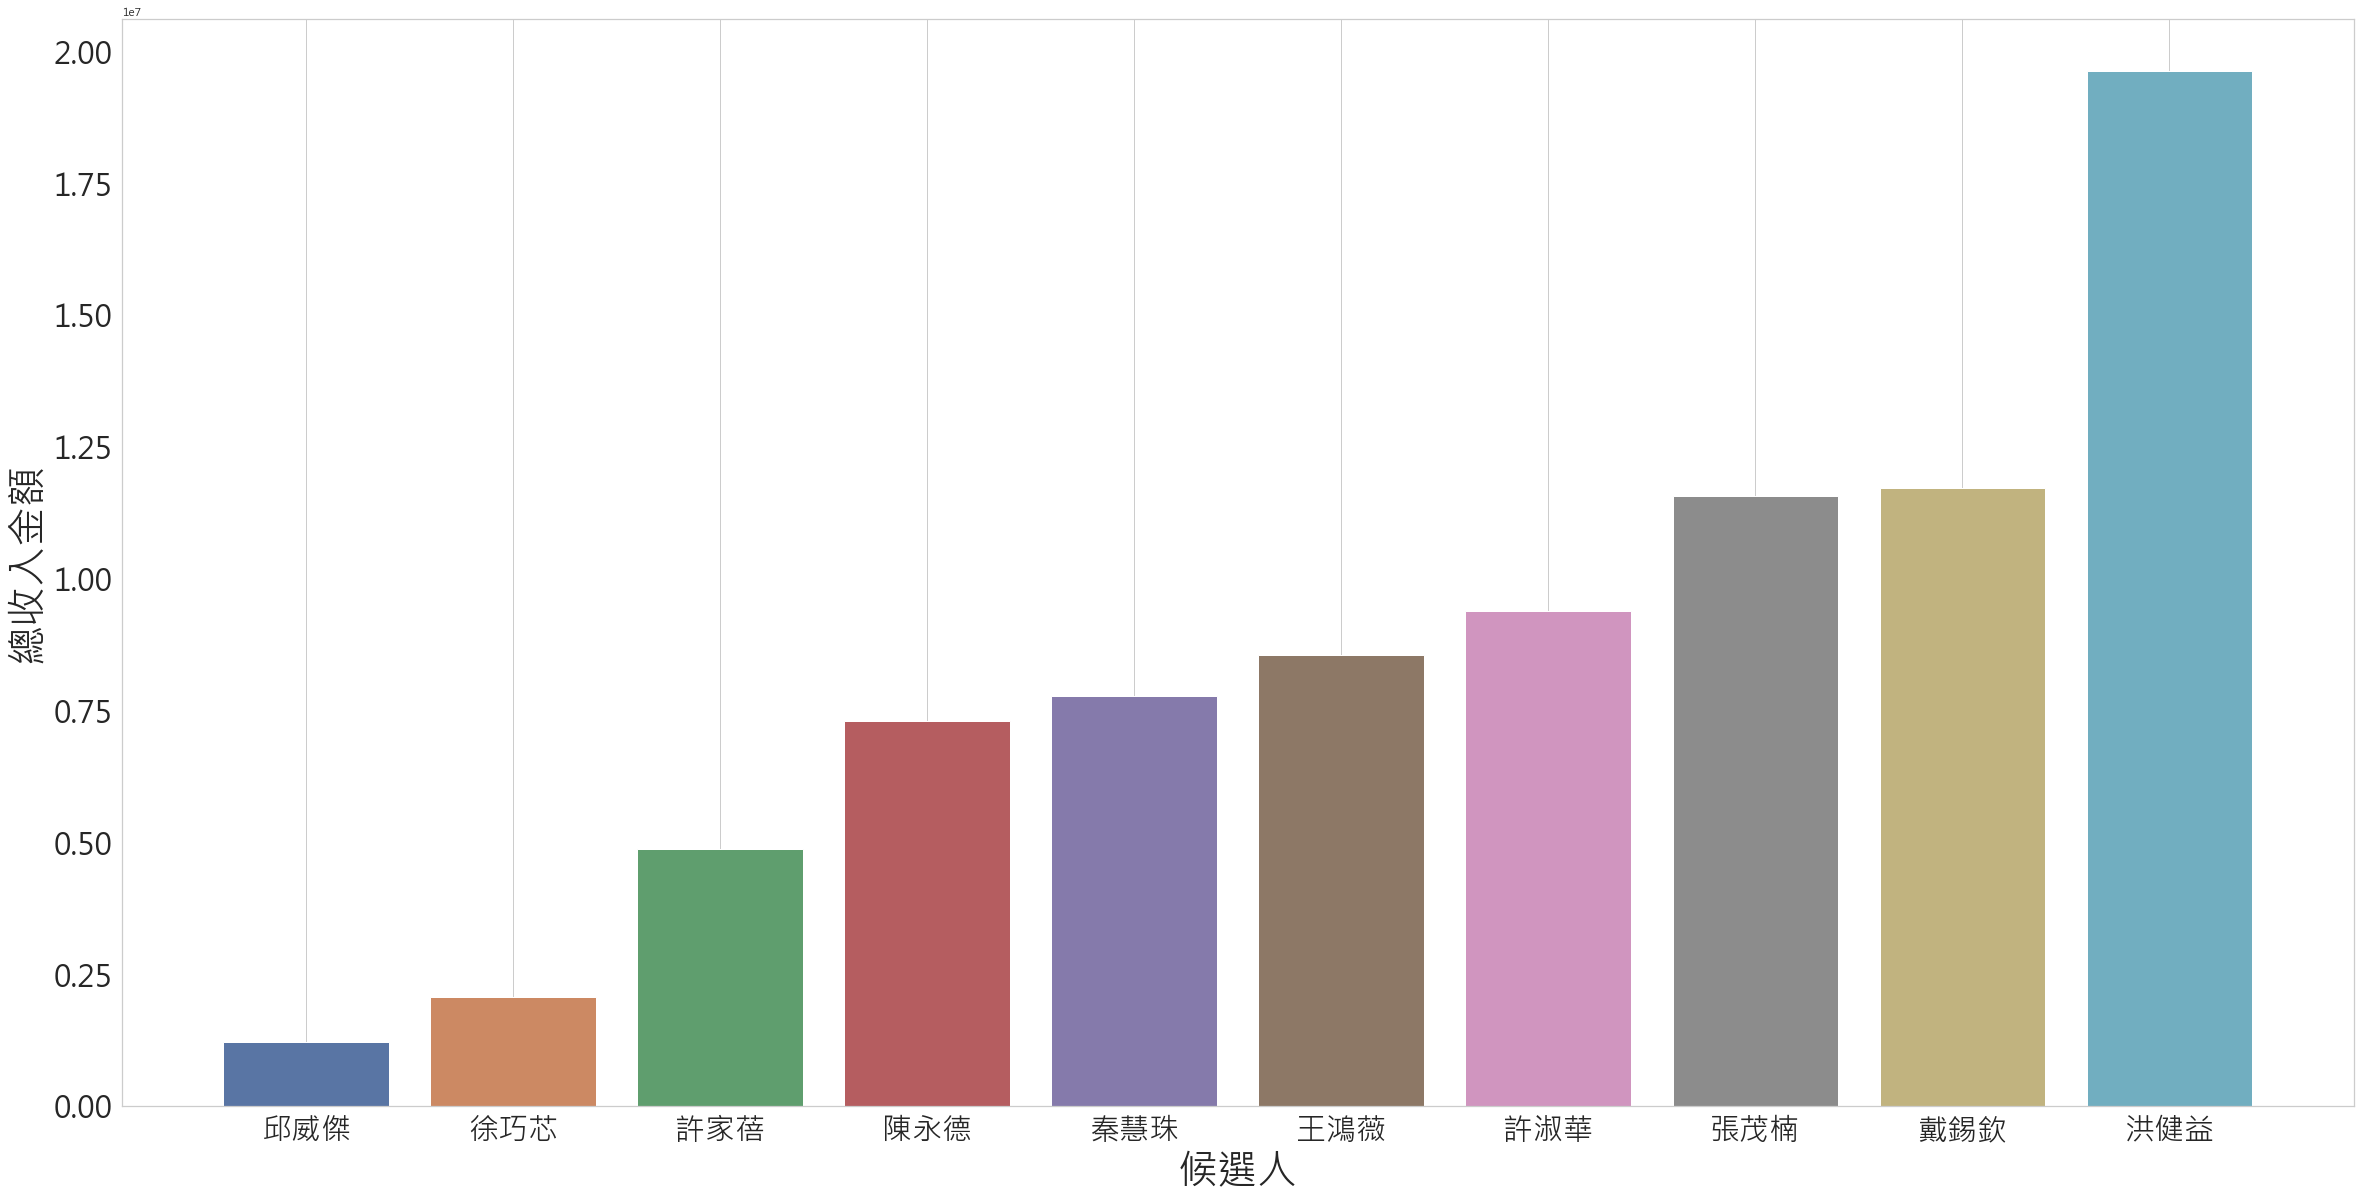

In [671]:
all_income = o_df[o_df['收入金額']!=0].groupby(by='項目名稱').sum().reset_index().sort_values(by='收入金額')
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="收入金額", data=all_income[['收入金額','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('總收入金額',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### a. 從收入科目來看

除了徐巧芯與呱吉有相似的政治理念，不太收營利事業捐贈外，其餘都有相對高的營利事業收入，如果收了這麼多企業的錢，選上後能不幫忙企業在各種法案的通過等等這類的忙嗎？

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2880x1440 with 0 Axes>

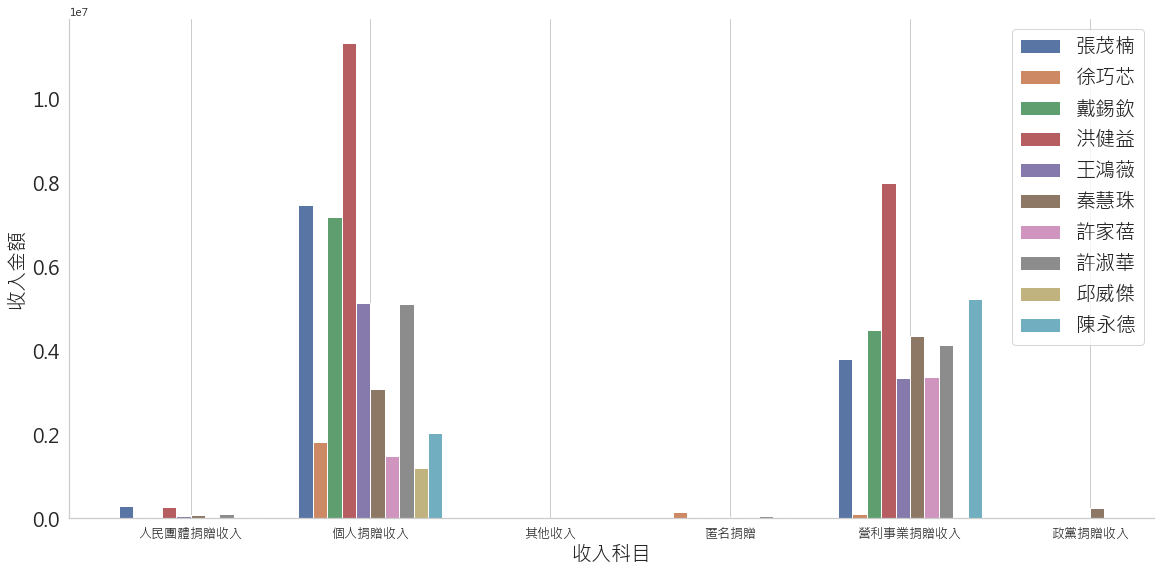

In [672]:
i_cate = o_df.groupby(['項目名稱', '收支科目']).sum().reset_index()
plt.figure(figsize=(40, 20))
sns.factorplot(x='收支科目', y='收入金額', hue='項目名稱', data=i_cate[i_cate['收入金額'] != 0], kind='bar',size=8, aspect=2,legend=False)
plt.ylabel('收入金額',fontsize=20)
plt.xlabel('收入科目',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc='upper right')
plt.grid()
_ = plt.plot()

#### b. 來看看一票要花多少錢

徐巧芯同樣為松山區優秀候選人，曾與呱吉一同舉辦肥皂箱演講

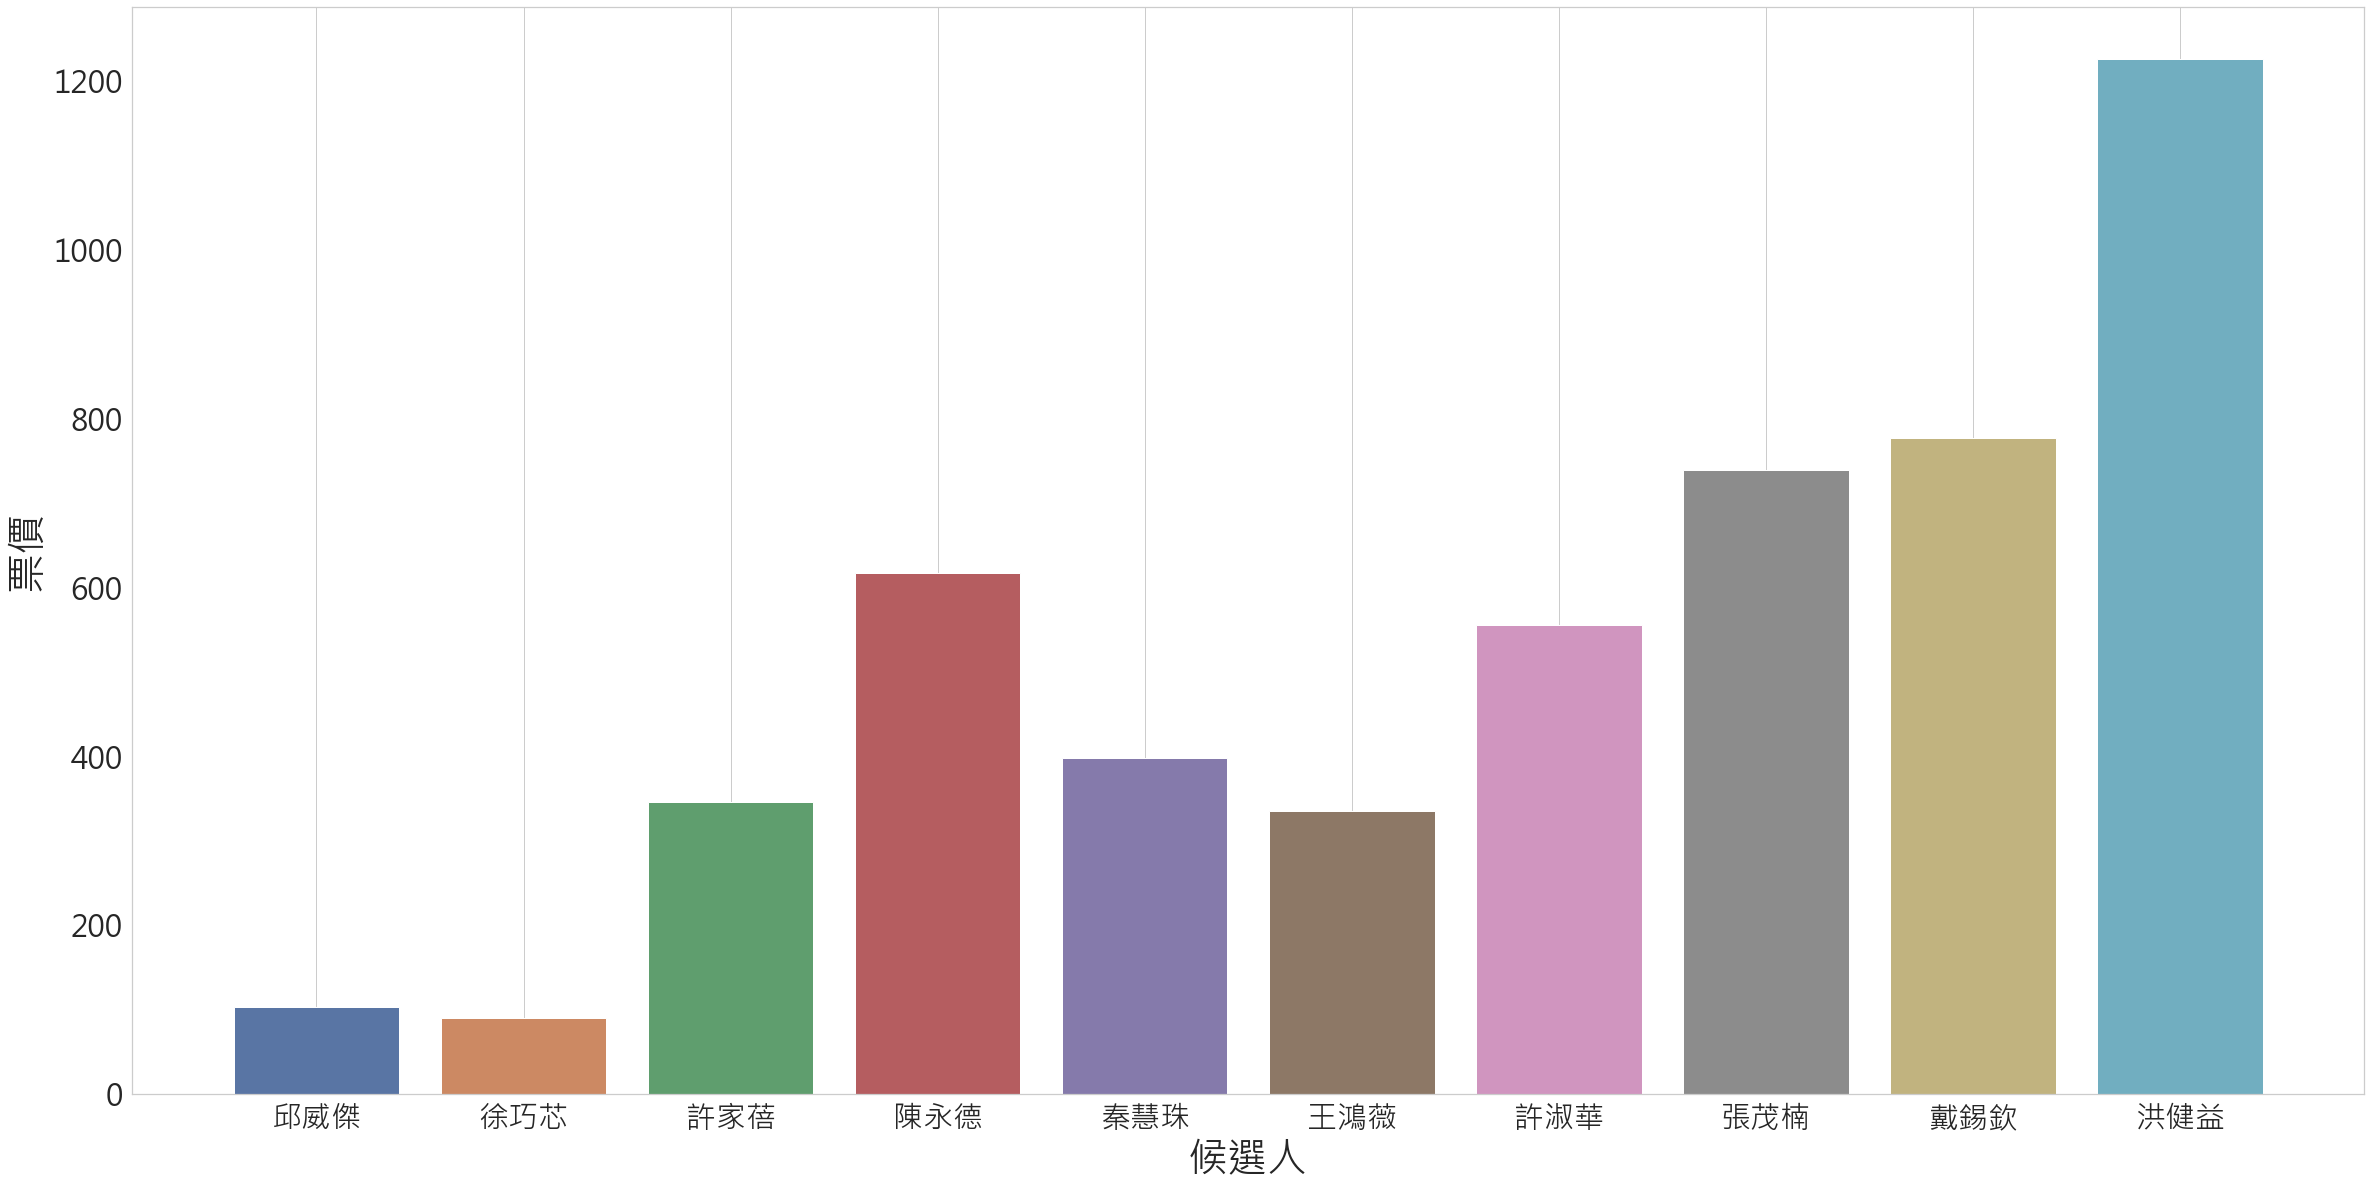

In [673]:
dict_ = {'陳永德':11848,
         '洪健益':16014,
         '許淑華':16900,
         '秦慧珠':19568,
         '徐巧芯':22929,
         '邱威傑':11786,
         '戴錫欽':15102,
         '王鴻薇':25508,
         '許家蓓':14132,
         '張茂楠':15658}

all_income['票數'] = all_income['項目名稱'].map(dict_)
all_income['票價'] = all_income['收入金額']/all_income['票數']

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="票價", data=all_income[['票價','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('票價',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### B. 從支出來看

##### 如同呱吉所說，打一場選戰要花一千萬，到底是在為人民還是為了拿這些錢來花？

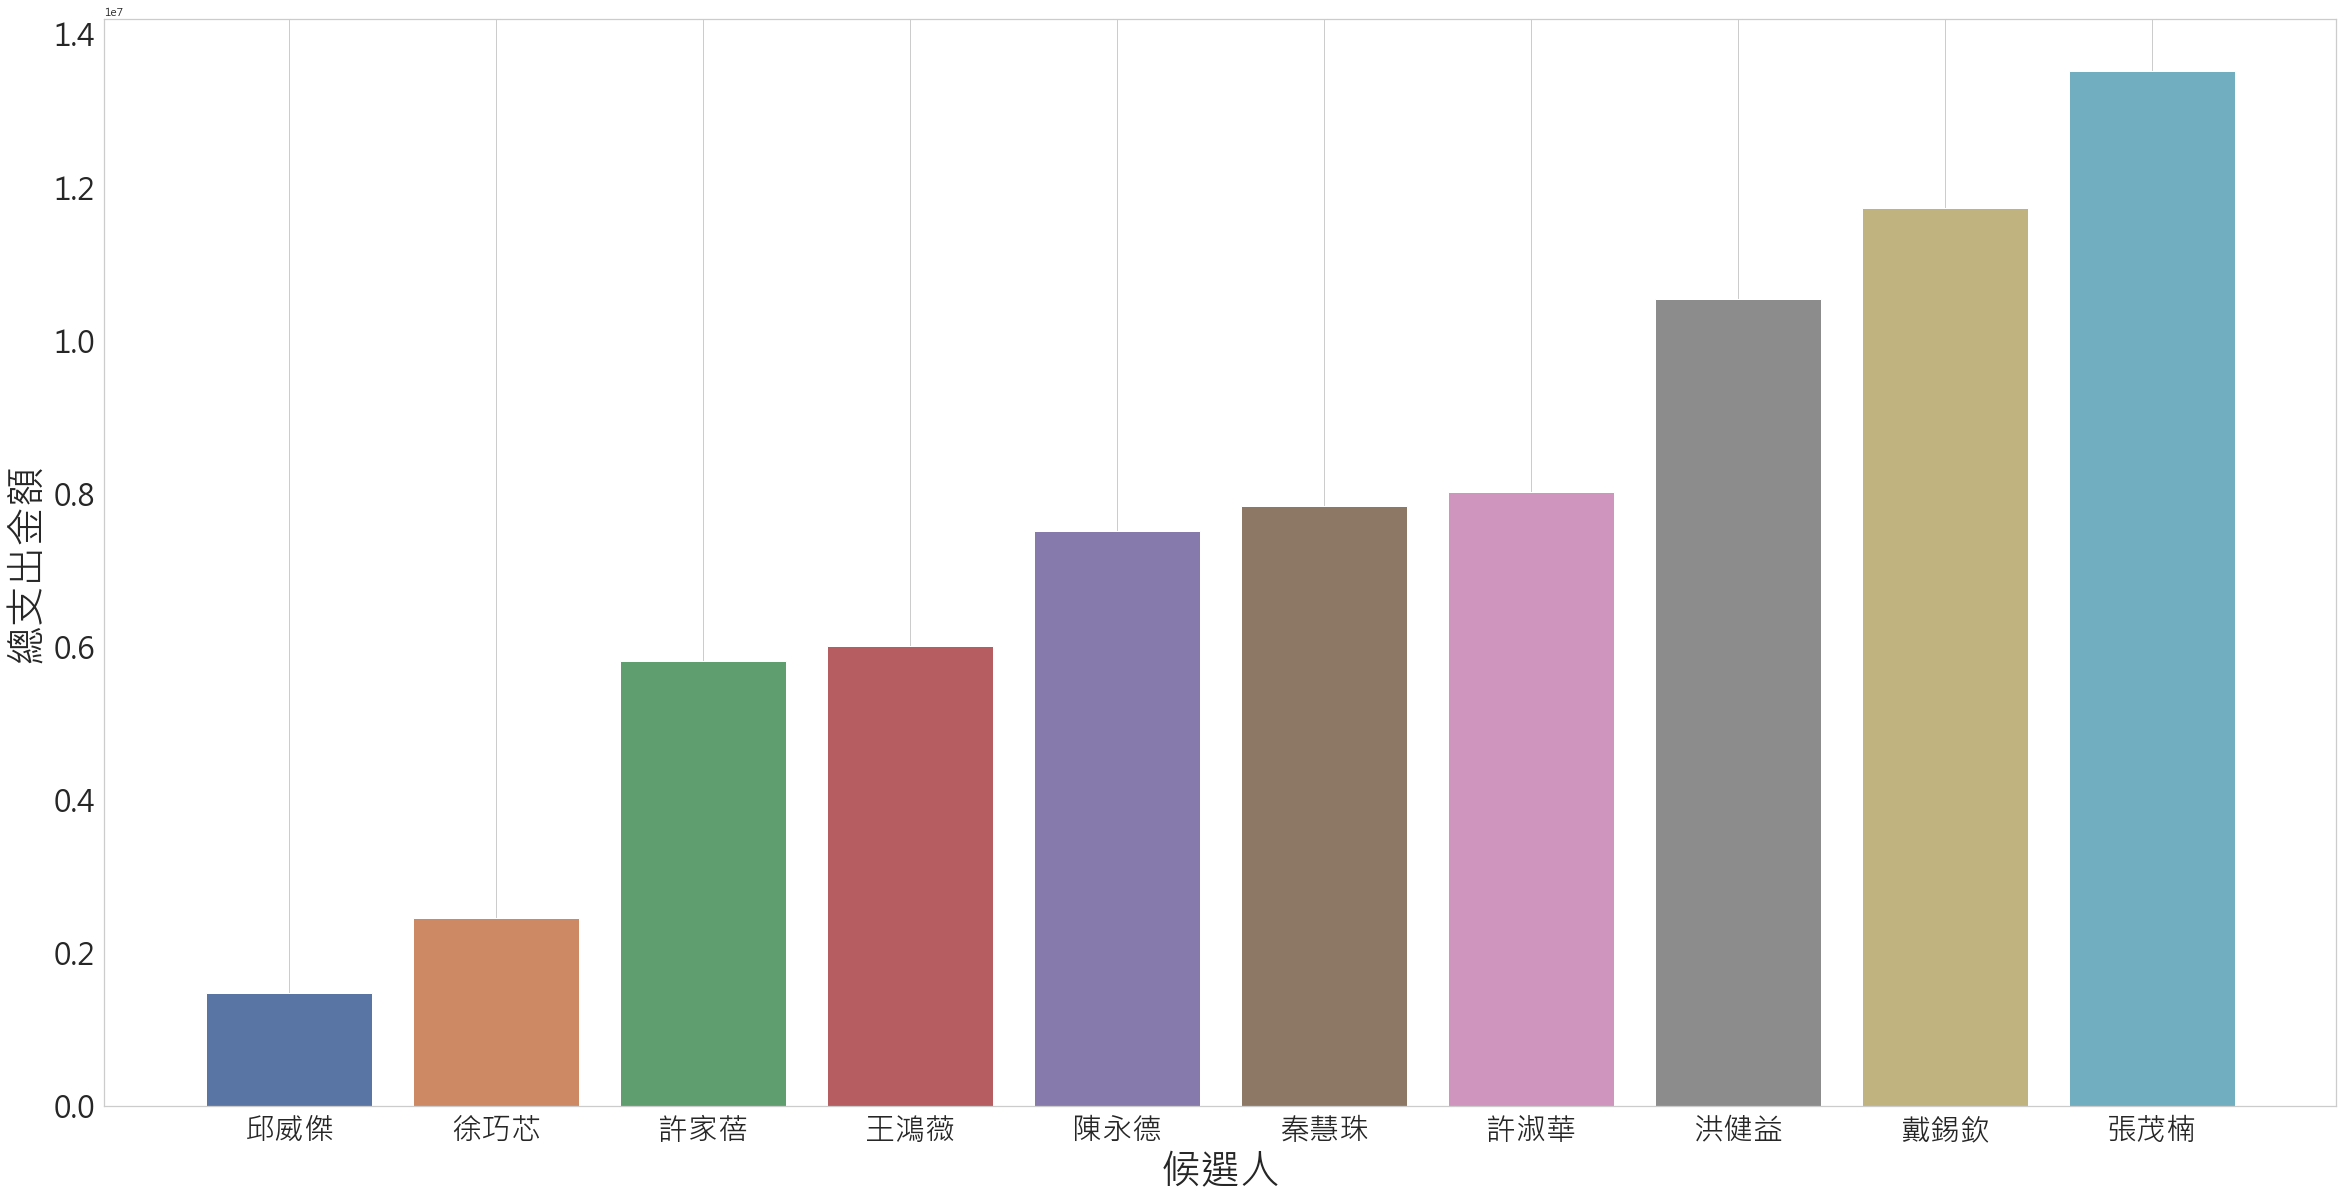

In [674]:
all_expense = o_df[o_df['支出金額']!=0].groupby(by='項目名稱').sum().reset_index().sort_values(by='支出金額')
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="支出金額", data=all_expense[['支出金額','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('總支出金額',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### a. 支出項目

幾乎所有候選人都花費了大量的金錢在宣傳方面，並且集會其實也有部分是宣傳型的集會，但是宣傳費如此高昂是否有收到實質的效果其實不是絕對

<Figure size 2880x1440 with 0 Axes>

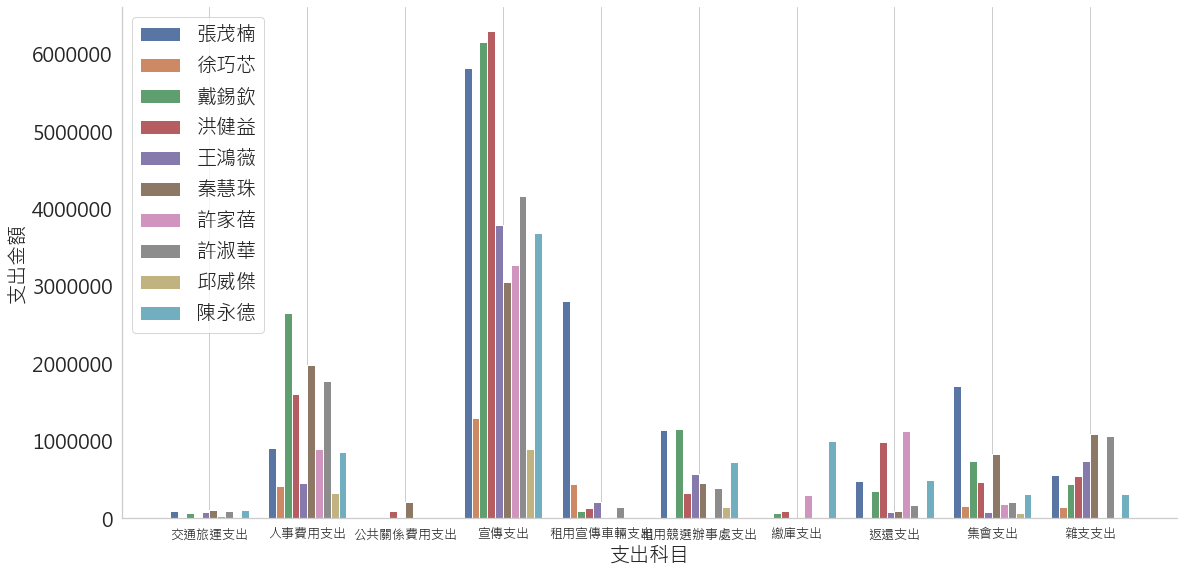

In [676]:
ie_cate = o_df.groupby(['項目名稱', '收支科目']).sum().reset_index()
plt.figure(figsize=(40, 20))
sns.factorplot(x='收支科目', y='支出金額', hue='項目名稱', data=ie_cate[ie_cate['支出金額'] != 0], kind='bar',size=8, aspect=2,legend=False)
plt.ylabel('支出金額',fontsize=20)
plt.xlabel('支出科目',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc='upper left')
plt.grid()
_ = plt.plot()

#### b. 政治獻金餘額

許多候選人不論是在募捐階段或是支出階段，都沒有好好的規劃自己的金錢用途，政治獻金的目的是選舉，超支跟超收，都是一大問題，尤其像其中餘額九百多萬根本就是非常誇張的數字，這樣超收超支的傳統非常需要改變。

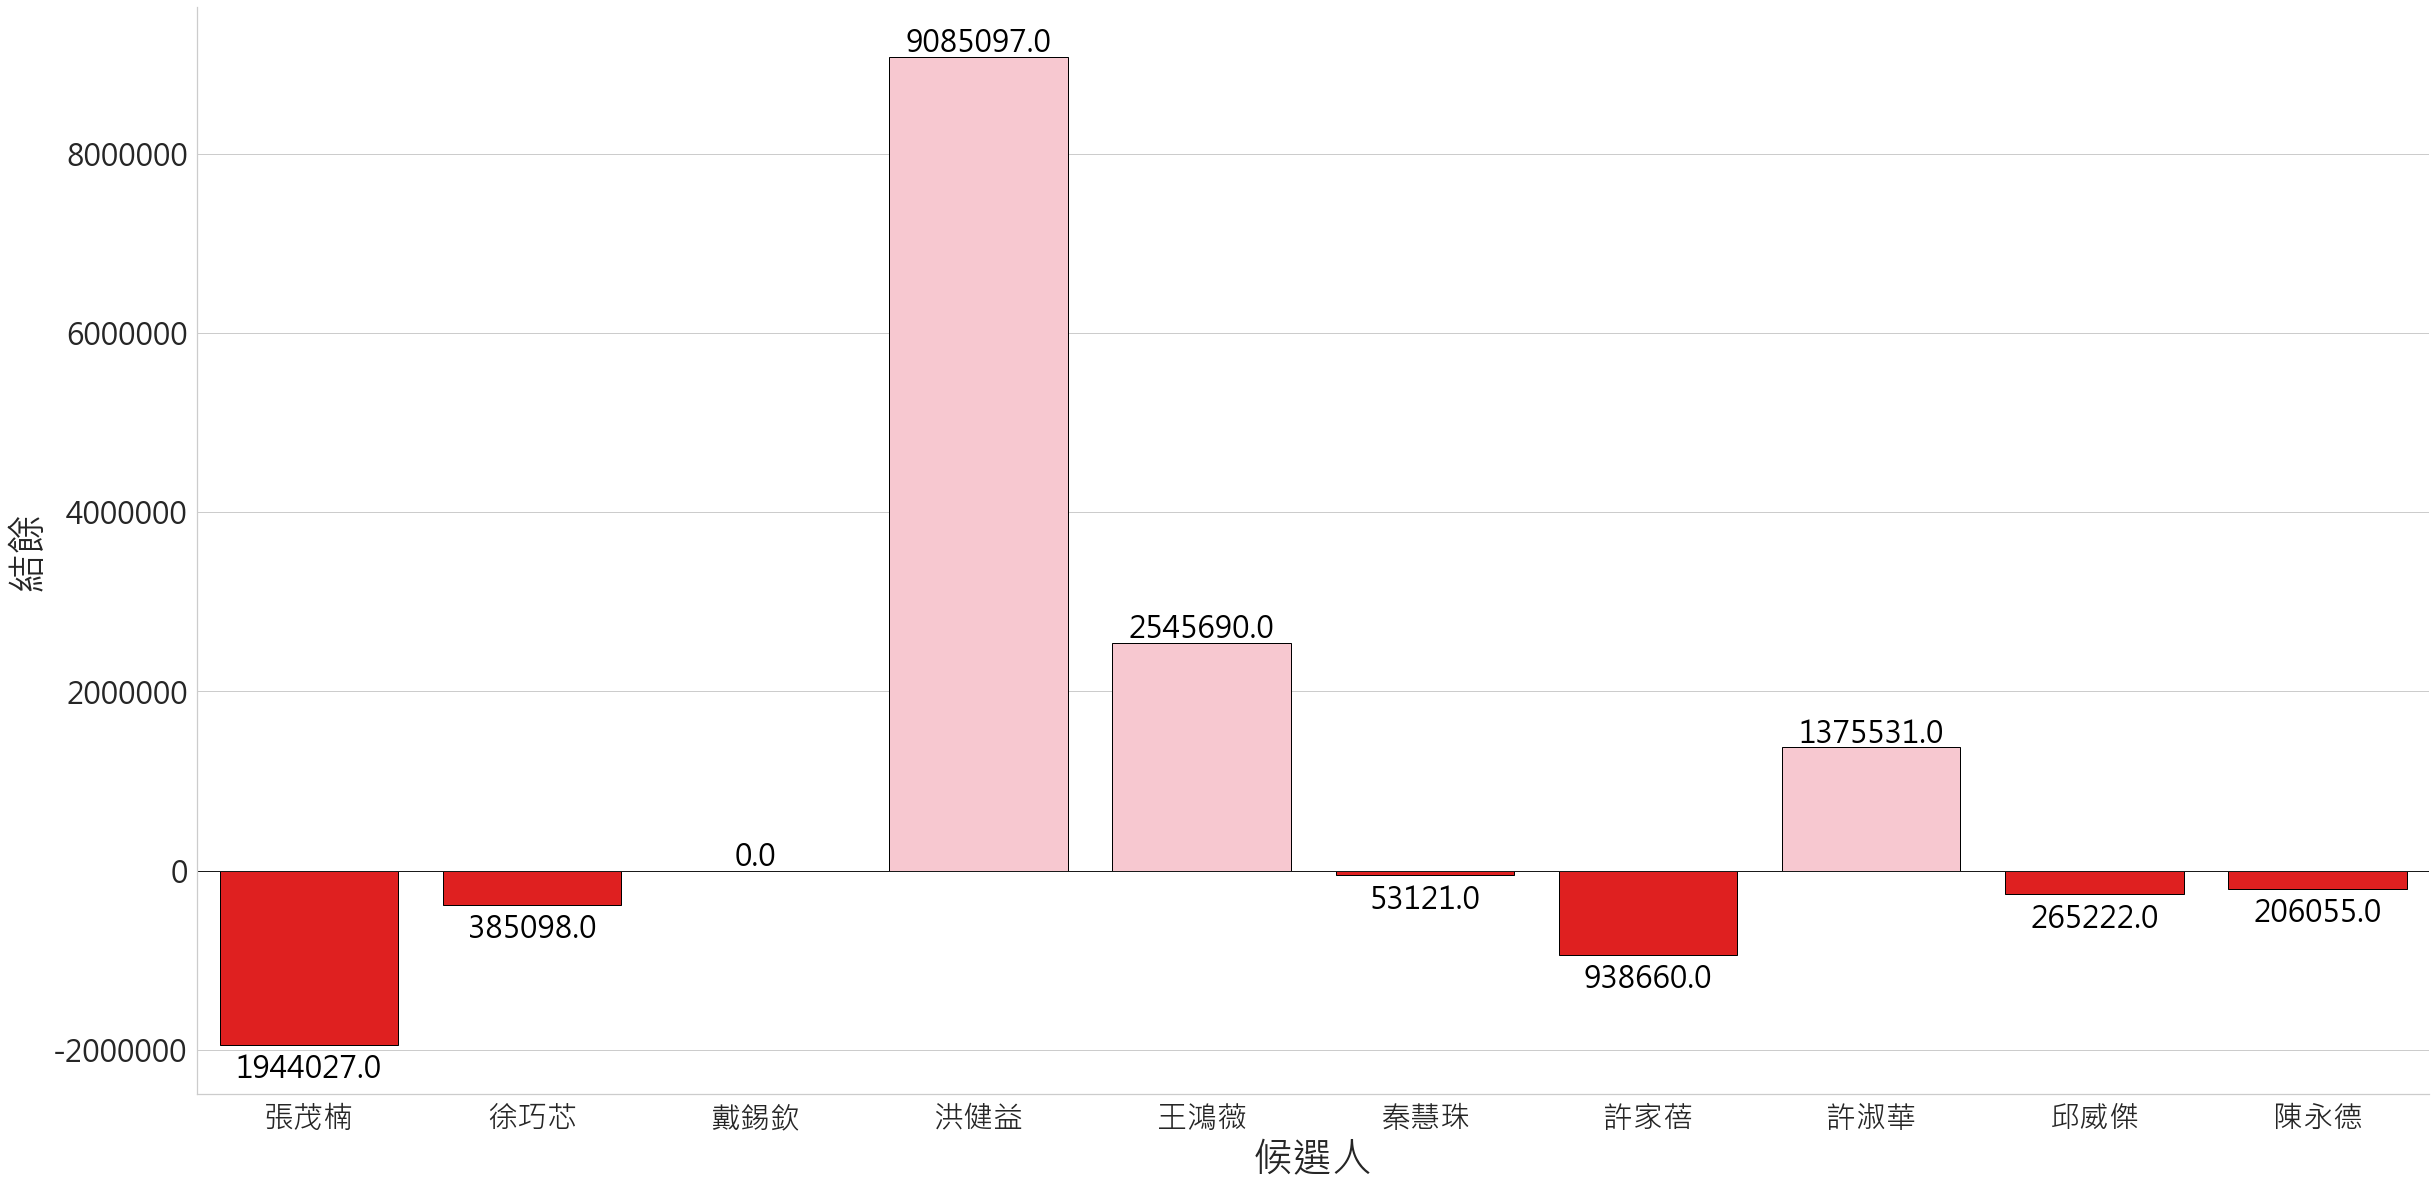

In [21]:
x = list(all_income.sort_values(by='項目名稱')['項目名稱'])
y = list(all_income.sort_values(by='項目名稱')['收入金額'] - all_expense.sort_values(by='項目名稱')['支出金額'])

plt.figure(figsize=(40, 20))
plt.ylabel('結餘',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y,palette=colors, edgecolor='black')

for n, (label, _y) in enumerate(zip(x, y)):
    if _y < 0:
        place = (0,-25)
    else:
        place = (0,13)
        
    ax.annotate(
        s='{:.1f}'.format(abs(_y)),
        xy=(n, _y),
        ha='center',va='center',
        xytext=place,
        textcoords='offset pixels',
        color='black',
        weight='bold',
        fontsize =30
    )


plt.axhline(0, color='k', lw=1)
sns.despine(ax=ax)

#### C. 來看特定候選人怎麼超支

我們接下來就來看看超支快兩百萬的張茂楠怎麼花那麼多錢，可以看到許多不必要的支出項目，接下來就來逐一檢視

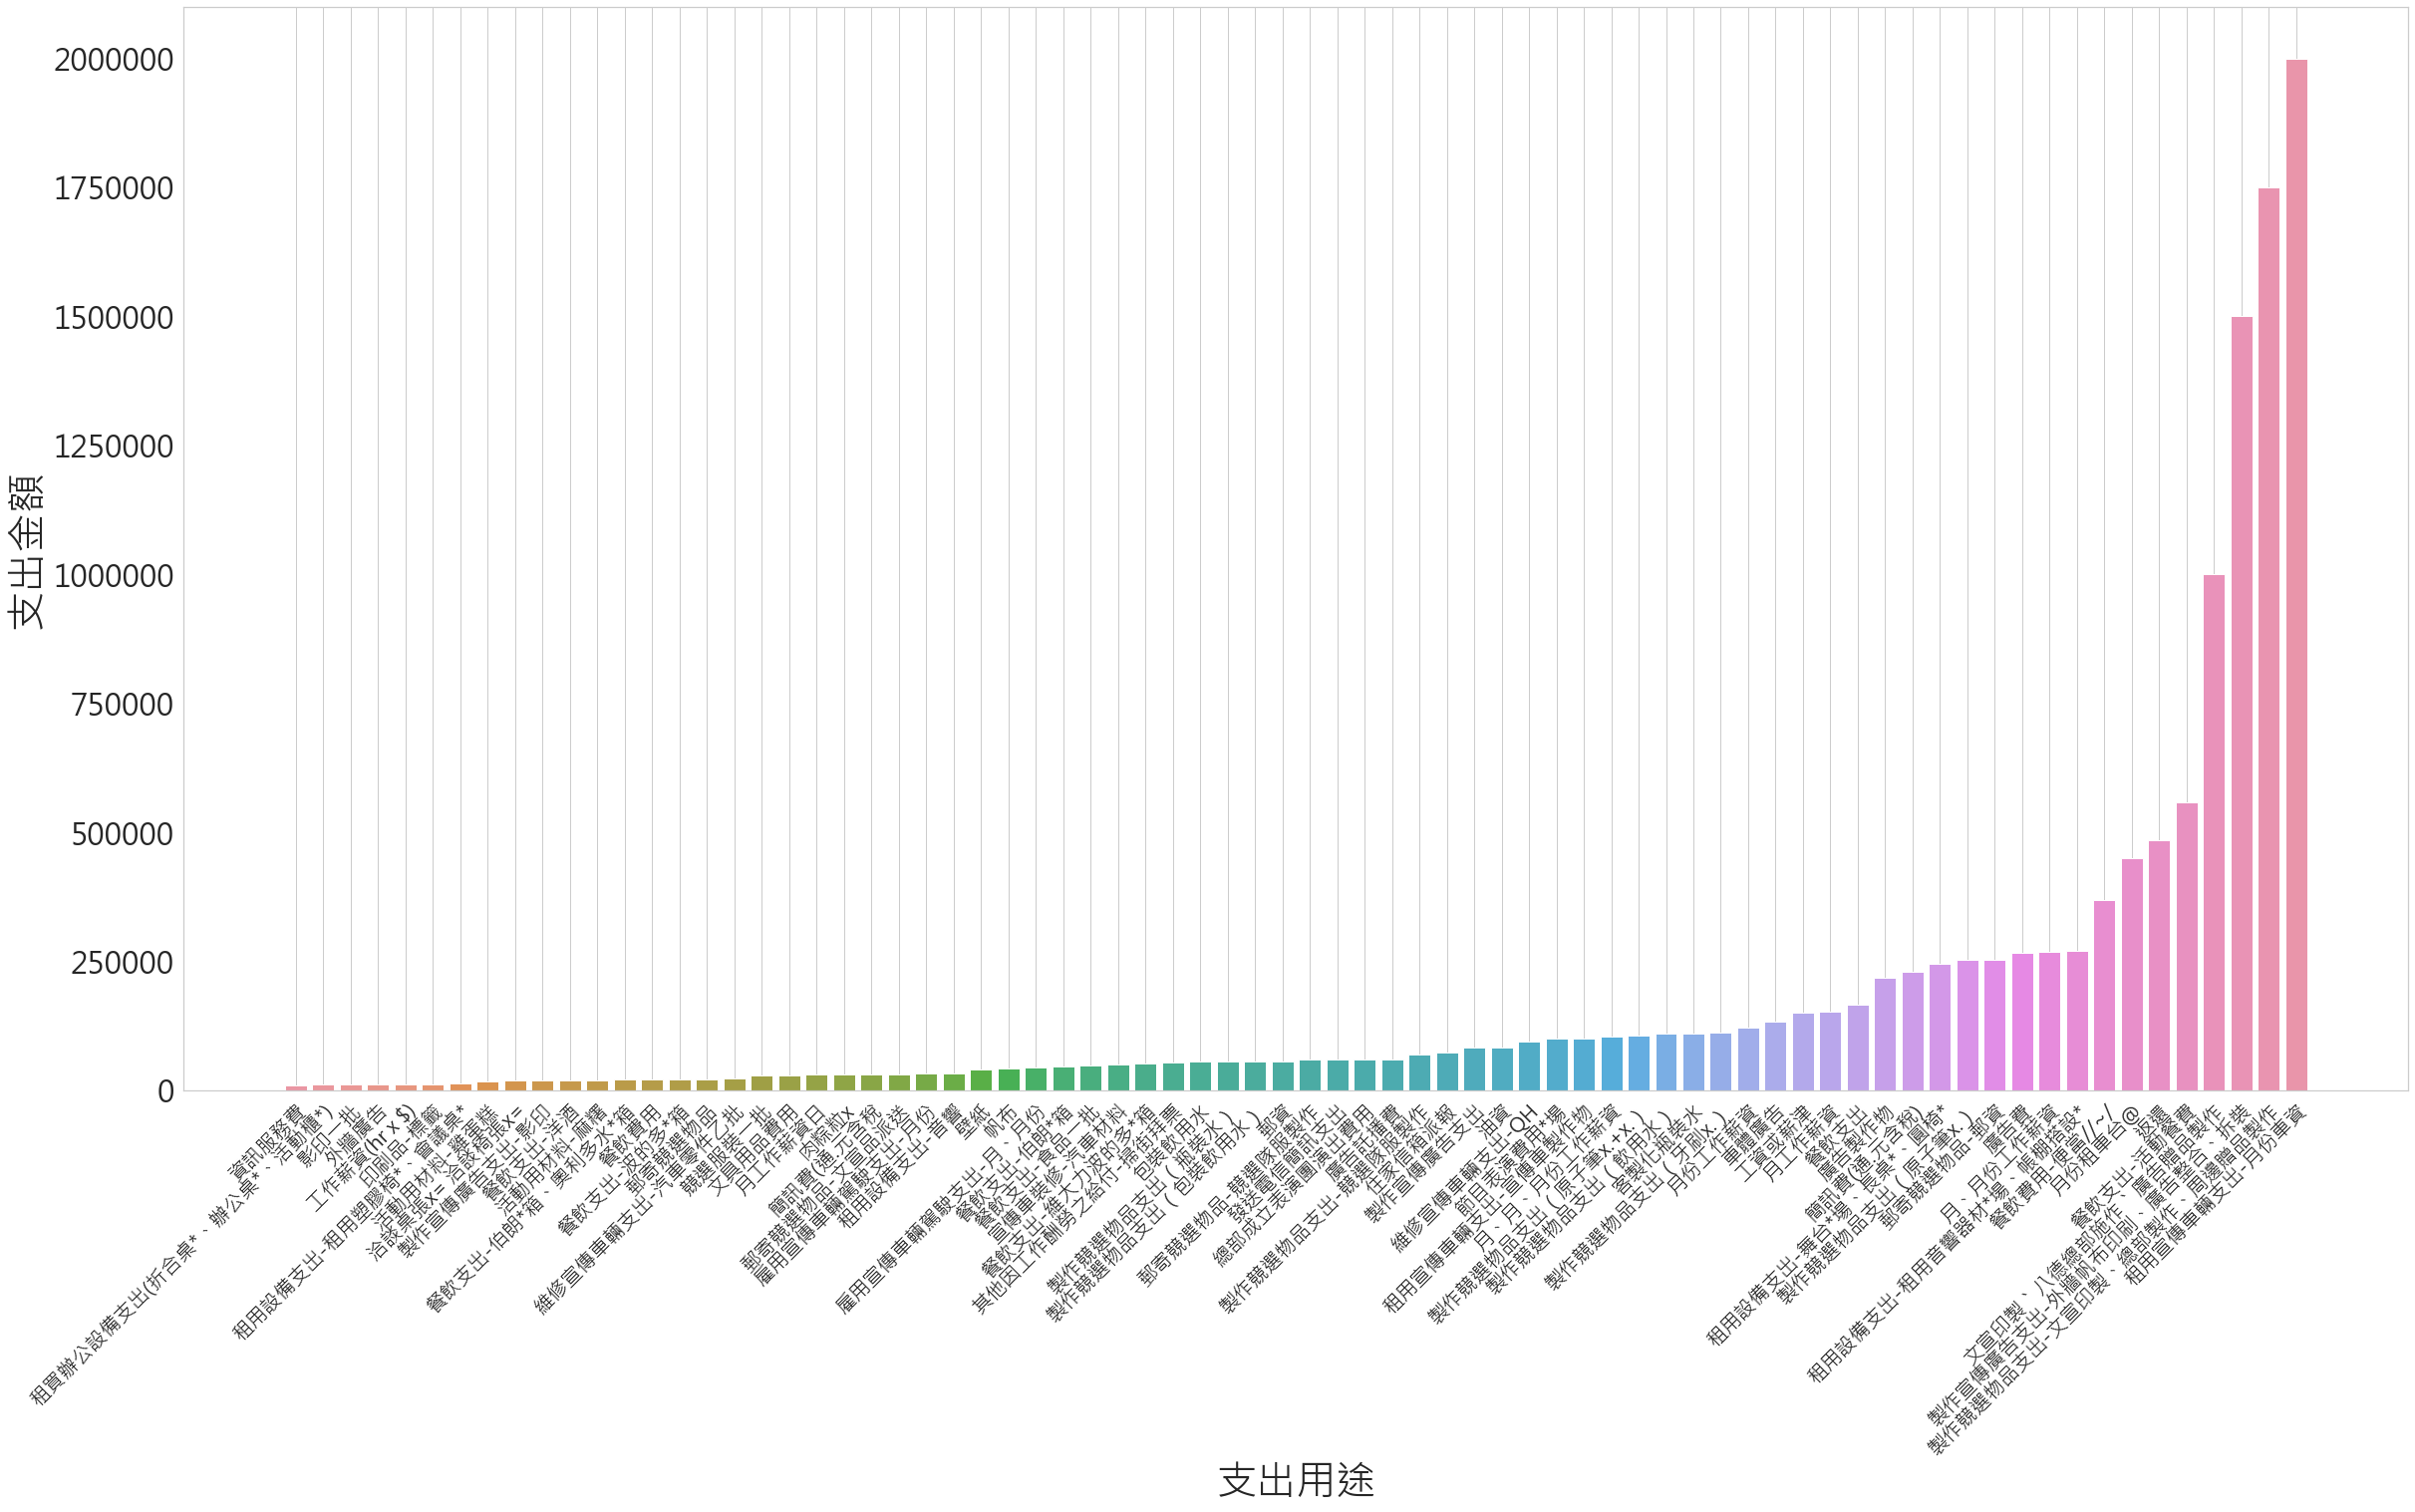

In [22]:
c_df = jang
expense = c_df[c_df['支出金額']!=0].groupby(by='支出用途').sum().reset_index().sort_values(by='支出金額')
expense = expense[expense['支出金額']>=10000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="支出用途", y="支出金額", data=expense[['支出用途','支出金額']], estimator=sum)
label = ax.get_xticklabels()
plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('支出金額',fontsize=40)
plt.xlabel('支出用途',fontsize=40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

都是所謂的餐會、集會時候的支出

In [23]:
expense[expense['支出用途'].str.contains("餐飲支出")]

支出用途  收入金額    支出金額  資料更正日期
136           餐飲支出-洋酒     0   20000     0.0
134  餐飲支出-伯朗*箱、奧利多水*箱     0   21400     0.0
135        餐飲支出-波的多*箱     0   21460     0.0
133         餐飲支出-伯朗*箱     0   45600     0.0
140         餐飲支出-食品一批     0   48545     0.0
139     餐飲支出-維大力波的多*箱     0   51100     0.0
132              餐飲支出     0  166678     0.0
138         餐飲支出-活動餐費     0  559016     0.0

還買這種小點心

In [24]:
expense[expense['支出用途'].str.contains("活動用材料")]

支出用途  收入金額   支出金額  資料更正日期
52  活動用材料-雞蛋糕     0  18000     0.0
53   活動用材料-麻糬     0  20000     0.0

張茂楠希望大家多刷牙，但這樣發牙刷的政策真的有助於選票嗎？

In [25]:
expense[expense['支出用途'].str.contains("牙刷")]

支出用途  收入金額    支出金額  資料更正日期
95  製作競選物品支出（牙刷x.）     0  111250     0.0

#### 6. 與其他無黨籍當選人比較

有些人會覺得對於有黨派的候選人，政治獻金本來就會比較高，那我們接下來從同樣無黨籍的當選人來看

In [27]:
n_df = pd.read_csv('無黨籍當選人.csv')
n_df.head()

項目名稱         選舉名稱 申報序號∕年度             交易日期    收支科目 捐贈者∕支出對象    身分證∕統一編號  \
0  陳建銘  107年臺北市議員選舉      首次  107 年 04 月 25 日  人事費用支出      梁莉萍  F22*******   
1  陳建銘  107年臺北市議員選舉      首次  107 年 04 月 25 日  人事費用支出      黃三連  R10*******   
2  陳建銘  107年臺北市議員選舉      首次  107 年 04 月 25 日  人事費用支出      梁筱萍  F22*******   
3  陳建銘  107年臺北市議員選舉      首次  107 年 04 月 30 日  人事費用支出      黃鼎明  F12*******   
4  陳建銘  107年臺北市議員選舉      首次  107 年 04 月 30 日  人事費用支出      徐可俐  T22*******   

   收入金額   支出金額   支出用途 金錢類          地址 聯絡電話  資料更正日期  
0     0  40000  工資或薪津  金錢  臺北市士林區****  NaN     NaN  
1     0  50000  工資或薪津  金錢  台北市士林區****  NaN     NaN  
2     0  40000  工資或薪津  金錢  臺北市士林區****  NaN     NaN  
3     0  10000  工資或薪津  金錢  新北市淡水區****  NaN     NaN  
4     0  45000  工資或薪津  金錢  臺北市士林區****  NaN     NaN

In [28]:
n_df = pd.concat([n_df,df],axis=0,sort=False)

#### A. 從收入來看

可以發現政治獻金的收入金額數量跟政黨無絕對的關係

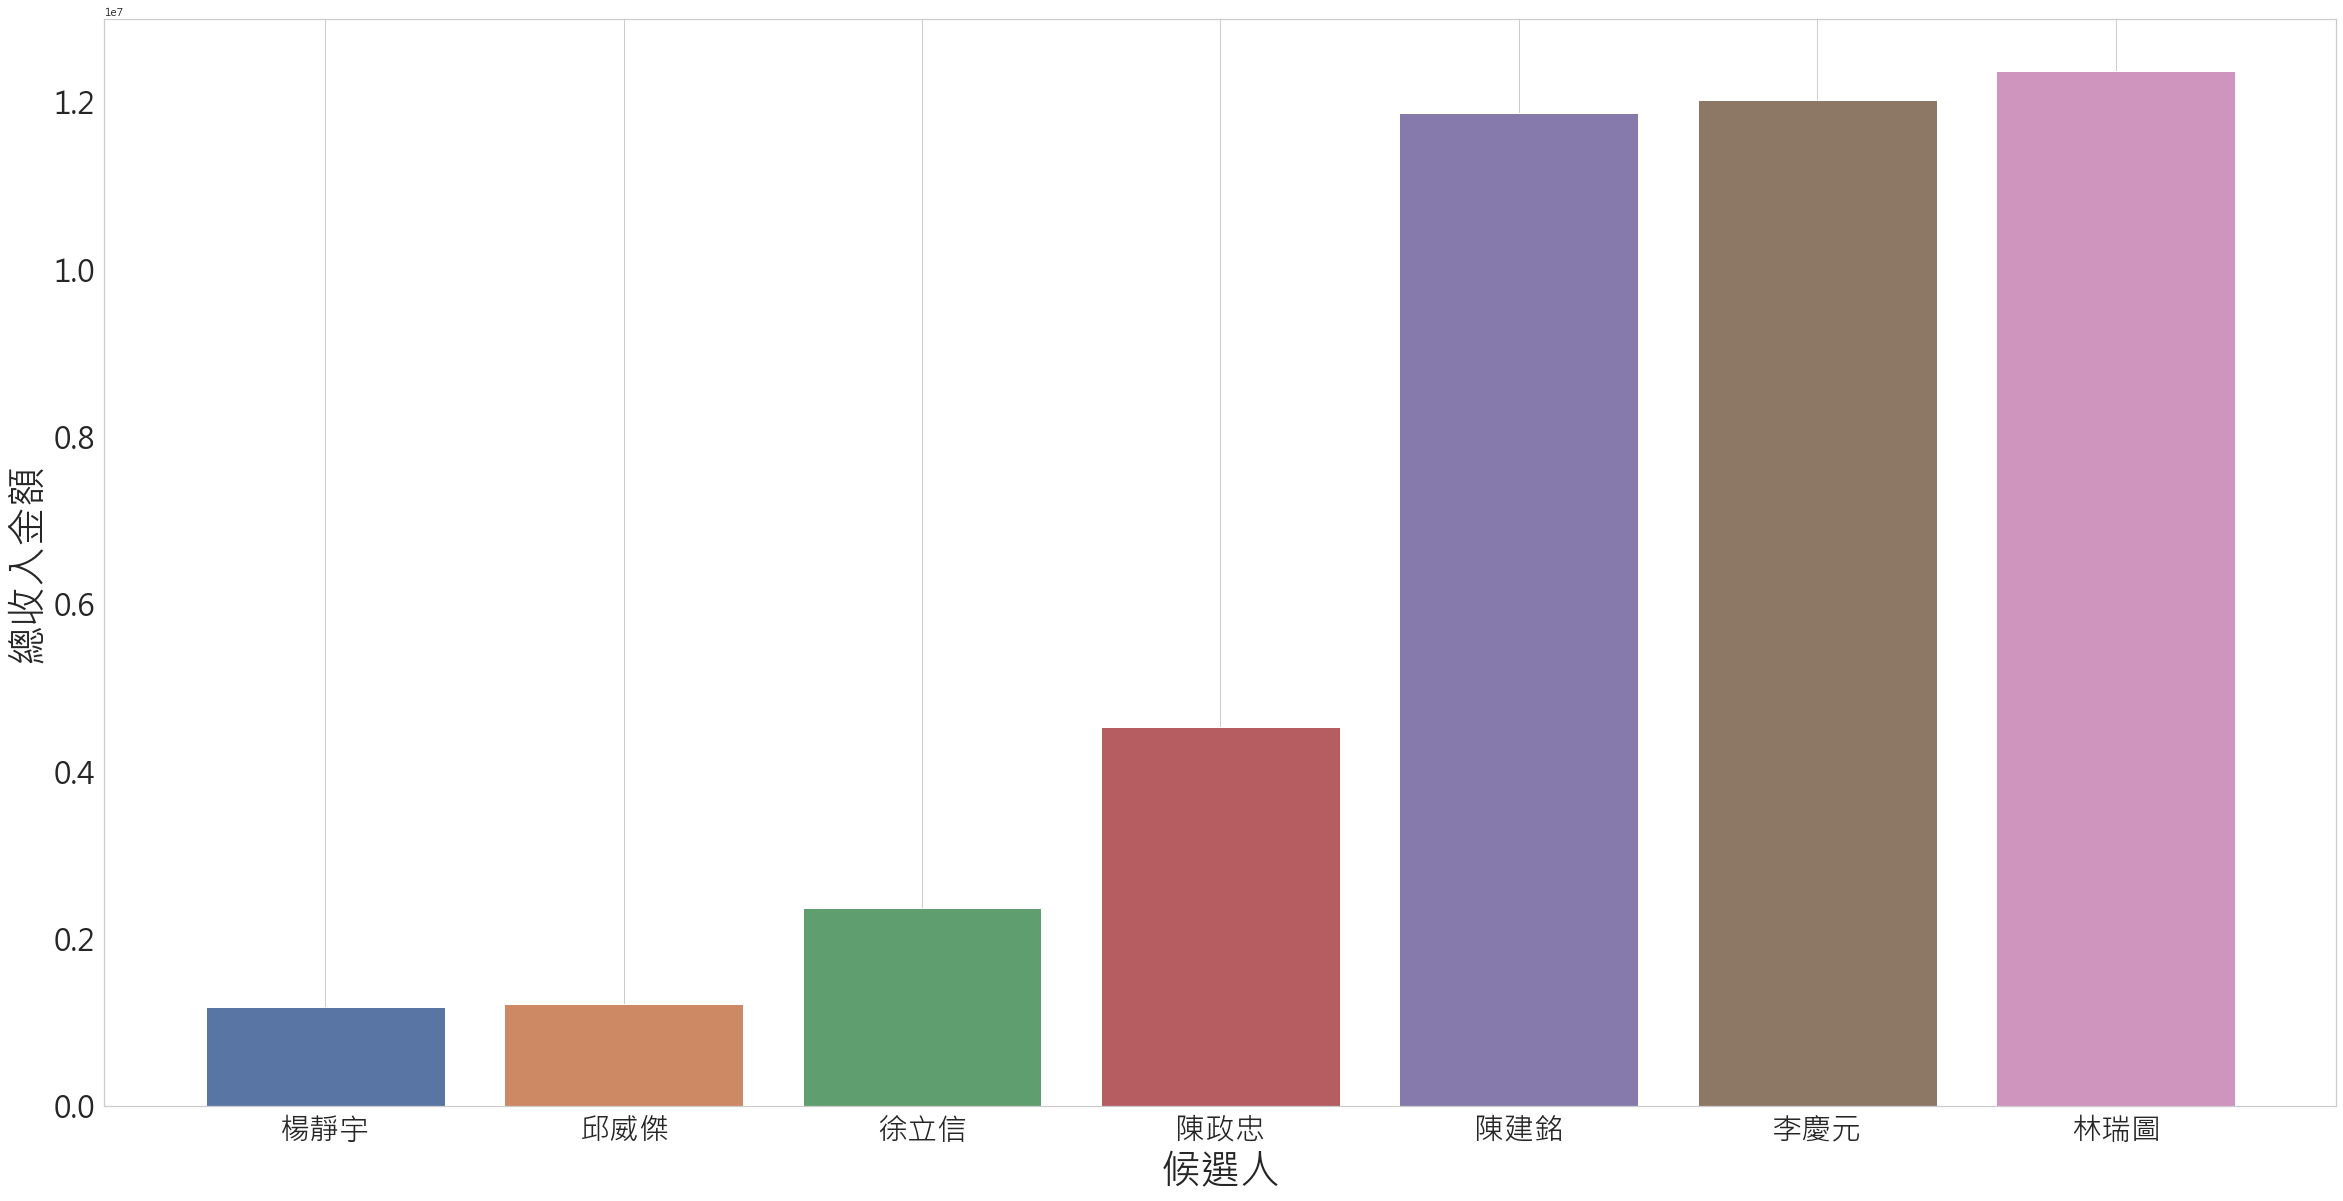

In [87]:
all_income = n_df[n_df['收入金額']!=0].groupby(by='項目名稱').sum().reset_index().sort_values(by='收入金額')
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="收入金額", data=all_income[['收入金額','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('總收入金額',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

##### a. 從收入項目來看

同樣跟收不收營利事業的錢也有很大關係，收了錢，就要幫忙喬事情

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2880x1440 with 0 Axes>

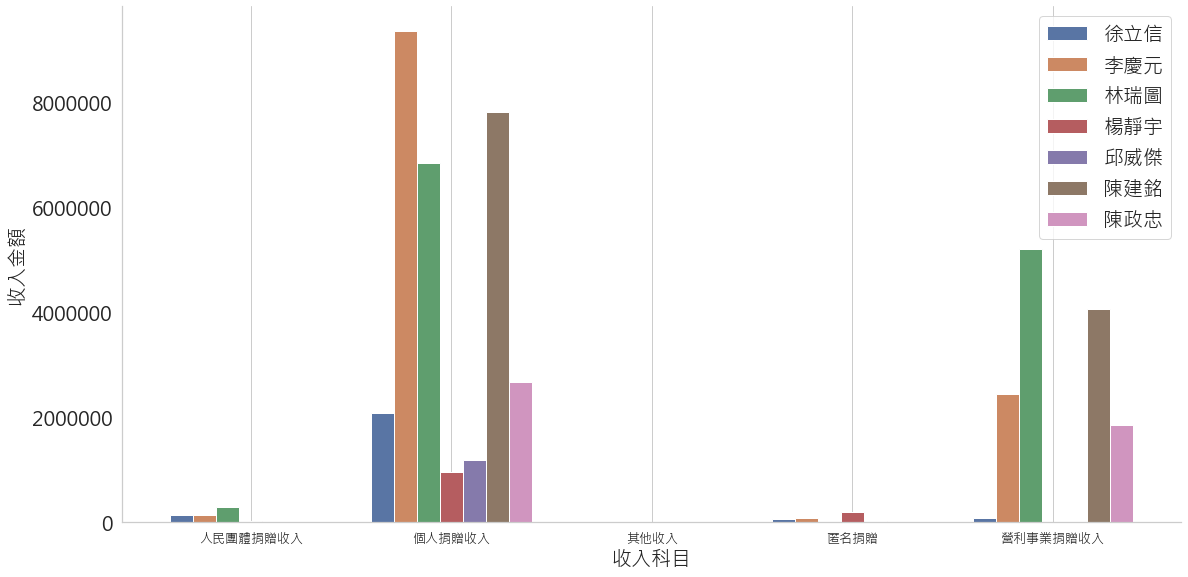

In [30]:
i_cate = n_df.groupby(['項目名稱', '收支科目']).sum().reset_index()
plt.figure(figsize=(40, 20))
sns.factorplot(x='收支科目', y='收入金額', hue='項目名稱', data=i_cate[i_cate['收入金額'] != 0], kind='bar',size=8, aspect=2,legend=False)
plt.ylabel('收入金額',fontsize=20)
plt.xlabel('收入科目',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc='upper right')
plt.grid()
_ = plt.plot()

#### B. 從支出來看

支出金額如同有政黨的候選人一樣，支出非常高，再次印證了政治獻金的支出收入，皆與政黨無關

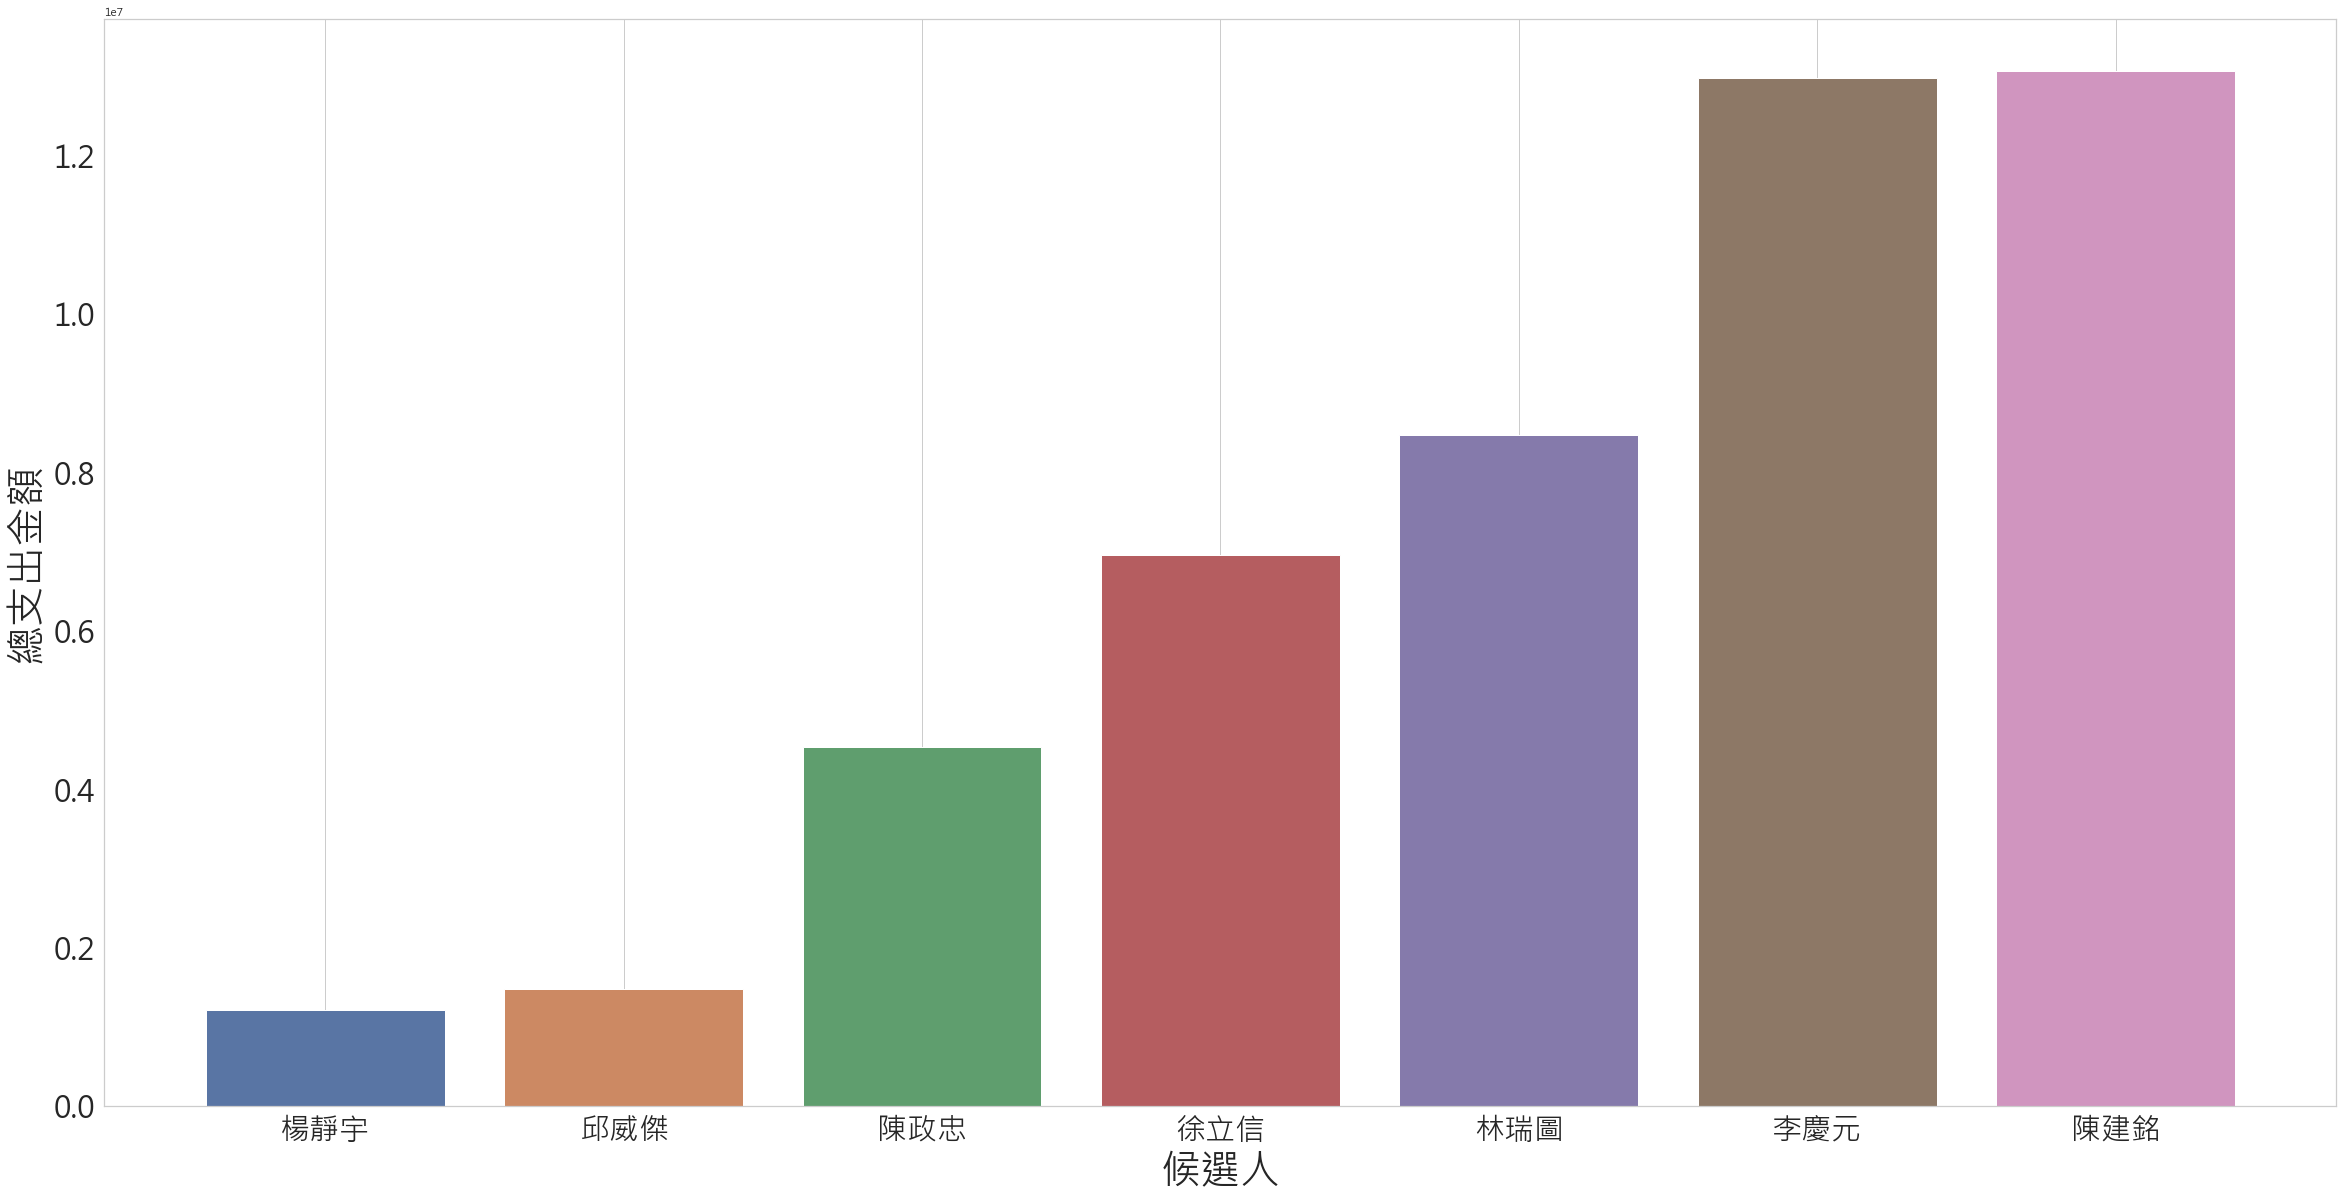

In [31]:
all_expense = n_df[n_df['支出金額']!=0].groupby(by='項目名稱').sum().reset_index().sort_values(by='支出金額')
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="支出金額", data=all_expense[['支出金額','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('總支出金額',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### a. 從支出項目來看

人事費用高的誇張的幾位議員，其實也會讓許多人質疑需要這麼大的競選團隊才能勝選嗎？

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2880x1440 with 0 Axes>

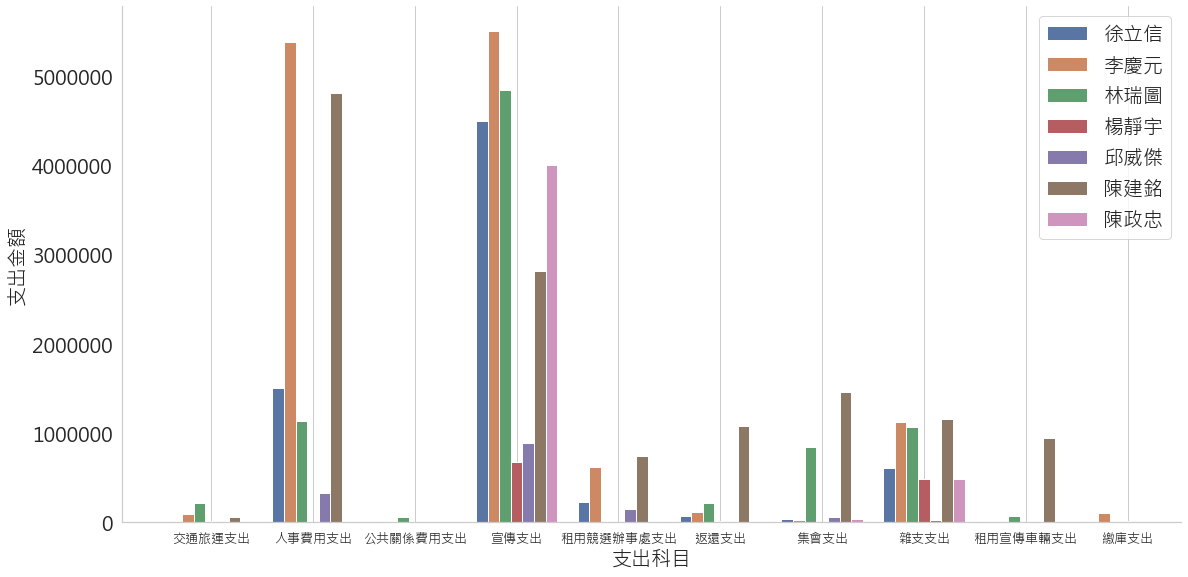

In [32]:
ie_cate = n_df.groupby(['項目名稱', '收支科目']).sum().reset_index()
plt.figure(figsize=(40, 20))
sns.factorplot(x='收支科目', y='支出金額', hue='項目名稱', data=ie_cate[ie_cate['支出金額'] != 0], kind='bar',size=8, aspect=2,legend=False)
plt.ylabel('支出金額',fontsize=20)
plt.xlabel('支出科目',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc='upper right')
plt.grid()
_ = plt.plot()

#### b. 政治獻金餘額

同樣政治獻金應該是規劃花多少，就收多少，而不是無限上綱永遠花不夠，或是根本花不完，超支四百多萬是非常誇張的數字

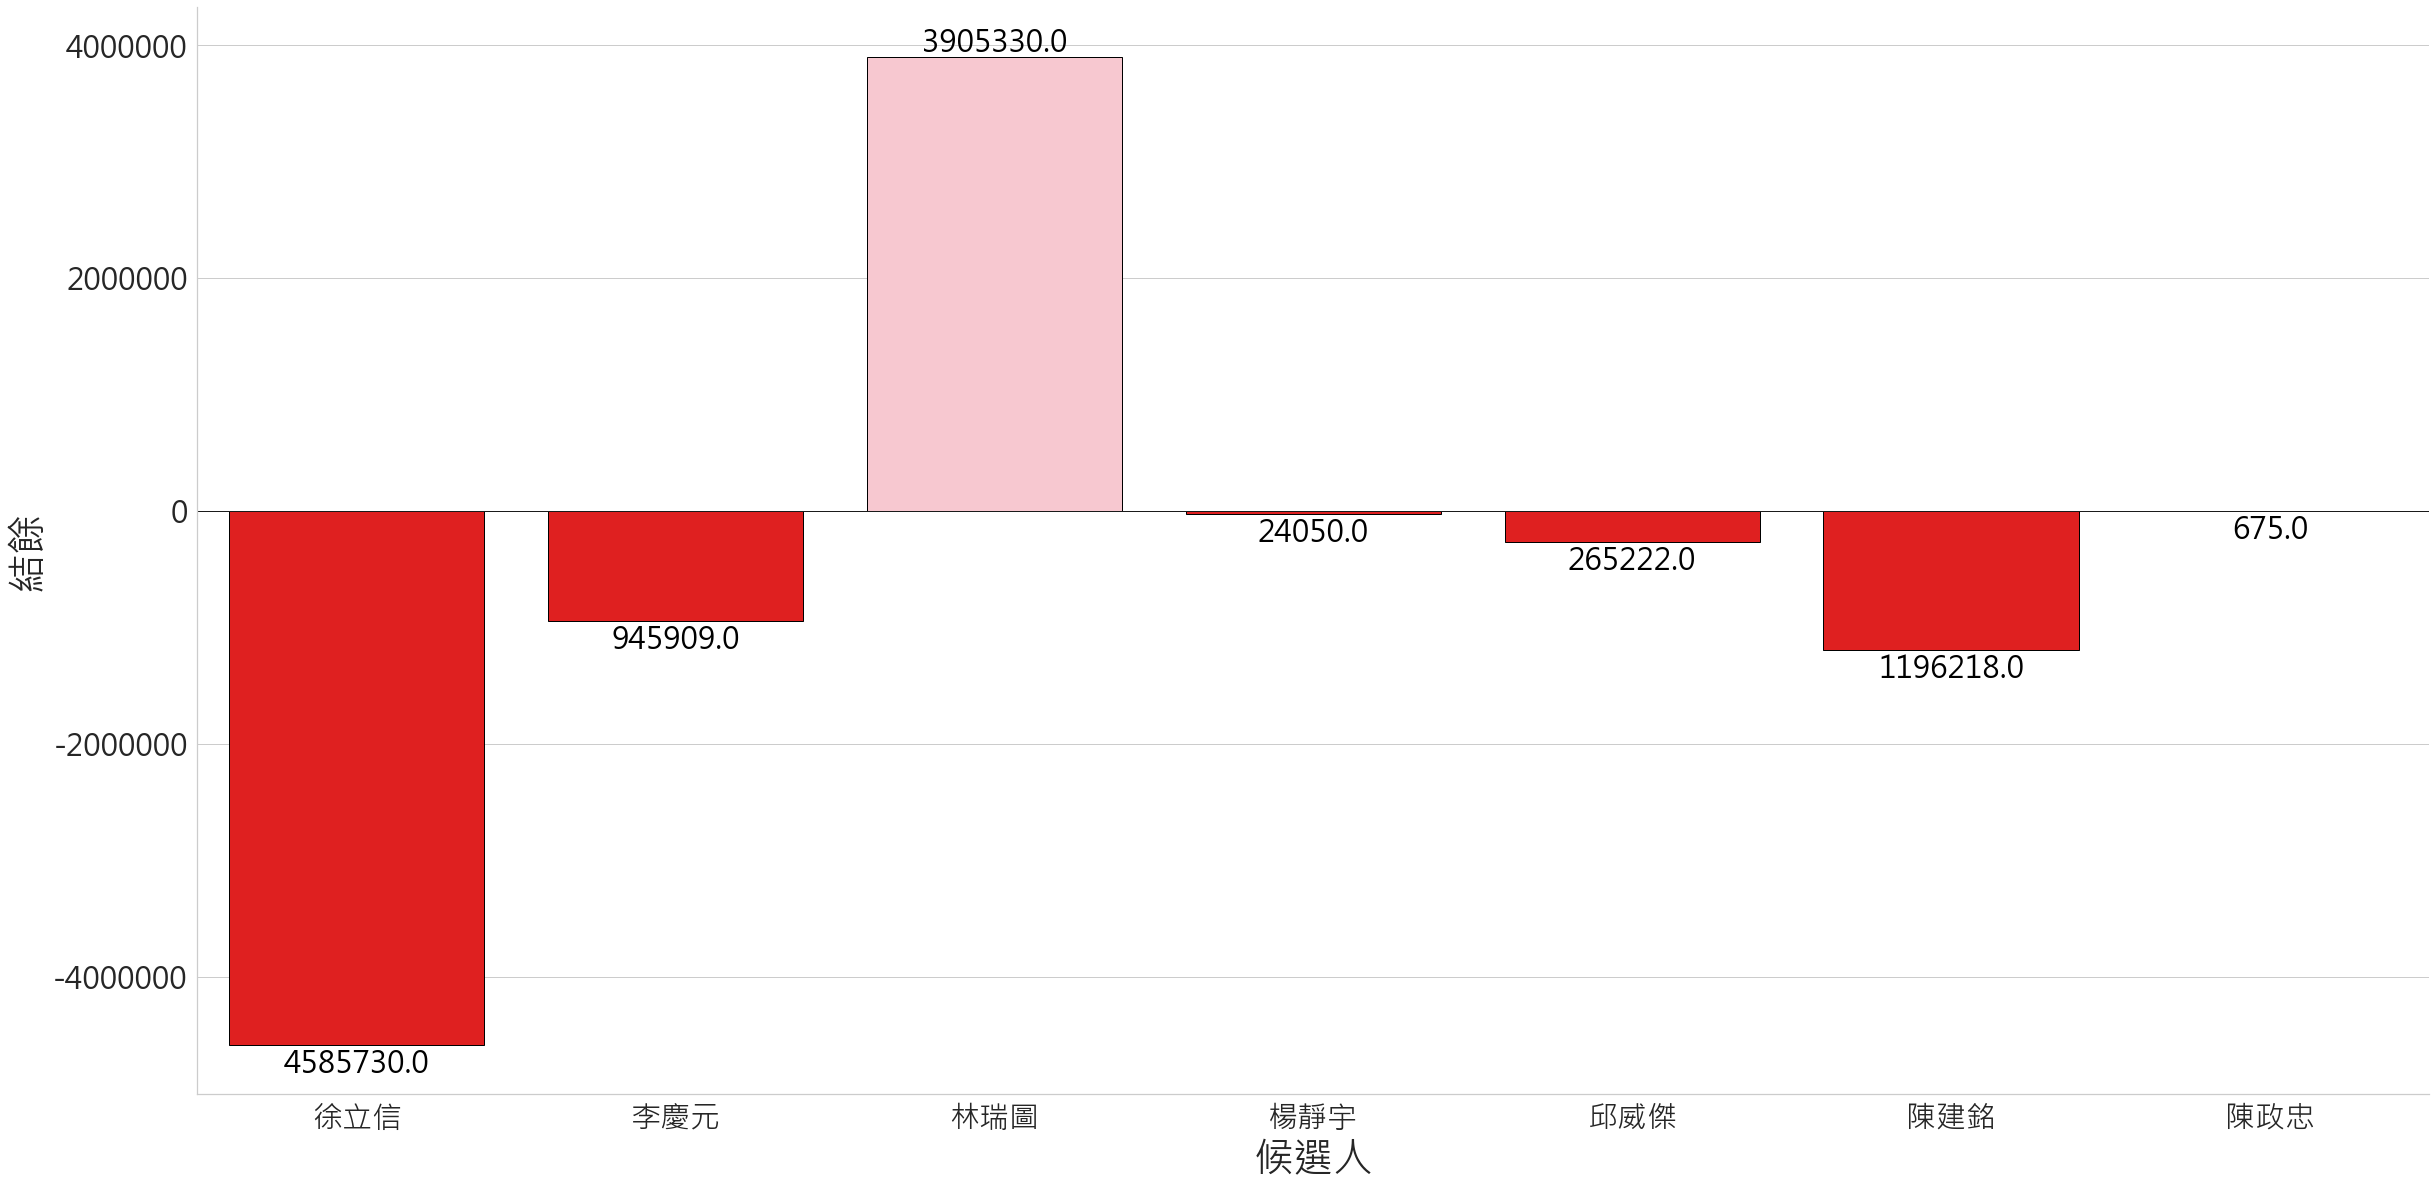

In [33]:
x = list(all_income.sort_values(by='項目名稱')['項目名稱'])
y = list(all_income.sort_values(by='項目名稱')['收入金額'] - all_expense.sort_values(by='項目名稱')['支出金額'])

plt.figure(figsize=(40, 20))
plt.ylabel('結餘',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y,palette=colors, edgecolor='black')

for n, (label, _y) in enumerate(zip(x, y)):
    if _y < 0:
        place = (0,-20)
    else:
        place = (0,13)
        
    ax.annotate(
        s='{:.1f}'.format(abs(_y)),
        xy=(n, _y),
        ha='center',va='center',
        xytext=place,
        textcoords='offset pixels',
        color='black',
        weight='bold',
        fontsize =30
    )


plt.axhline(0, color='k', lw=1)
sns.despine(ax=ax)

#### 7. 比較楊靜宇議員的收入支出

楊靜宇的整體收支都非常低，且也沒有收營利事業捐贈，感覺蠻厲害的來看看他，身為士林區議員，上一屆高票落馬後持續在地服務，繼續以地方為出發服務士林區民，這次不負眾望當選

##### 可以看到支出相當的節儉，最多的甚至不是宣傳費用，如果以這樣的支出比例可以當上議員，想當然不用看政績就可以知道肯定是為民服務的好議員

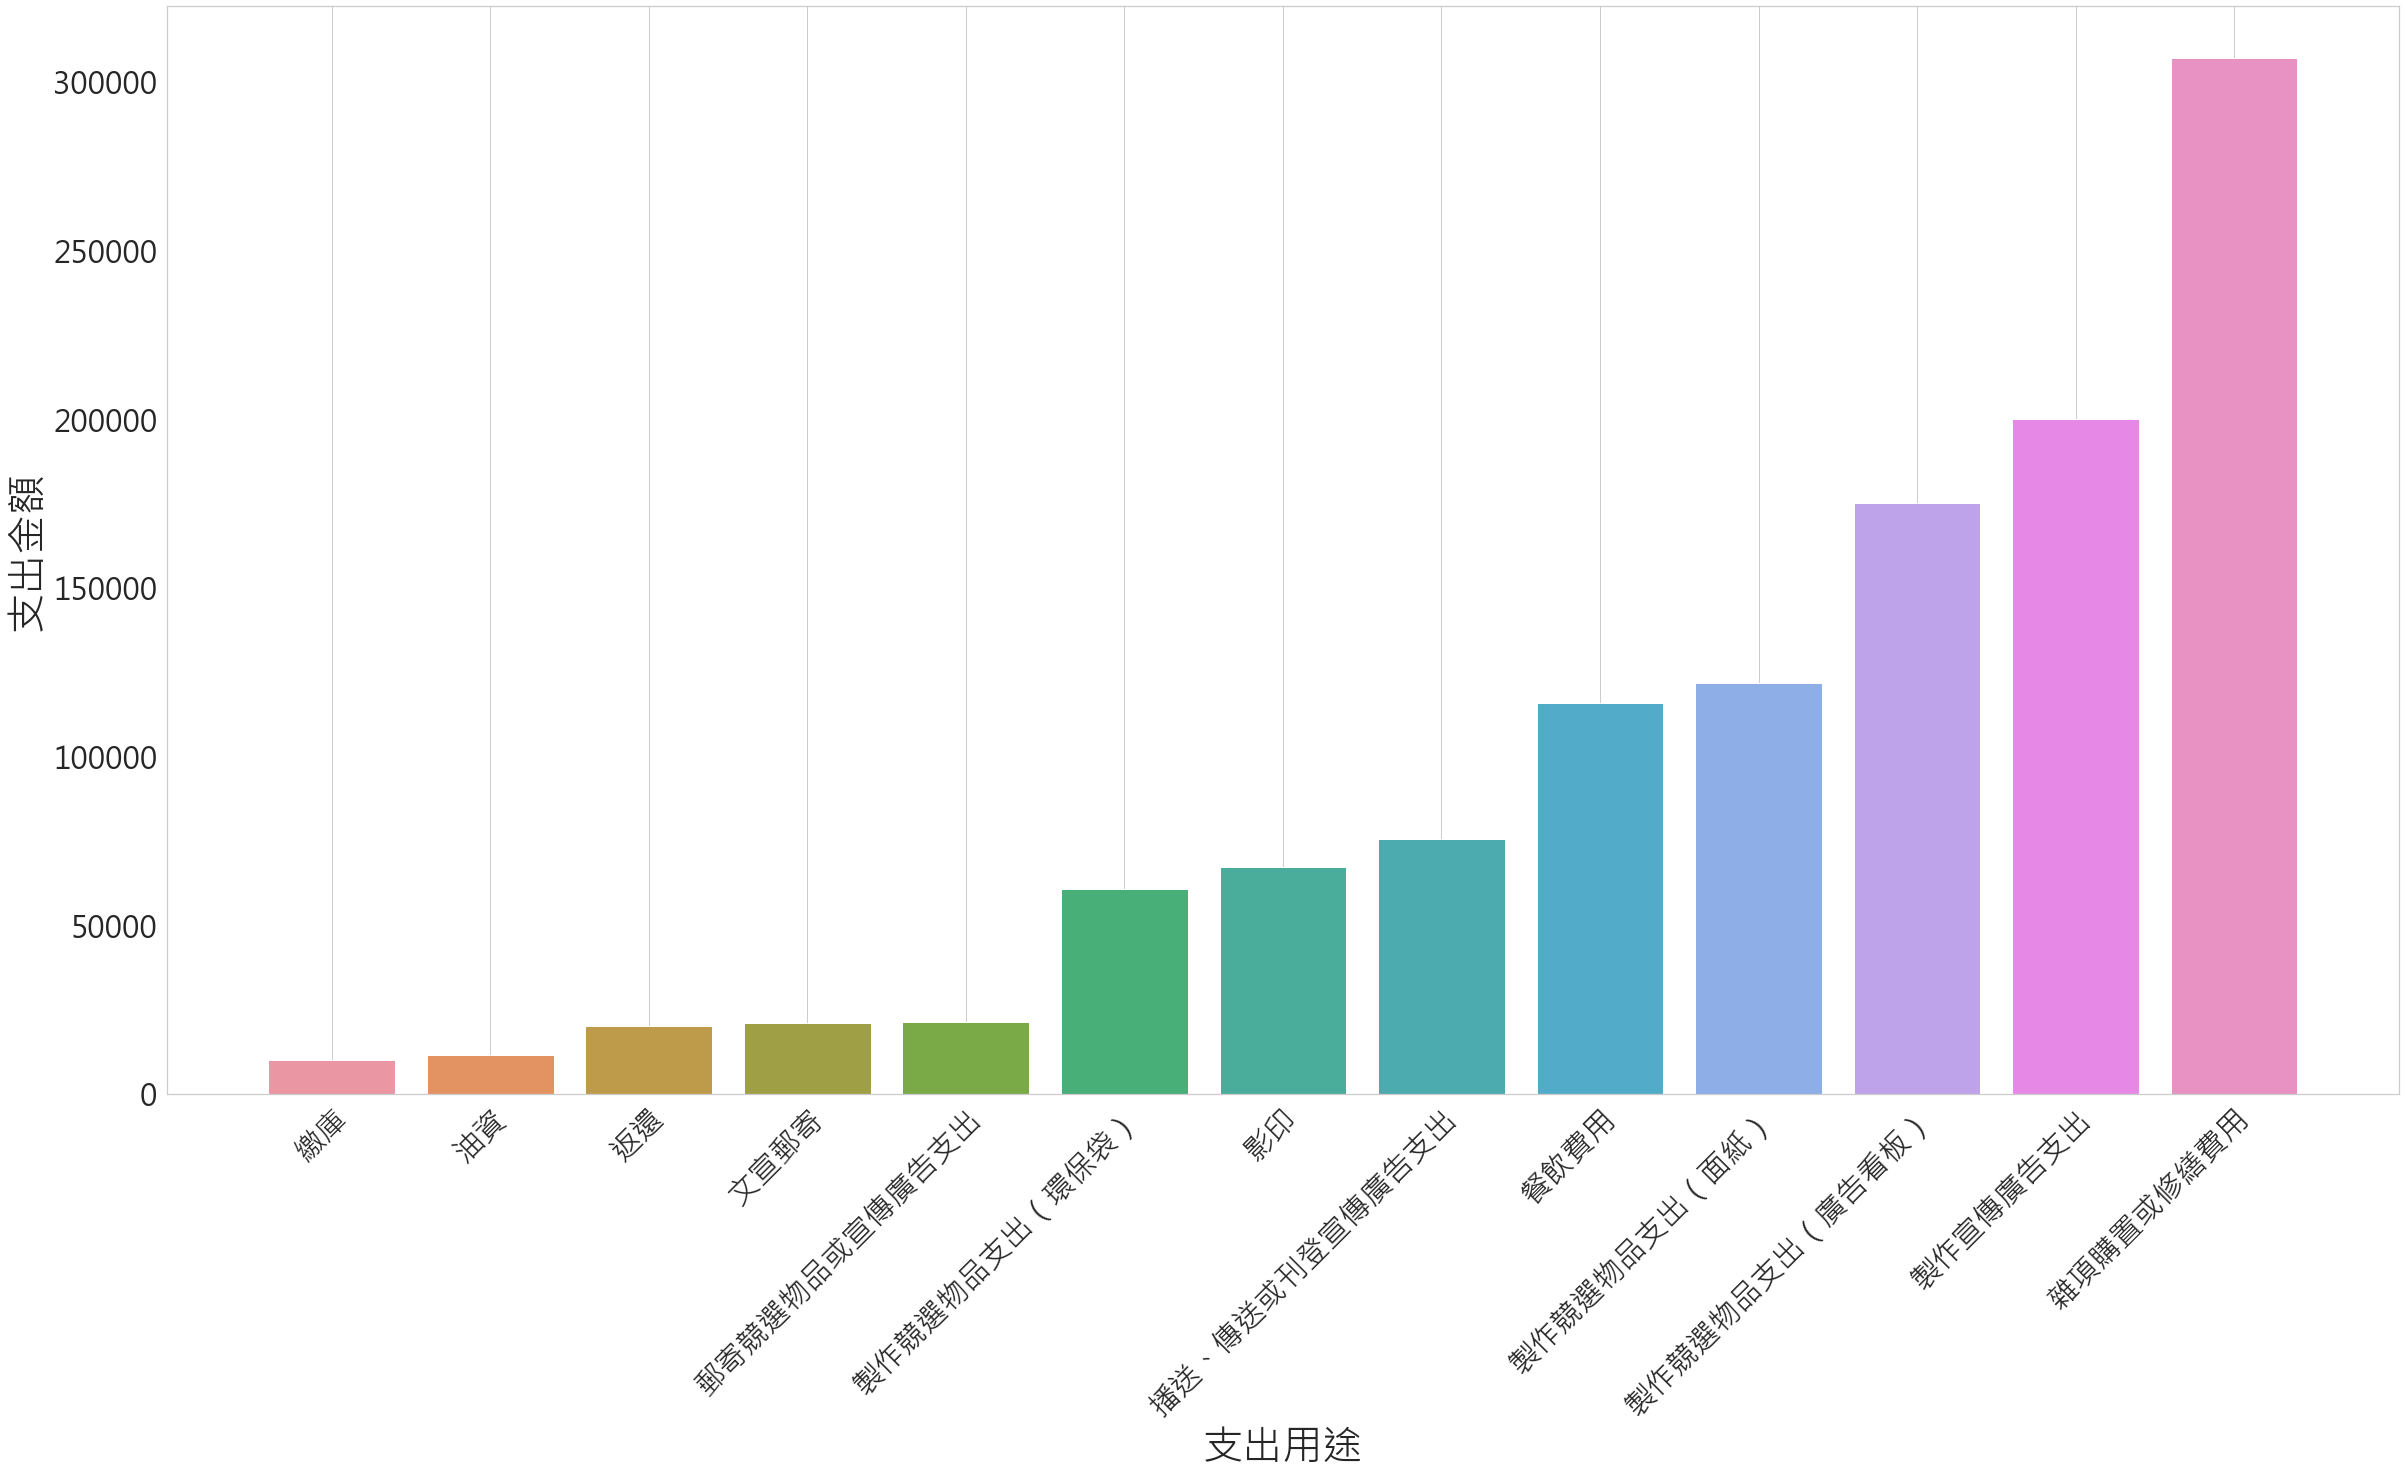

In [35]:
yang = n_df[n_df['項目名稱'] == '楊靜宇']
c_df = yang
expense = c_df[c_df['支出金額']!=0].groupby(by='支出用途').sum().reset_index().sort_values(by='支出金額')
expense = expense[expense['支出金額']>=10000]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="支出用途", y="支出金額", data=expense[['支出用途','支出金額']], estimator=sum)
label = ax.get_xticklabels()
plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('支出金額',fontsize=40)
plt.xlabel('支出用途',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

##### 再來看看無黨籍當選人的票價投報率，可以看到楊靜宇甚至比呱吉CP值更高，可見果然是位好議員

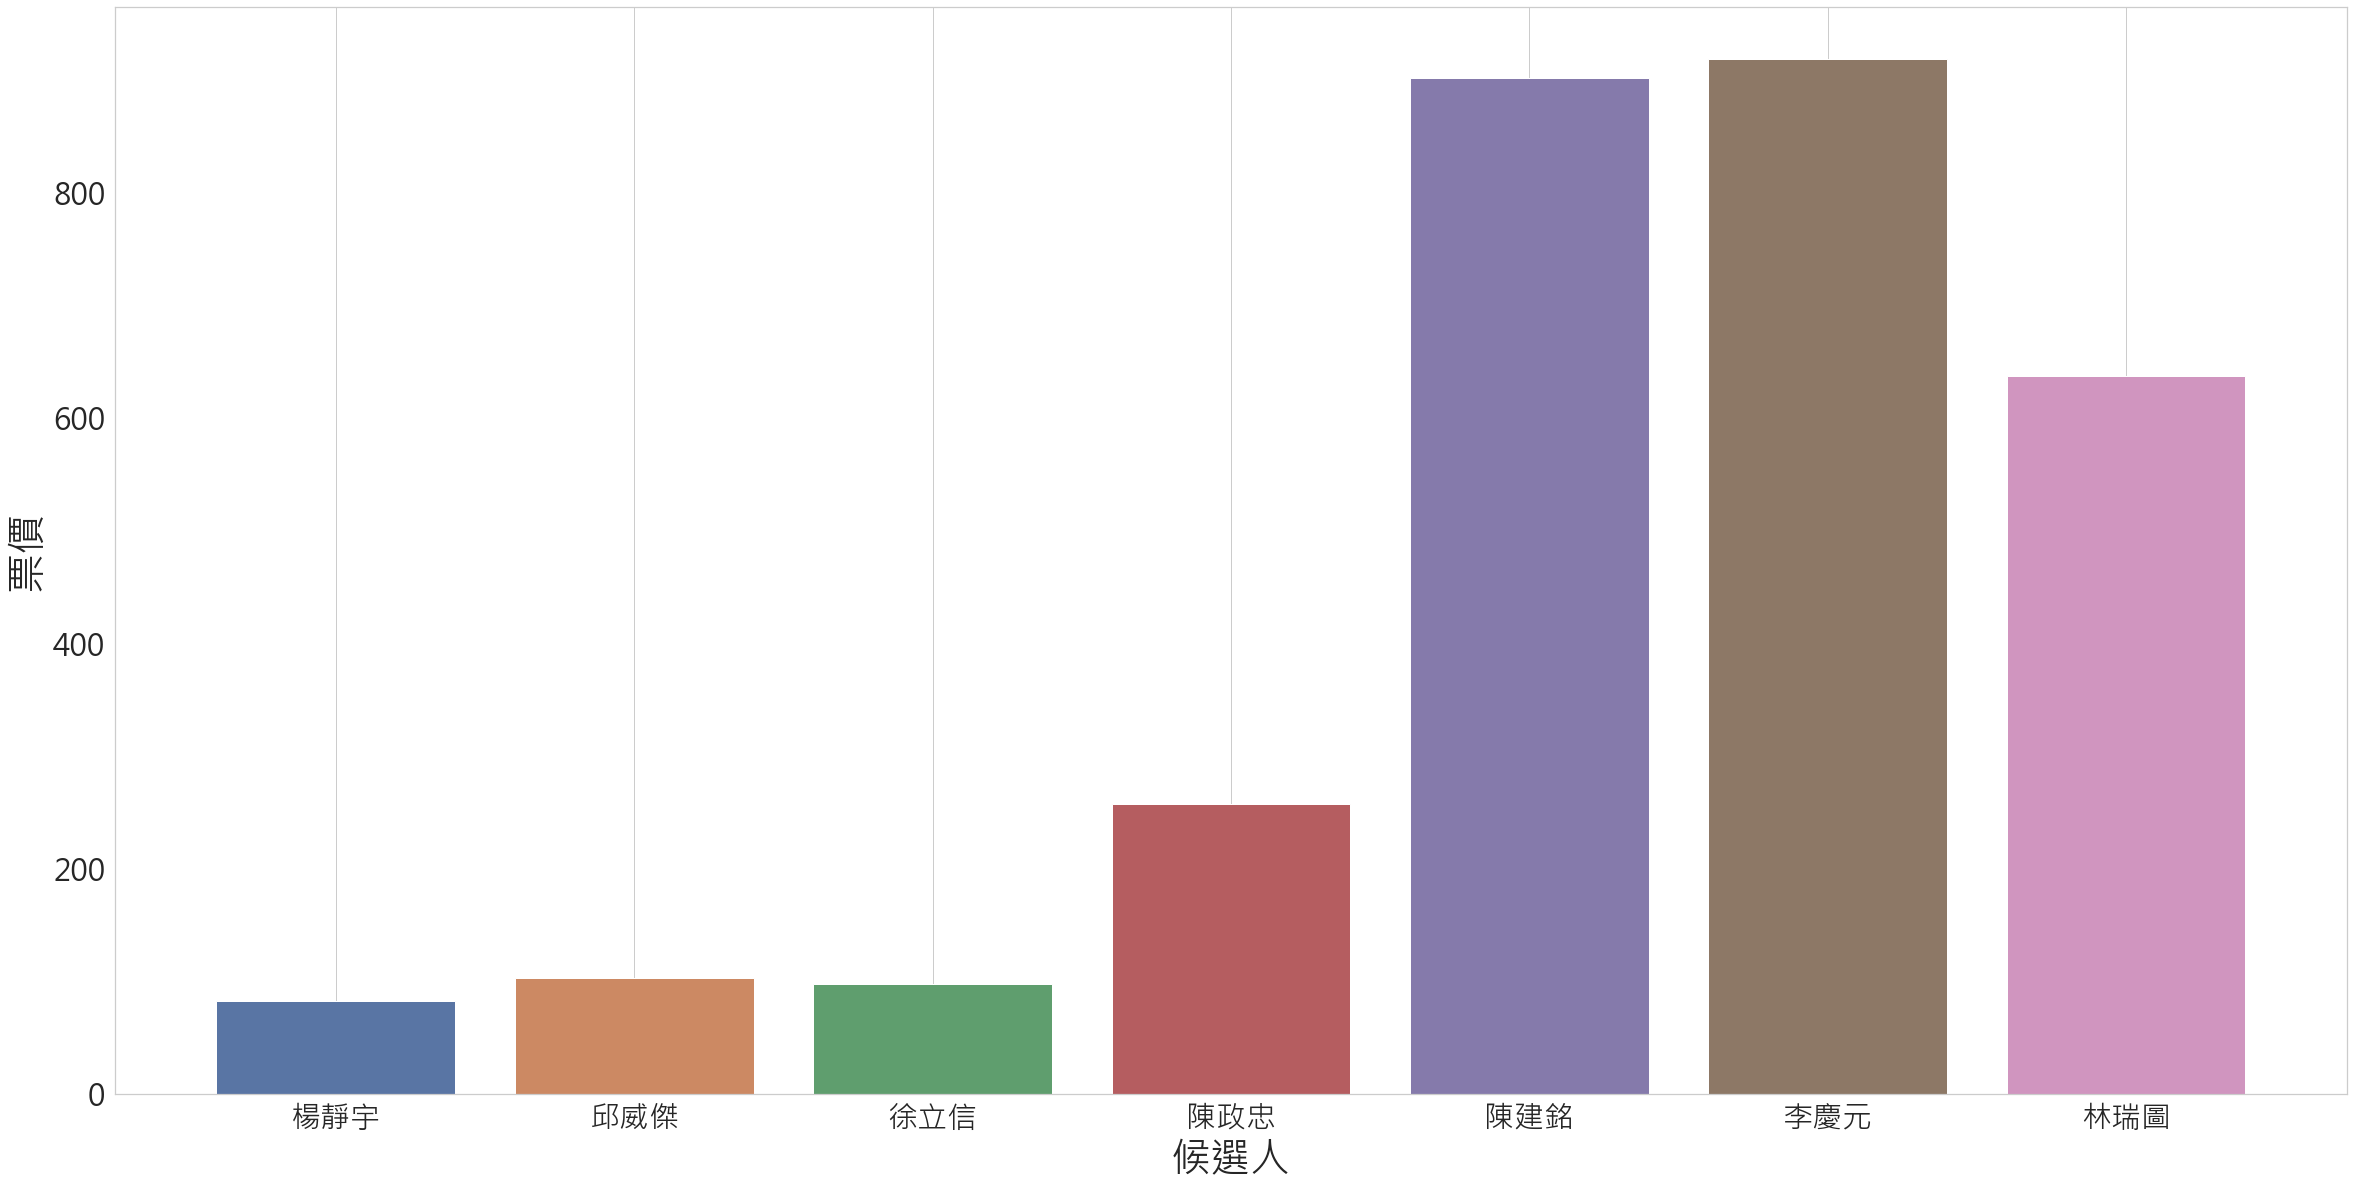

In [88]:
dict_ = {'陳建銘':13166,
         '林瑞圖':19427,
         '陳政忠':17613,
         '楊靜宇':14295,
         '徐立信':24287,
         '邱威傑':11786,
         '李慶元':13097,}

all_income['票數'] = all_income['項目名稱'].map(dict_)
all_income['票價'] = all_income['收入金額']/all_income['票數']

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="項目名稱", y="票價", data=all_income[['票價','項目名稱']], estimator=sum)
label = ax.get_xticklabels()
#plt.setp(label, rotation=45, ha="right",rotation_mode="anchor")
plt.ylabel('票價',fontsize=40)
plt.xlabel('候選人',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

呱吉表示只選一屆的原因：「如果我心裡想著要連任的話，就會跟區內的里長以及各種勢力如建商妥協，只為了獲得下屆連任勝選的資源。」

### 2.有人說票都是來自粉絲，是真的嗎?

呱吉曾經說過他的粉絲年齡層為20~40歲<br>
因此我們希望以這樣的人口比例以及呱吉的頻道粉絲數來推估到底有多少呱吉的粉絲戶籍在選區

1. 先來看看信義松山區佔台灣人口的多少百分比
2. 再來是呱吉的TA年齡層佔了多少百分比
3. 推估有多少人是呱吉的粉絲
4. 假設這些粉絲都會投給呱吉

#### 1. 先來看看信義松山區佔台灣人口的多少百分比

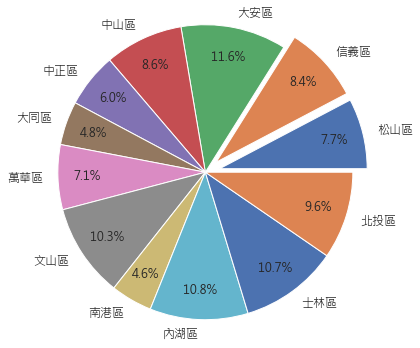

In [519]:
taipei_pop = pd.read_excel('m0s8-10711.xls', sheet_name='臺北市', skiprows=1)
taipei_pop1 = taipei_pop[['區  域  別', '人        口        數']][1:]
taipei_pop1['人        口        數'] = taipei_pop1['人        口        數'].astype('int')
taipei_pop1['比例'] = taipei_pop1['人        口        數']/taipei_pop1['人        口        數'][1]

plt.figure(figsize=(6,6))
separated = (.1,.1,0,0,0,0,0,0,0,0,0,0)
plt.pie(taipei_pop1['比例'][1:], 
       labels=taipei_pop1['區  域  別'][1:],
       autopct = "%1.1f%%",
       explode=separated,
       pctdistance = 0.8,
       textprops = {"fontsize" : 12})
plt.axis('equal')
plt.show()

#### 2. 再來是呱吉的TA年齡層佔了多少百分比

台北市青壯年人口比例：26.71%


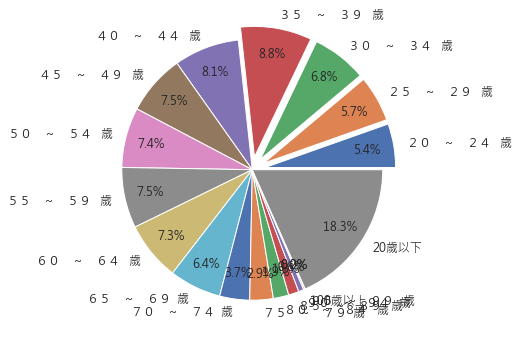

In [533]:
youth = taiwan_age.loc[7][['２０　～　２４   歲', '２５　～　２９   歲',
                   '３０　～　３４   歲', '３５　～　３９   歲']].sum()/taiwan_age.loc[7]['總　計']
print('台北市青壯年人口比例：{:.2f}%'.format(youth*100))

taiwan_age = pd.read_excel('m0s7-10711.xls', skiprows=2)
age = taiwan_age.loc[7][['２０　～　２４   歲', '２５　～　２９   歲',
                   '３０　～　３４   歲', '３５　～　３９   歲',
                   '４０　～　４４   歲', '４５　～　４９   歲',
                   '５０　～　５４   歲', '５５　～　５９   歲',
                   '６０　～　６４   歲', '６５　～　６９  歲',
                   '７０　～　７４  歲', '７５　～　７９  歲',
                   '８０　～　８４   歲', '８５　～　８９   歲',
                   '９０　～　９４   歲', '９５　～　９９   歲',
                   '100歲以上']]
age['20歲以下'] = taiwan_age.loc[7]['總　計'] -age.sum()
plt.figure(figsize=(6,6))
separated = (.1,.1,.1,.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
plt.pie(age,
       labels=age.index,
       autopct = "%1.1f%%",
       explode=separated,
       pctdistance = 0.8,
       textprops = {"fontsize" : 12})
plt.show()

#### 3. 推估有多少人是呱吉的粉絲

以(松山信義青壯年人口數/台灣總人口數)*呱吉訂閱粉絲數 = 265594

In [572]:
vote = sum(taipei_pop1['人        口        數'][2:4])*(youth)*(265594)/taiwan_age['總　計'][1]
print('推估在呱吉選區的粉絲人數：{:.0f}'.format(vote))

推估在呱吉選區的粉絲人數：1602


#### 4. 假設這些粉絲都會投給呱吉

In [684]:
print('粉絲投票比例：{:.2f}%'.format((vote/11786)*100))
print('也才佔不到15%')

粉絲投票比例：13.59%
也才佔不到15%


#### 我們可以推估得知以呱吉的得票數來說，肯定有超過一半以上的票來自其他非粉絲選民，因此我們接下來就來看看呱吉到底為了松山區的選民做了哪些事情

### 3.競選政見有做到嗎？網路輿情分析，看看呱吉被大家討論的事件都是什麼

以PTT,Youtube作為資料來源，分析大家在討論有關呱吉的事件是什麼，以及討論聲量的變化量

1. PTT
    1. 預處理
    2. Overview
        1. 總體Po文數
        2. 標題及內文提及量
        3. 評論提及量
    3. 以總體內文作為分群對象
        1. 分群預處理(Embedding-base：BERT)
        2. 分群預處理(count-base：association rule)
        3. K-Means分群
    4. 找與分群中心點相關性大於0.99文章來分析內容
    5. 以文字雲顯示四個群體的討論內容
    6. 呱吉事件分析
        1. 公共住宅問題
        2. 大巨蛋議題
        3. 嗆別人吸白粉
        4. 大港開唱事件<br>
<br>
2. Youtube
    1. 預處理
    2. Overview
    3. 情緒分析
    4. 文字雲

### 1. PTT

#### A. 預處理

In [2]:
with open('HatePolitics.json', 'r', encoding='utf-8') as f:
    data = [json.loads(d.strip('\n')) for d in f.readlines()]
    
df = pd.DataFrame(data)
df.head(3)

作者                                                 內文  \
0  Knuckles (站長 那克斯)            [\n主要用來轉錄PTT政黑板的文章, \n也用來做為專門討論政治話題的看板]   
1   ohmama100 (星星之火)  [ 轉寄自 ptt.cc 更新時間: 2018-11-18 15:41:50 , \n動後，...   
2     zkow (逍遙山水憶秋年)  [ 轉寄自 ptt.cc 更新時間: 2018-11-18 15:42:00 , \n剛看到...   

                         時間                       標題  \
0  2018-11-18 Sun. 15:04:35          [公告] 政治黑特板 開板成功   
1  Sun Nov 18 01:17:03 2018    [討論] 11/18北門, 台中柯粉挺阿北   
2  Sun Nov 18 01:41:40 2018  [討論]金馬獎後續延燒起來了，中國藝人紛紛表態   

                                                評論作者  \
0                                                 []   
1  [Roderickey, London2006, shefu120, London2006,...   
2  [andy199113, dakkk, pigshow, namfish, andy1991...   

                                                評論內容  \
0                                                 []   
1  [: 444444444444444444444444, : 台中人+1，明天北門見, : ...   
2  [: 沒差 台北搞政治 高雄拼經濟 其邁去哭吧, : 不表態就沒電影演了, : 不爽不要來參...   

                                                評論模式  
0                                                 []  
1  [推, →, 推, →, 推, 推, →, 推, →, →, 推, →, 推, 推, 推, ...  
2  [推, 推, 推, 推, →, 推, 推, →, 推, →, 推, →, 推, →, 推, ...

In [3]:
#Preprocessing
df['type'] = df['標題'].apply(lambda x : x[0:4])
df = df[df['type'] != '[公告]']

#刪除日期有問題的
df = df[df['時間'].apply(lambda x:x[0:3]) != '201']
df = df[df['時間'].apply(lambda x:x[0:3]) != '8/1']

#取得YMD
df['Y'] = df['時間'].apply(lambda x:x[20:24])
df = df[(df['Y'] == '2019') | (df['Y'] == '2018')]
df['M'] = df['時間'].apply(lambda x:x[4:7])
df['D'] = df['時間'].apply(lambda x:x[8:10])
df['M'] = df['M'].map({'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'})
df['YM'] = df['Y'].astype(str)+df['M'].astype(str)
df.reset_index(drop=True,inplace=True)
df.head(3)

作者                                                 內文  \
0   ohmama100 (星星之火)  [ 轉寄自 ptt.cc 更新時間: 2018-11-18 15:41:50 , \n動後，...   
1     zkow (逍遙山水憶秋年)  [ 轉寄自 ptt.cc 更新時間: 2018-11-18 15:42:00 , \n剛看到...   
2  sister4949 (放飛自我)  [ 轉寄自 ptt.cc 更新時間: 2018-11-18 15:42:01 , \n這次的...   

                         時間                       標題  \
0  Sun Nov 18 01:17:03 2018    [討論] 11/18北門, 台中柯粉挺阿北   
1  Sun Nov 18 01:41:40 2018  [討論]金馬獎後續延燒起來了，中國藝人紛紛表態   
2  Sun Nov 18 02:14:34 2018             [黑特] 柯p真的危險了   

                                                評論作者  \
0  [Roderickey, London2006, shefu120, London2006,...   
1  [andy199113, dakkk, pigshow, namfish, andy1991...   
2  [Roderickey, hayuyang, soniccsie, hayuyang, a5...   

                                                評論內容  \
0  [: 444444444444444444444444, : 台中人+1，明天北門見, : ...   
1  [: 沒差 台北搞政治 高雄拼經濟 其邁去哭吧, : 不表態就沒電影演了, : 不爽不要來參...   
2  [: 44444444444444444444, : 笑了 中國的激進派 把台灣的獨派拉上檯...   

                                                評論模式  type     Y   M   D  \
0  [推, →, 推, →, 推, 推, →, 推, →, →, 推, →, 推, 推, 推, ...  [討論]  2018  11  18   
1  [推, 推, 推, 推, →, 推, 推, →, 推, →, 推, →, 推, →, 推, ...  [討論]  2018  11  18   
2  [推, 推, 推, →, 推, →, →, 推, 推, 推, 推, →, 推, →, 推, ...  [黑特]  2018  11  18   

       YM  
0  201811  
1  201811  
2  201811

In [4]:
df['標題'] = df['標題'].apply(lambda x : "".join(x[1:]).replace('\n','').replace('\xa0','').replace('\r', '').replace(' ', ''))
df['內文'] = df['內文'].apply(lambda x : "".join(x[1:]).replace('\n','').replace('\xa0','').replace('\r', '').replace(' ', ''))

In [5]:
jieba.add_word('呱吉')
jieba.add_word('邱議員')
jieba.add_word('邱威傑')
jieba.add_word('柯文哲')
jieba.add_word('阿伯')
jieba.add_word('柯市長')
jieba.add_word('高嘉瑜')
jieba.add_word('大巨蛋')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/rk/fg780g753sd952335gvhq0bm0000gn/T/jieba.cache
Loading model cost 0.674 seconds.
Prefix dict has been built succesfully.


#### B. Over View

#### a. 總體Po文數

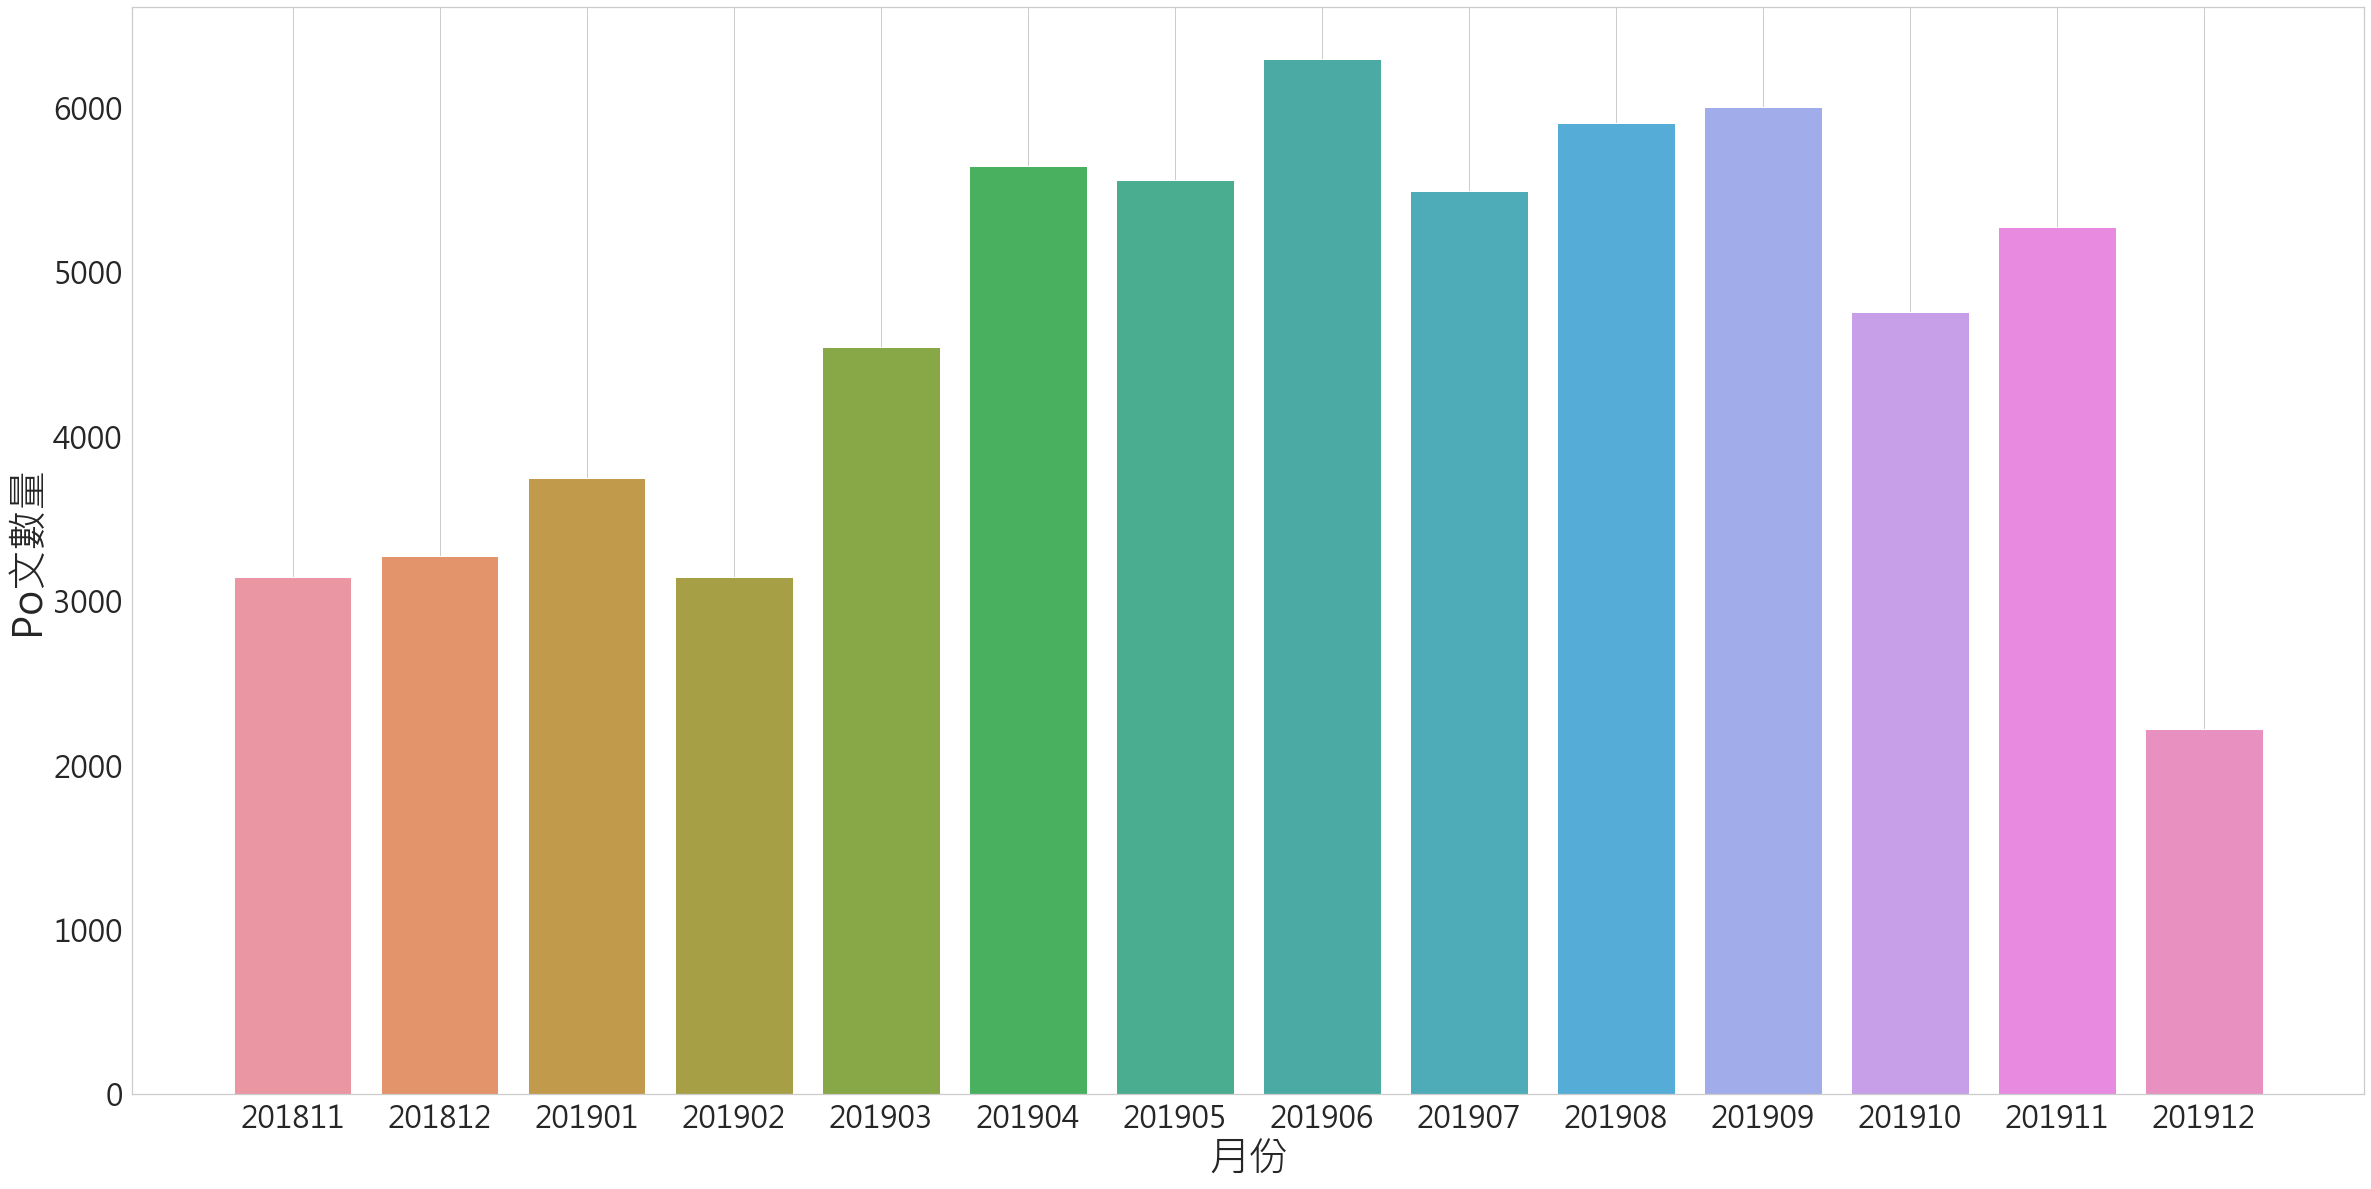

In [6]:
amount = df[['YM','Y']].groupby(by='YM').count().reset_index().sort_values(by='YM')[5:]

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=amount[['YM','Y']], estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('Po文數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### b. 標題及內文提及量

/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2880x1440 with 0 Axes>

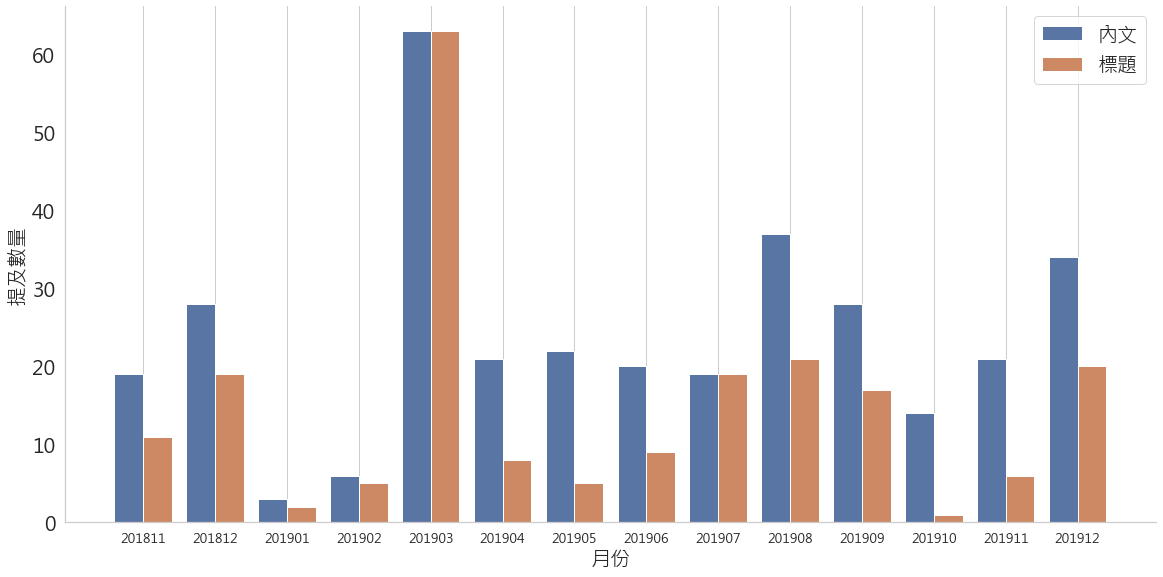

In [7]:
frog = ['呱吉','邱威傑','邱議員','威傑']
#標題數
count = [True  if ('呱吉' in i or '邱威傑' in i or '威傑' in i or '邱議員' in i) else False for i in df['標題'] ]
df_frog_t = df[count].reset_index(drop=True)
amount_t = df_frog_t[['YM','Y']].groupby(by='YM').count().reset_index().sort_values(by='YM')

#內文數
count = [True  if ('呱吉' in i or '邱威傑' in i or '威傑' in i or '邱議員' in i) else False for i in df['內文'] ]
df_frog_c = df[count].reset_index(drop=True)
amount_c = df_frog_c[['YM','Y']].groupby(by='YM').count().reset_index().sort_values(by='YM')

ct = pd.concat([df_frog_t[['YM']],df_frog_c[['YM']]],keys=['標題','內文']).reset_index().groupby(['level_0','YM']).count().reset_index()
plt.figure(figsize=(40, 20))
sns.factorplot(x='YM', y='level_1', hue='level_0', data=ct, kind='bar',size=8, aspect=2,legend=False)
plt.ylabel('提及數量',fontsize=20)
plt.xlabel('月份',fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=20)
plt.legend(fontsize=20,loc='upper right')
plt.grid()
_ = plt.plot()

#### c. 評論提及量

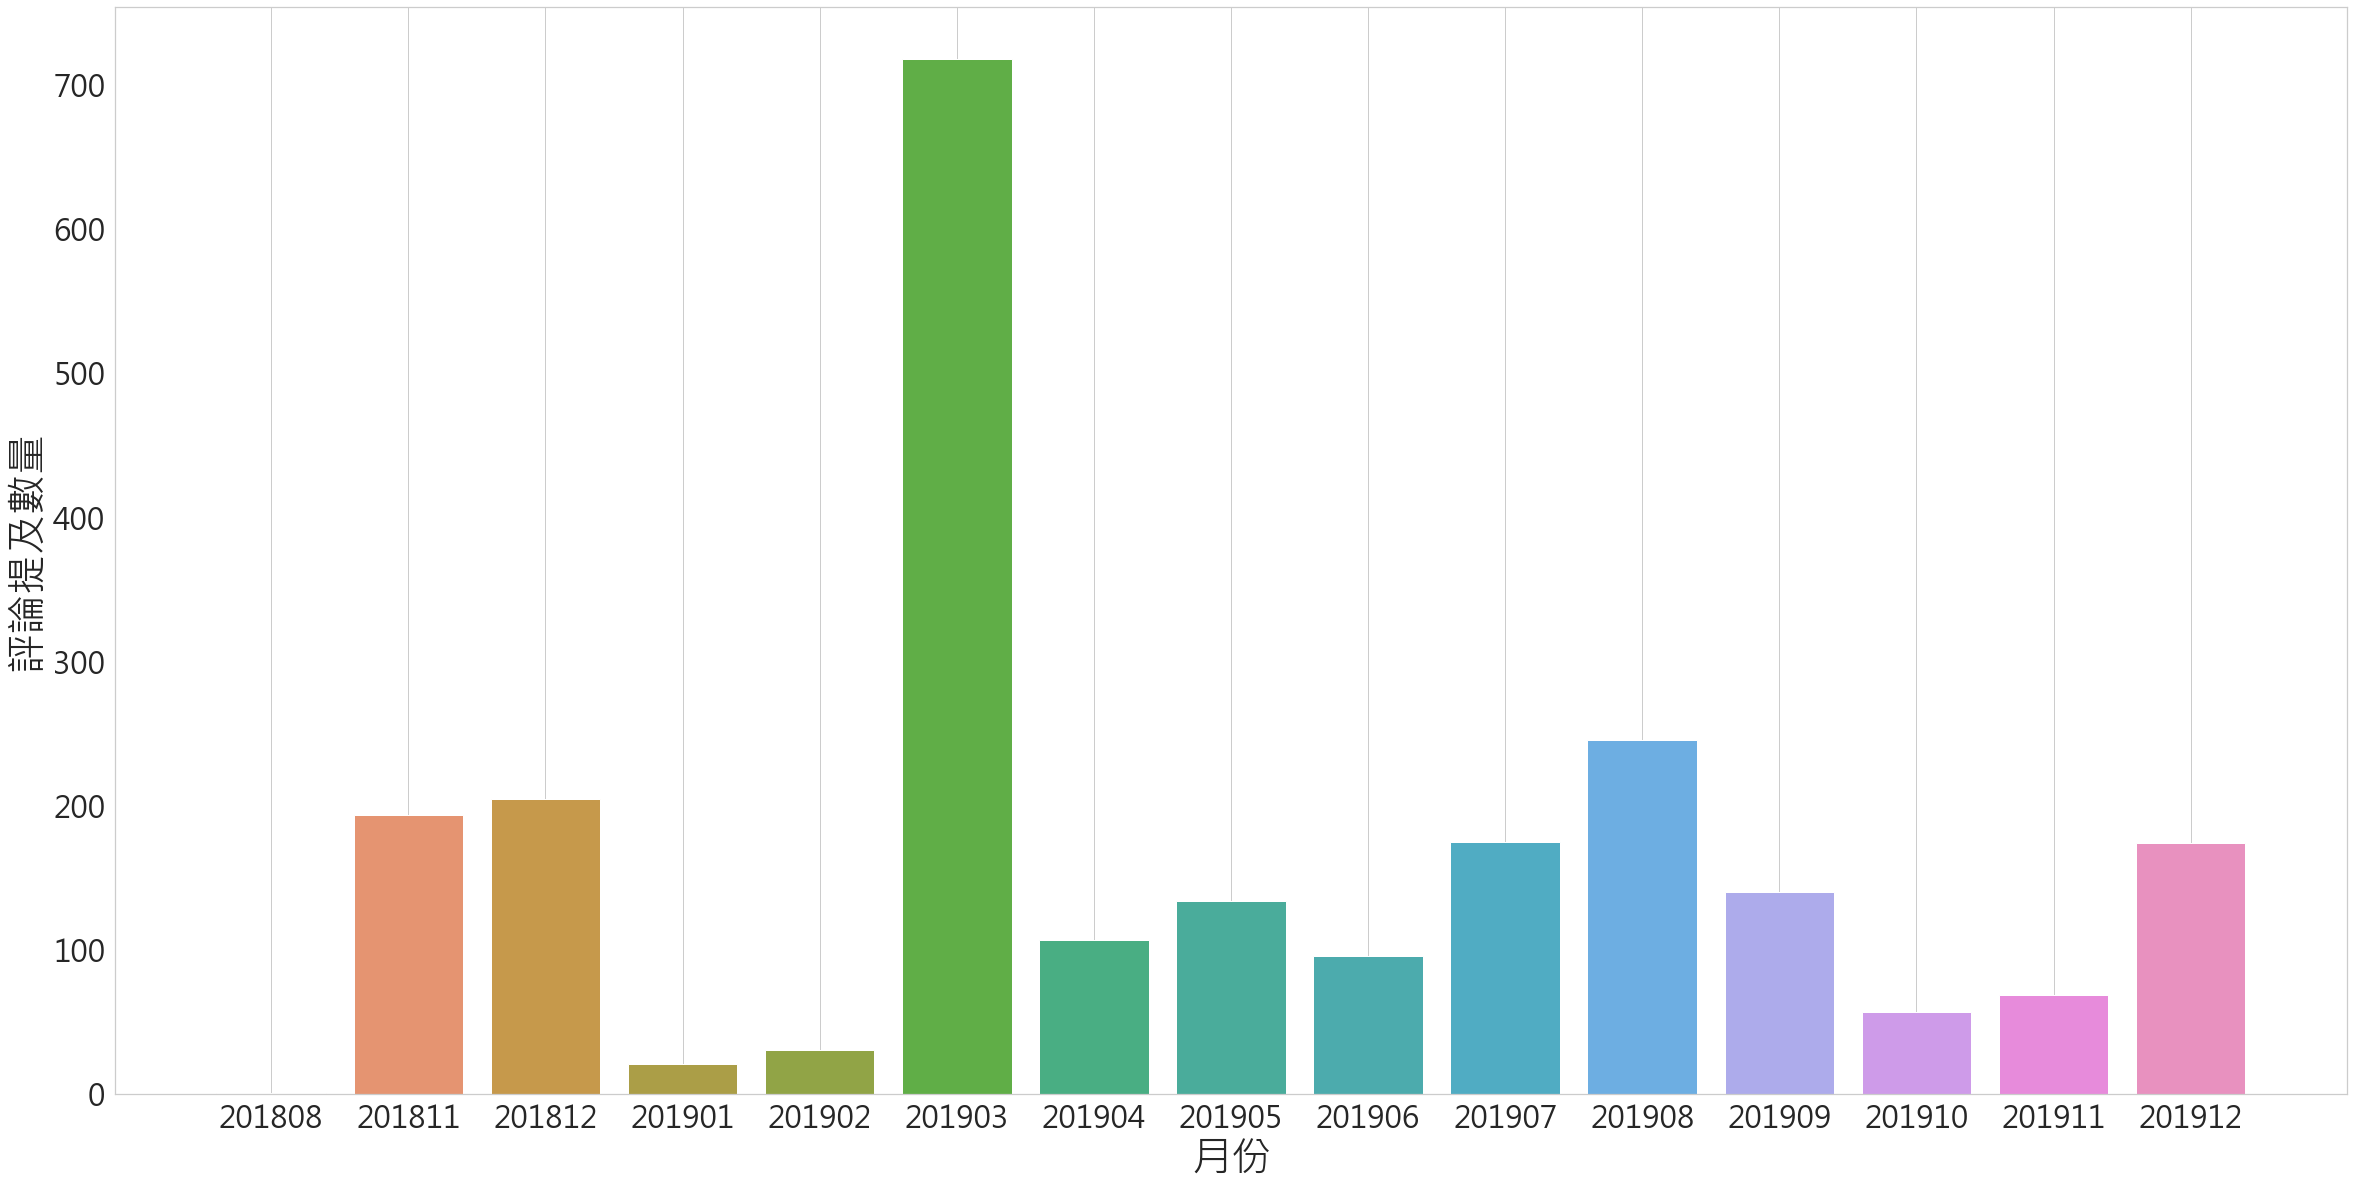

In [8]:
#評論數
times=[]
for i in tqdm_notebook(range(len(df))):
    for j in df['評論內容'][i]:
        for k in frog:
            if k in j:
                times.append(df['YM'][i])
amount_co = pd.DataFrame({'YM':times}).reset_index().groupby(by='YM').count().reset_index().rename(columns={'index':'Y'})

plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=amount_co, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('評論提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### C. 以總體內文作為分群對象

我們希望能根據內文將Po文分群，並且分析其中的事件，因此這邊採用兩種方法做特徵的提取：<br>
###### 1)Embedding-base：BERT<br>
我們會將提及呱吉的上下文做BERT向量轉換，並將提取出來的高維向量以PCA,TSNE兩種方法轉換為2維以利視覺化<br>
###### 2)Count-base：association-rule<br>
我們會將文字作結巴斷詞後進行關聯規則計算之後畫出文本權重圖譜，試著看出文本間的關聯<br>

#### a. Embedding-base：BERT分群 

In [9]:
#將提及文字都標準化成呱吉
x = list(df_frog_c['內文'])
for i in range(len(x)):
    x[i] = x[i].replace('邱威傑','呱吉')
    x[i] = x[i].replace('威傑','呱吉')
    x[i] = x[i].replace('邱議員','呱吉')

In [10]:
#刪除太長的文章
for i in reversed(range(len(x))):
    if len(x[i]) > 510:
        del x[i]

In [281]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-chinese', do_basic_tokenize=True)
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-chinese')
model.eval() 

def preprocess(sent, masked_indices=None): 
    text = "[CLS]" + sent + "[SEP]"
    tokenized_text = tokenizer.tokenize(text)
    masked_tokens = []
    if masked_indices is not None:
        for masked_index in masked_indices:
            print("tokenized_text before masking: {}".format(tokenized_text))
            masked_tokens.append(tokenized_text[masked_index])
            tokenized_text[masked_index] = '[MASK]'
            print("tokenized_text after masking: {}".format(tokenized_text))

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [0] * len(tokenized_text)
    segments_tensors = torch.tensor([segments_ids])
    if masked_indices is not None:
        return masked_tokens, tokens_tensor, segments_tensors
    else:
        return tokens_tensor, segments_tensors

sents = x
error=[]
with torch.no_grad(): 
    embeddings = [] 
    keyword_index = tokenizer.convert_tokens_to_ids(["呱"])[0]
    j=-1
    for sent in tqdm_notebook(sents): 
        j+=1
        try:
            tokens_tensor, segments_tensors = preprocess(sent) 
            encoded_layers, _ = model(tokens_tensor, segments_tensors)
            keyword_position = torch.nonzero(tokens_tensor[0] == keyword_index)[0][0] 
            embeddings.append(encoded_layers[0, keyword_position]) 
        except:
            print(j)
            error.append(j)

Using cache found in /Users/howardchung/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /Users/howardchung/.cache/torch/hub/huggingface_pytorch-transformers_master


In [398]:
new_embeddings = embeddings

##### 以PCA降維

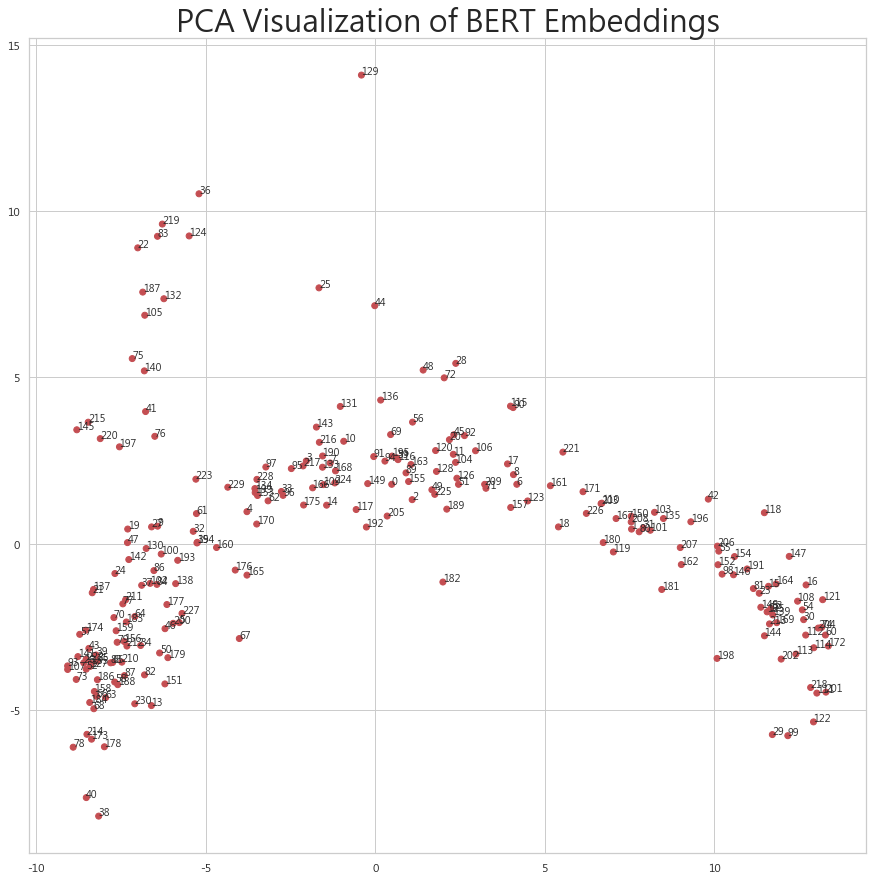

In [303]:
#PCA
embeddings = torch.stack(embeddings, dim=0) 

fig, axes = plt.subplots(figsize=(15, 15))

pca=PCA(n_components=3) 
pca.fit(embeddings) 
pca_embeddings = pca.transform(embeddings)

colors = ['r'] * len(sents)

axes.scatter(pca_embeddings[:,0], pca_embeddings[:,1], c=colors)

axes.set_title("PCA Visualization of BERT Embeddings", fontsize=30)

for i, txt in enumerate(sents):
    axes.annotate(i, (pca_embeddings[i,0], pca_embeddings[i,1]), fontsize=10)

##### 以TSNE降維

Text(0.5, 1.0, 'TSNE Visualization of BERT Embeddings')

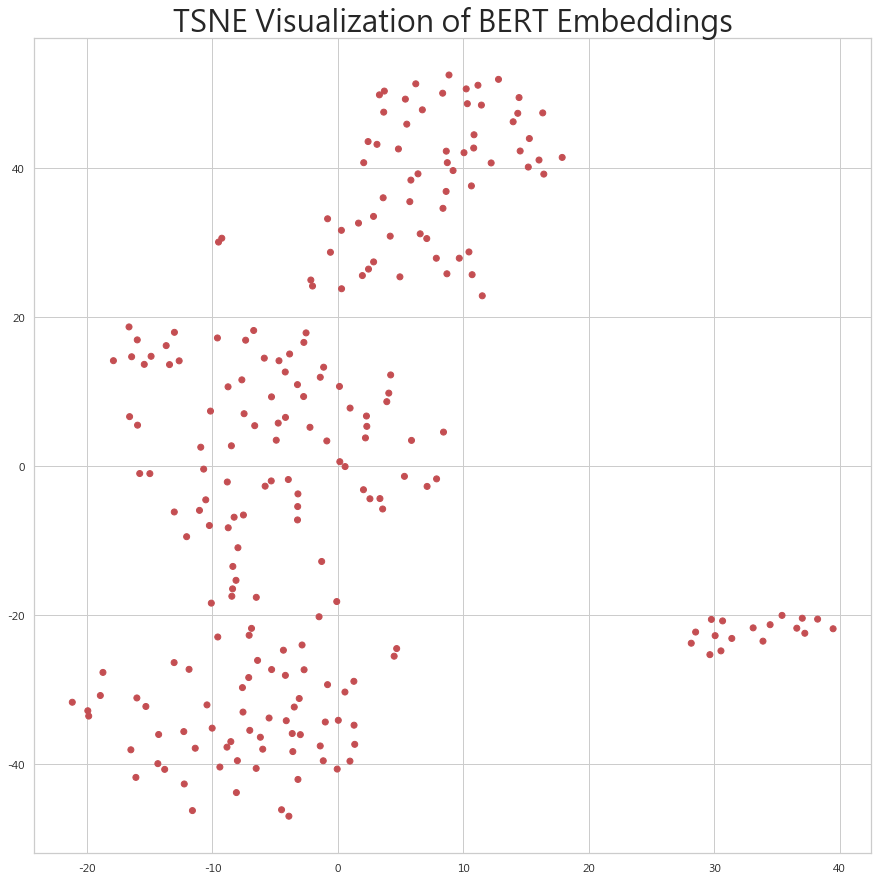

In [387]:
tsne_embeddings = TSNE(n_components=2, perplexity=10.0).fit_transform(embeddings.numpy())
fig, axes = plt.subplots(figsize=(15, 15))
colors = ['r'] * len(sents)

axes.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c=colors)

axes.set_title("TSNE Visualization of BERT Embeddings", fontsize=30)

#### b. 以關聯規則提取特徵

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


(-1.101588900456236,
 1.1074969484646877,
 -1.1054990260688573,
 1.0907311588062434)

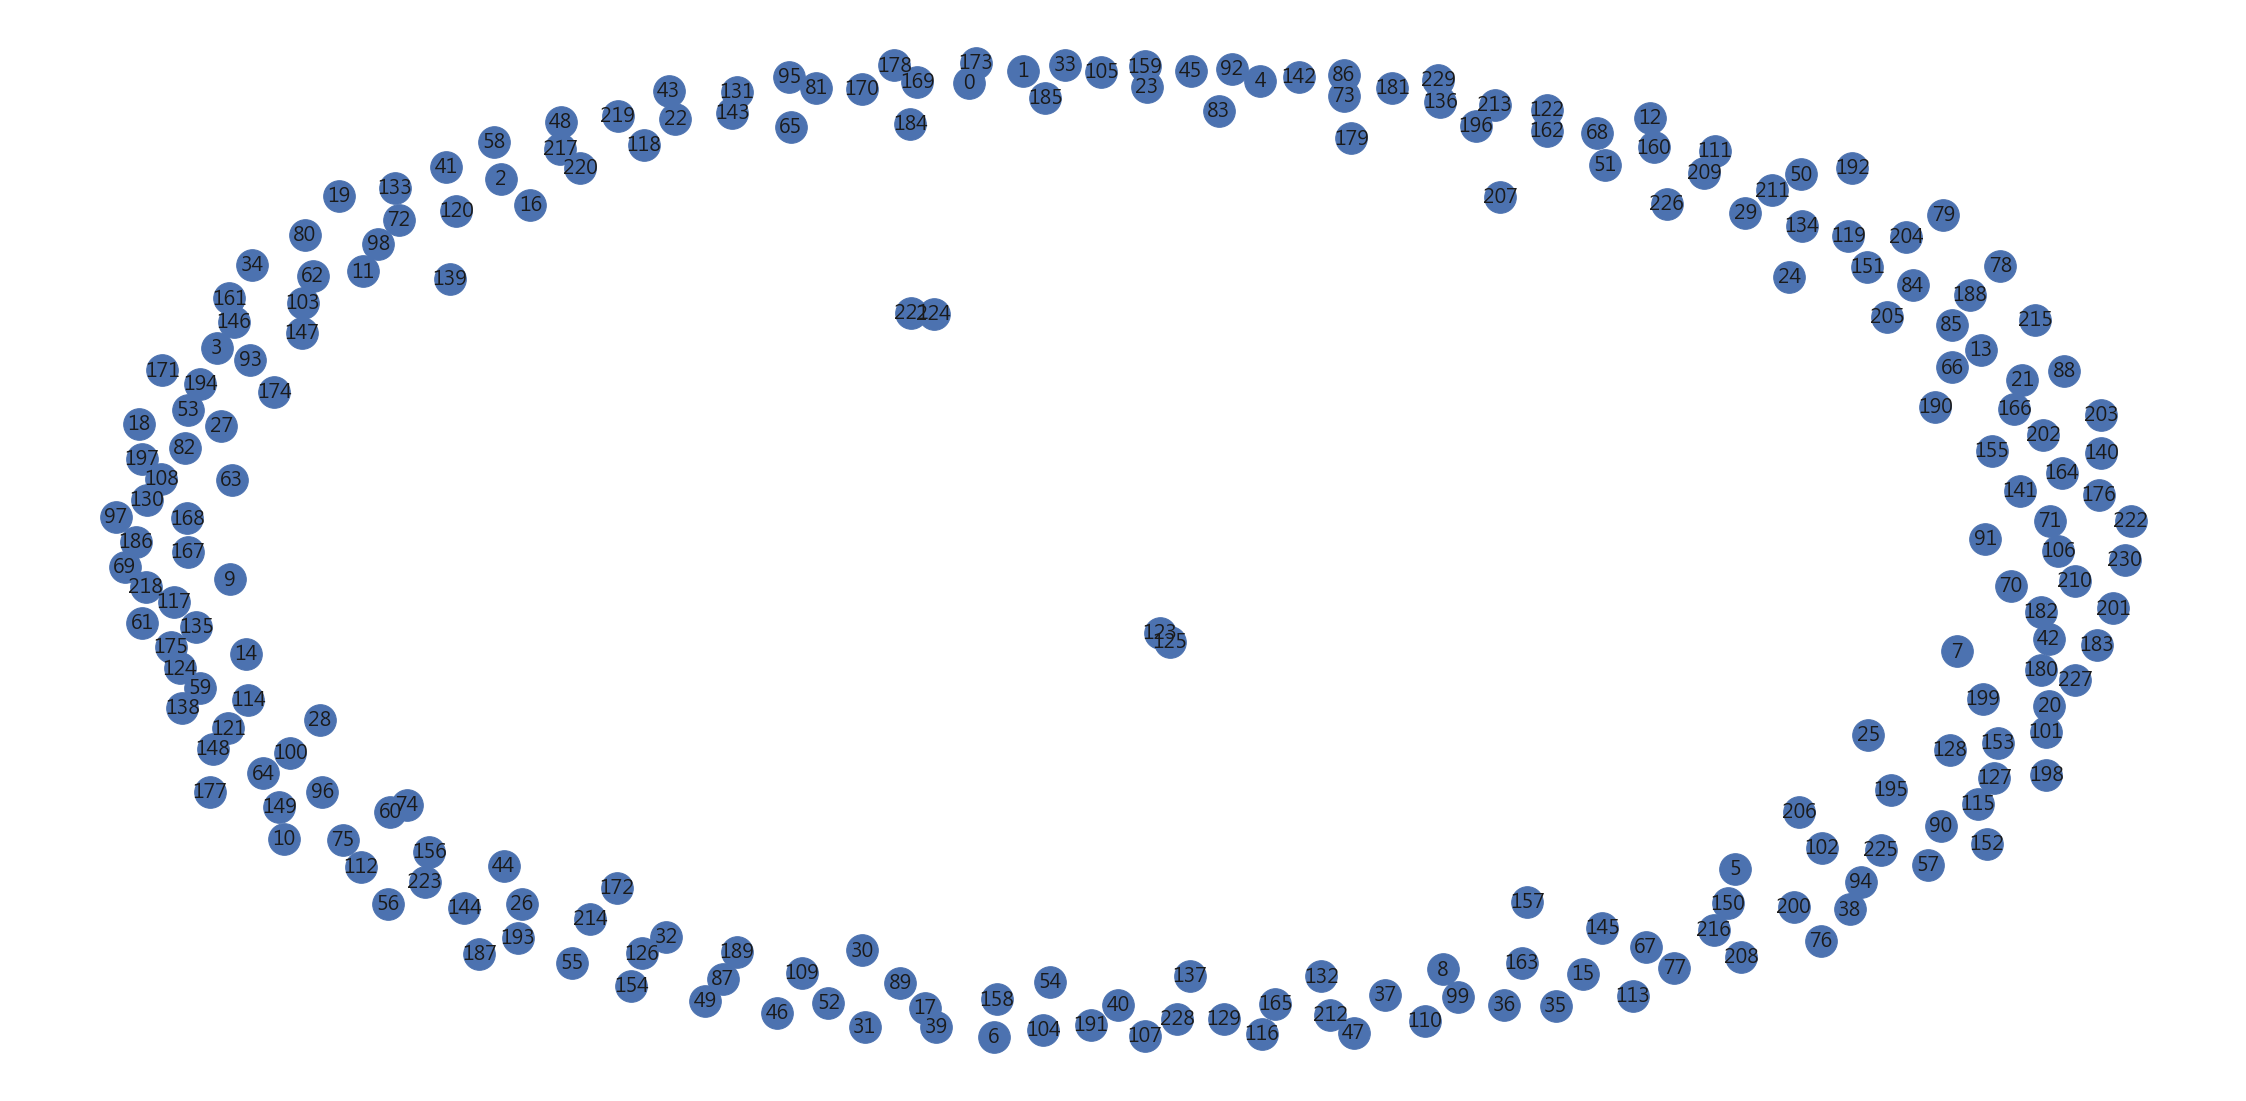

In [358]:
doc_names = range(len(x))
dwc = {key: [word for word in jieba.cut(text, cut_all=False)] for (key, text) in zip(doc_names, x)}
doc_word_frequency = {key: {i:Counter(doc)[i] for i in Counter(doc)} for key, doc in dwc.items()}
d = {}
for i in range(len(doc_word_frequency)):
    d[i] = list(doc_word_frequency[i].keys())

te = TransactionEncoder()
te_ary = te.fit(d.values()).transform(d.values())
df = pd.DataFrame(te_ary, columns=te.columns_)
graph = df.T
graph.columns = d.keys()

minsup = 0.01
result = apriori(graph, min_support = minsup)
rules = association_rules(result, metric="confidence", min_threshold=0.7)
rules = association_rules(result, metric="lift", min_threshold=1.2)
rules["antecedant_len"] = rules["antecedents"].apply(lambda x: len(x))

G = nx.DiGraph()
for i in range(len(d.keys())):
    G.add_node(i)
for i in range(len(rules['antecedents'])):
    currentFrom = list(rules['antecedents'][i])
    currentTo = list(rules['consequents'][i])
    for j in range(len(currentFrom)):
        G.add_edge(currentFrom[j], currentTo[0])
        
nodeList = list(range(231))

plt.figure(figsize=(40,20))

# positions for all nodes
pos = nx.fruchterman_reingold_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, nodelist=nodeList, node_color="b", node_size=1000)
nx.draw_networkx_edges(G, pos, width=6)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')

我們可以從上述結果發現，關聯規則幾乎無法找到相關性，原因在於關聯規則計算次數須為完全一樣的詞才能算一次，而在BERT當中只要有相似字即可代表有相關性，因此BERT可以將內文的關聯顯示出來，並且再降維時，TSNE又比PCA更好的將群分開，因此我們選擇用TSNE降維完的Embedding做接下來的處理

#### c.  K-Means 分群

In [388]:
#用KMeans分成四群
X = tsne_embeddings
km = KMeans(n_clusters=4,
                    init='random',
                    max_iter=300,
                    tol=1e-04,
                    random_state=0)

y_km = km.fit_predict(X)

可以看到以K-Means分群可以把近似點分再一起，而我們觀察視覺化圖發現大概可以分為四群因此數量設為4

Text(0.5, 1.0, 'KMeans Visualization of BERT Embeddings')

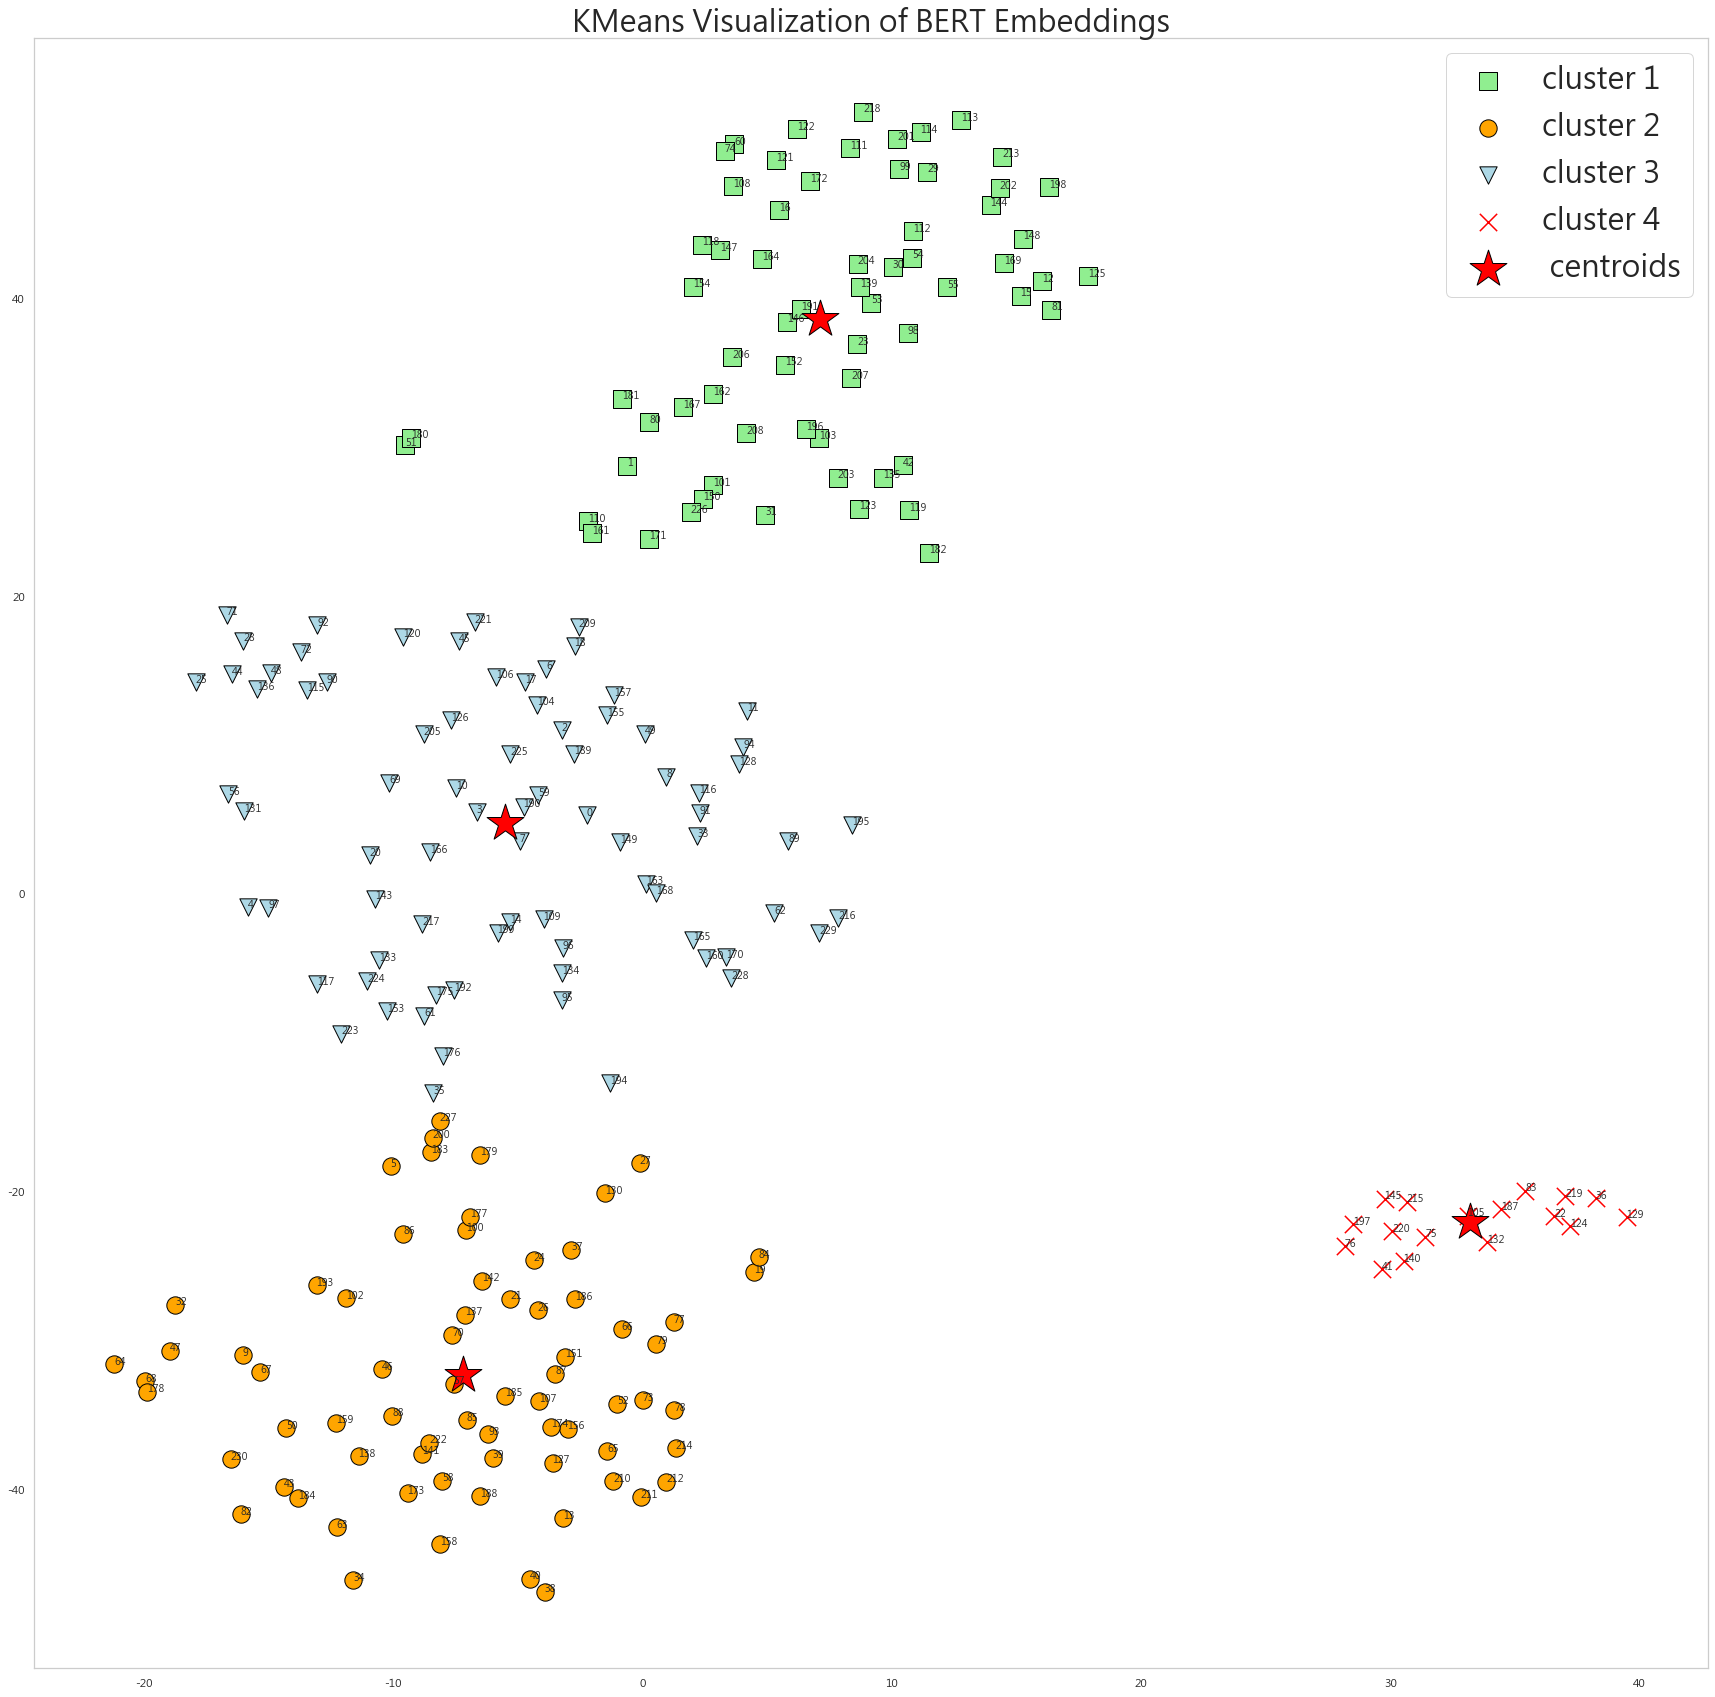

In [389]:
plt.subplots(figsize=(30, 30))
plt.scatter(X[y_km == 0,0],
                X[y_km==0,1],
                s=300, c='lightgreen',
                marker='s', edgecolor='black',
                label='cluster 1')
plt.scatter(X[y_km == 1, 0],
                X[y_km == 1, 1],
                s=300, c='orange',
                marker='o', edgecolor='black',
                label='cluster 2')
plt.scatter(X[y_km == 2,0],
                X[y_km == 2, 1],
                s=300, c='lightblue',
                marker='v', edgecolor='black',
                label='cluster 3')
plt.scatter(X[y_km == 3,0],
                X[y_km == 3, 1],
                s=300, c='red',
                marker='x', edgecolor='black',
                label='cluster 4')
plt.scatter(km.cluster_centers_[:,0],
                km.cluster_centers_[:, 1],
                s=1500, marker='*',
                c='red', edgecolor='black',
                label=' centroids')
plt.legend (scatterpoints=1,fontsize=30)
for i, txt in enumerate(sents):
    plt.annotate(i, (tsne_embeddings[i,0], tsne_embeddings[i,1]), fontsize=10)
plt.grid()
plt.title("KMeans Visualization of BERT Embeddings", fontsize=30)

呱吉為市議員，而工作就是監督市長，因此我們統計內文中同時有提到柯市長的比例，發現第四群的討論倒市長的比例明顯比其他三者低，也有可能是群集離大群體較遠的原因之一

(-1.1139101084494607, 1.100662386116641, -1.129888740042812, 1.121986532865689)

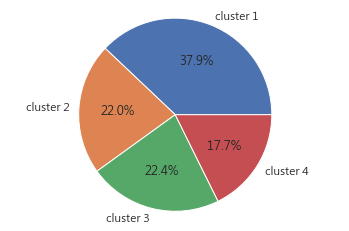

In [505]:
cluster = pd.DataFrame({'內文':x,'類別':y_km+1})
cluster1 = cluster[cluster['類別'] == 1]
cluster2 = cluster[cluster['類別'] == 2]
cluster3 = cluster[cluster['類別'] == 3]
cluster4 = cluster[cluster['類別'] == 4]

count1 = sum([True  if ('柯' in i or '阿伯' in i or '市長' in i ) else False for i in cluster1['內文'] ])/len(cluster1['內文'])
count2 = sum([True  if ('柯' in i or '阿伯' in i or '市長' in i ) else False for i in cluster2['內文'] ])/len(cluster2['內文'])
count3 = sum([True  if ('柯' in i or '阿伯' in i or '市長' in i ) else False for i in cluster3['內文'] ])/len(cluster3['內文'])
count4 = sum([True  if ('柯' in i or '阿伯' in i or '市長' in i ) else False for i in cluster4['內文'] ])/len(cluster4['內文'])
plt.pie([count1,count2,count3,count4] , labels = ['cluster 1','cluster 2','cluster 3','cluster 4'],autopct='%1.1f%%')
plt.axis('equal')

#### D. 找與分群中心點相關性大於0.99文章來分析內容

以向量的Cosine-similarity計算兩者相似度

In [802]:
vec = pd.DataFrame({'id':list(range(len(X))),'vector1':X[:,0],'vector2':X[:,1]})
corr = [(i,j,dot([vec['vector1'][i],vec['vector2'][i]], [vec['vector1'][j],vec['vector2'][j]])/(norm([vec['vector1'][i],vec['vector2'][i]])*norm([vec['vector1'][j],vec['vector2'][j]]))) for i in range(len(vec)) for j in range(len(vec))]
center = [191,57,7,105]
center_corr=[(j,k,l) for i in center for j,k,l in corr if j == i ]
c1 = [j for i,j,k in center_corr[:231] if k >0.99 and j != i]
c2 = [j for i,j,k in center_corr[231:462] if k >0.99 and j != i]
c3 = [j for i,j,k in center_corr[462:693] if k >0.99 and j != i]
c4 = [j for i,j,k in center_corr[693:] if k >0.99 and j != i]

In [803]:
c1 = ''.join(list(np.array(cluster['內文'])[c1]))
c2 = ''.join(list(np.array(cluster['內文'])[c2]))
c3 = ''.join(list(np.array(cluster['內文'])[c3]))
c4 = ''.join(list(np.array(cluster['內文'])[c4]))

#### E. 以文字雲顯示四個群體的討論內容

至於這邊可以用count-base的原因在於，討論兩個主體時字詞會是一樣的例如：柯文哲開工大巨蛋；柯文哲動工大巨蛋，在取出同樣字詞中是可行的主要使count-base相關性降低的原因在於形容詞、副詞這類取代性相對高的詞語

In [247]:
#stopword
with open('stopwords.txt') as f:
    stopWords = [line.strip() for line in f.readlines()]
    
def cut(x):
    words = jieba.cut(x)
    words = [w for w in words if len(w)>1 and not re.match('^[a-z|A-Z|0-9|.]*$',w)]
    words = [w for w in words if w not in stopWords]
    return " ".join(words)    

def word_c(x):
    plt.subplots(figsize=(30,30))
    cut_text = cut(x)
    cloud = WordCloud(
        scale=10,
        font_path=path.join('/Users/howardchung/PPT/字體/msj.ttf'),
        background_color='white',
        max_words=2000,
        max_font_size=40
    )
    word_cloud = cloud.generate(cut_text)
    plt.imshow(word_cloud)
    plt.show()

#### Cluster1主要著重於柯文哲與呱吉的質詢，就如同上面所統計的結果柯文遮出現的次數在本群文章中最高，並且也可以看到"質詢","問題"字樣相對也較大，因此我們之後也會將其特別拿出來看提到的問題指的是何種問題

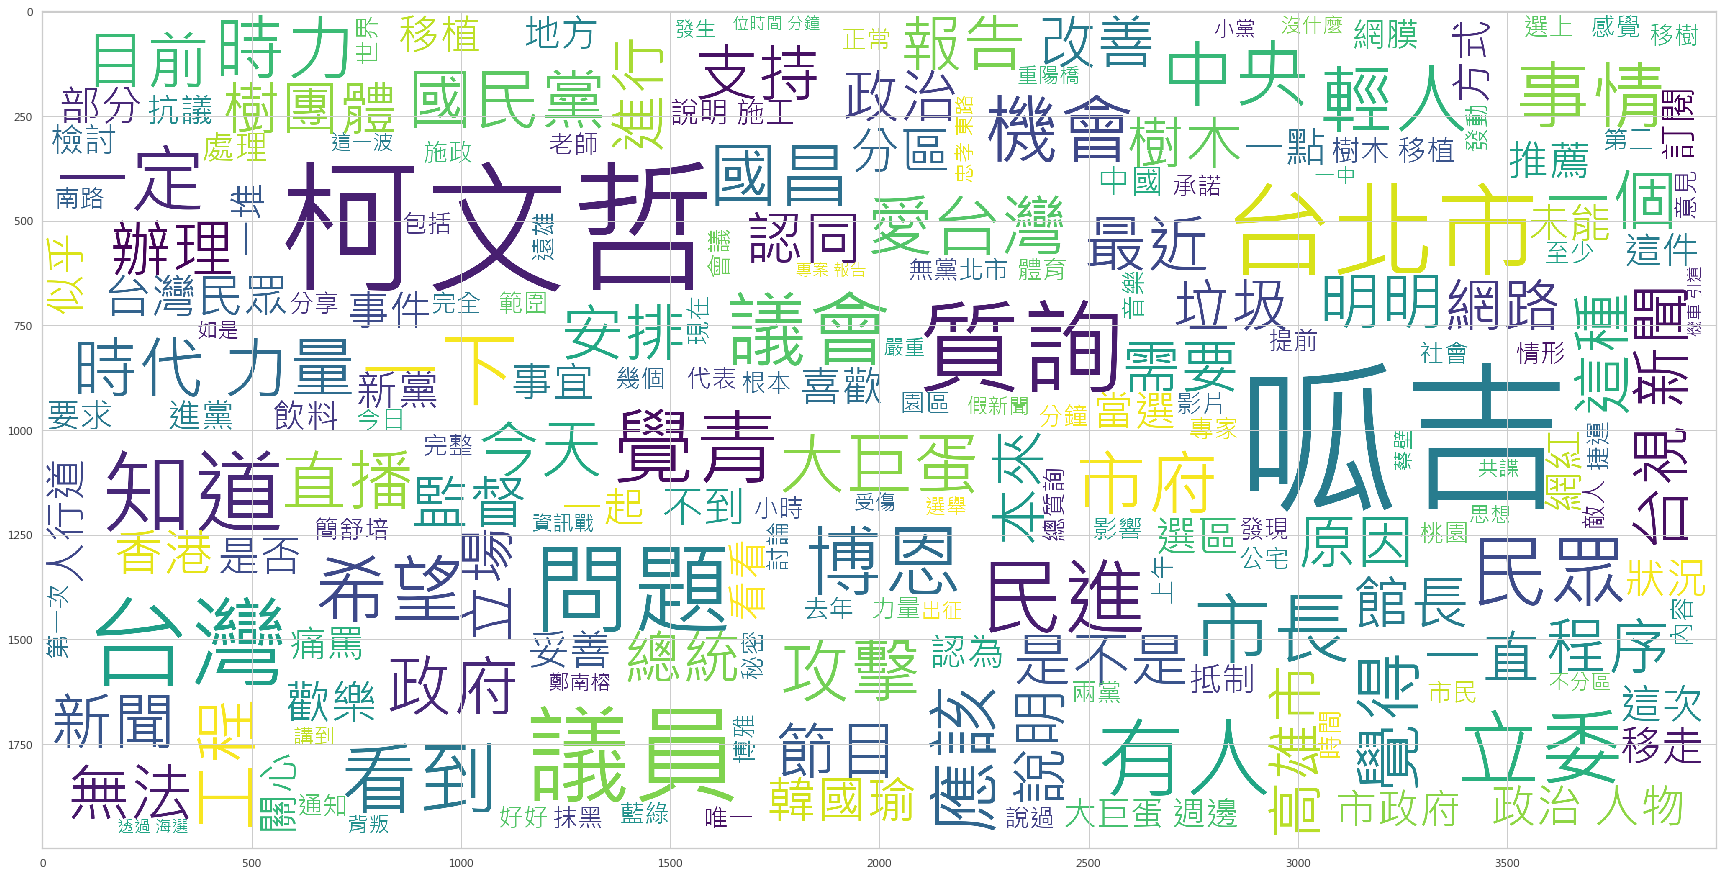

In [799]:
word_c(c1)

#### Cluster2主要幾乎沒有在討論市政有關的事情，幾乎都是直播、影片、大港開唱等等貼文，我們後續也會針對呱吉大港開唱事件作分析

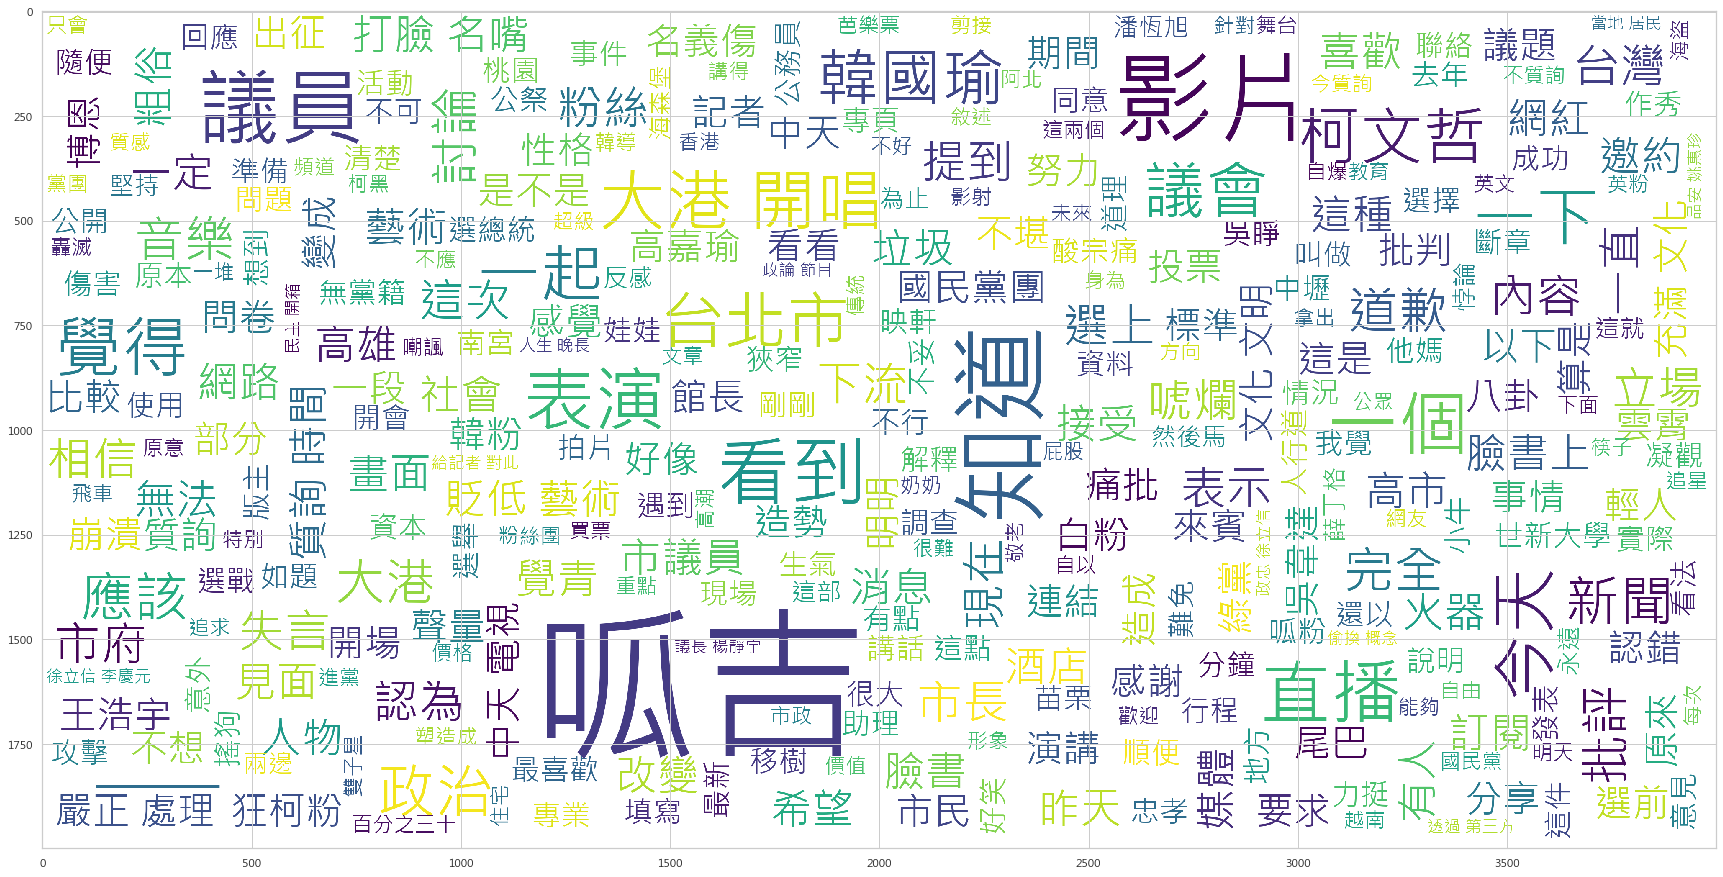

In [801]:
word_c(c2)

#### Cluster3非常明顯與施工、偷渡、包廂這幾個關鍵字有關，很明顯是在說明大巨蛋事件，後續會再追蹤呱吉針對大巨蛋事件的質詢

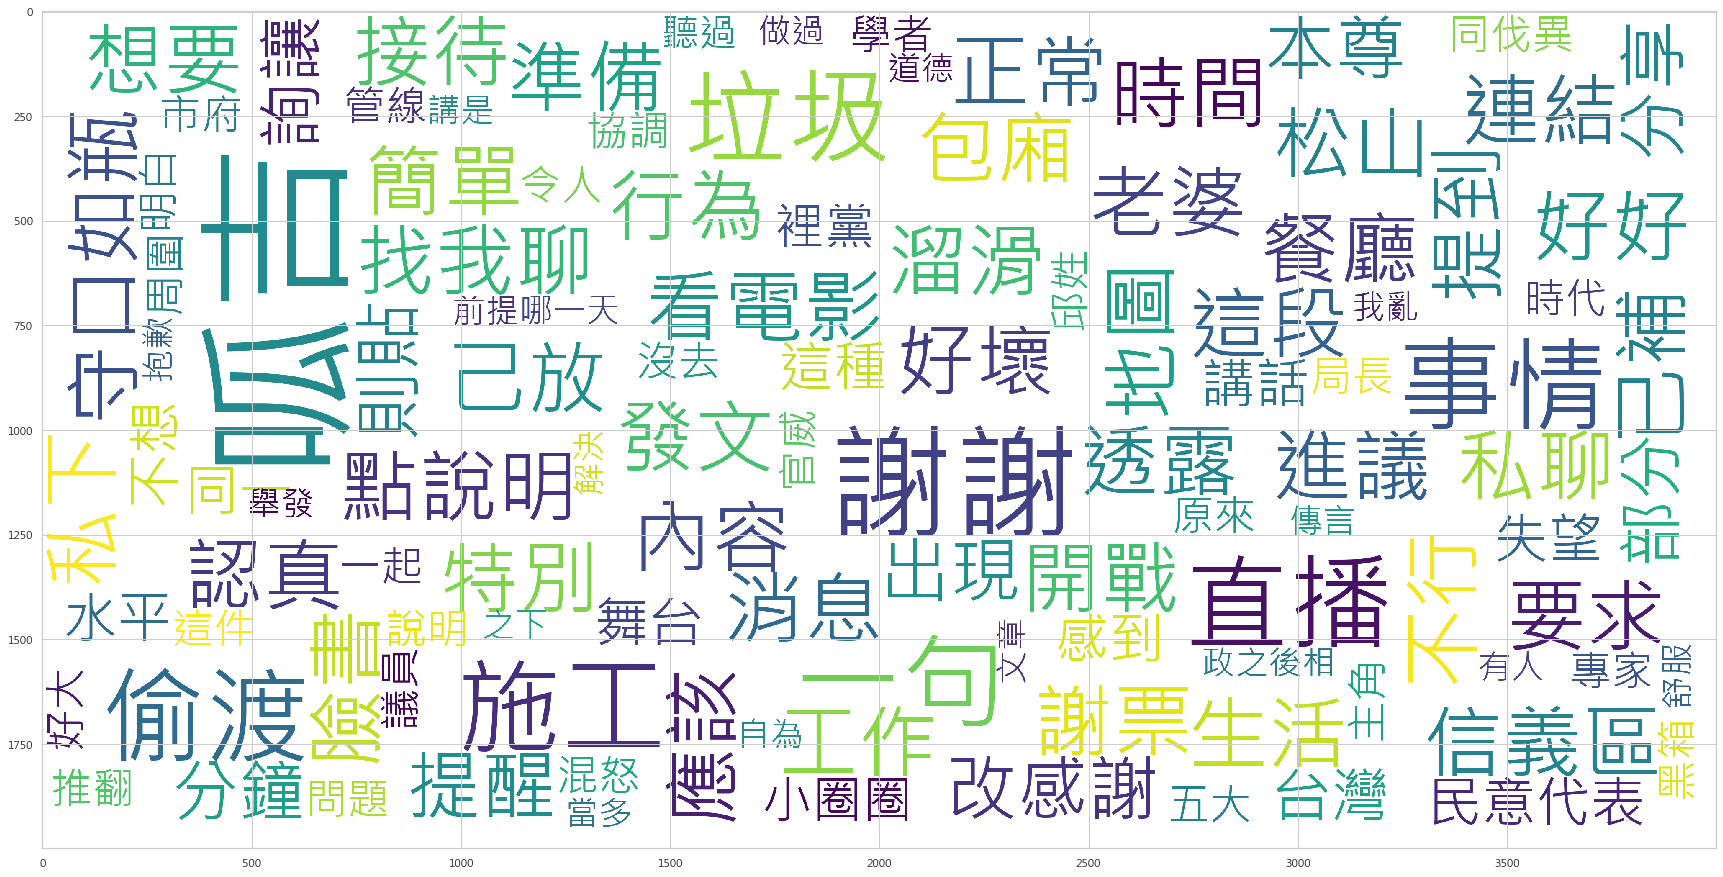

In [793]:
word_c(c3)

#### Cluster4的內容就顯得相對較為雜亂，但還是可以看到一些關鍵詞例如老樹、白粉、松山信義等等，之後會根據這些關鍵詞做後續的追蹤

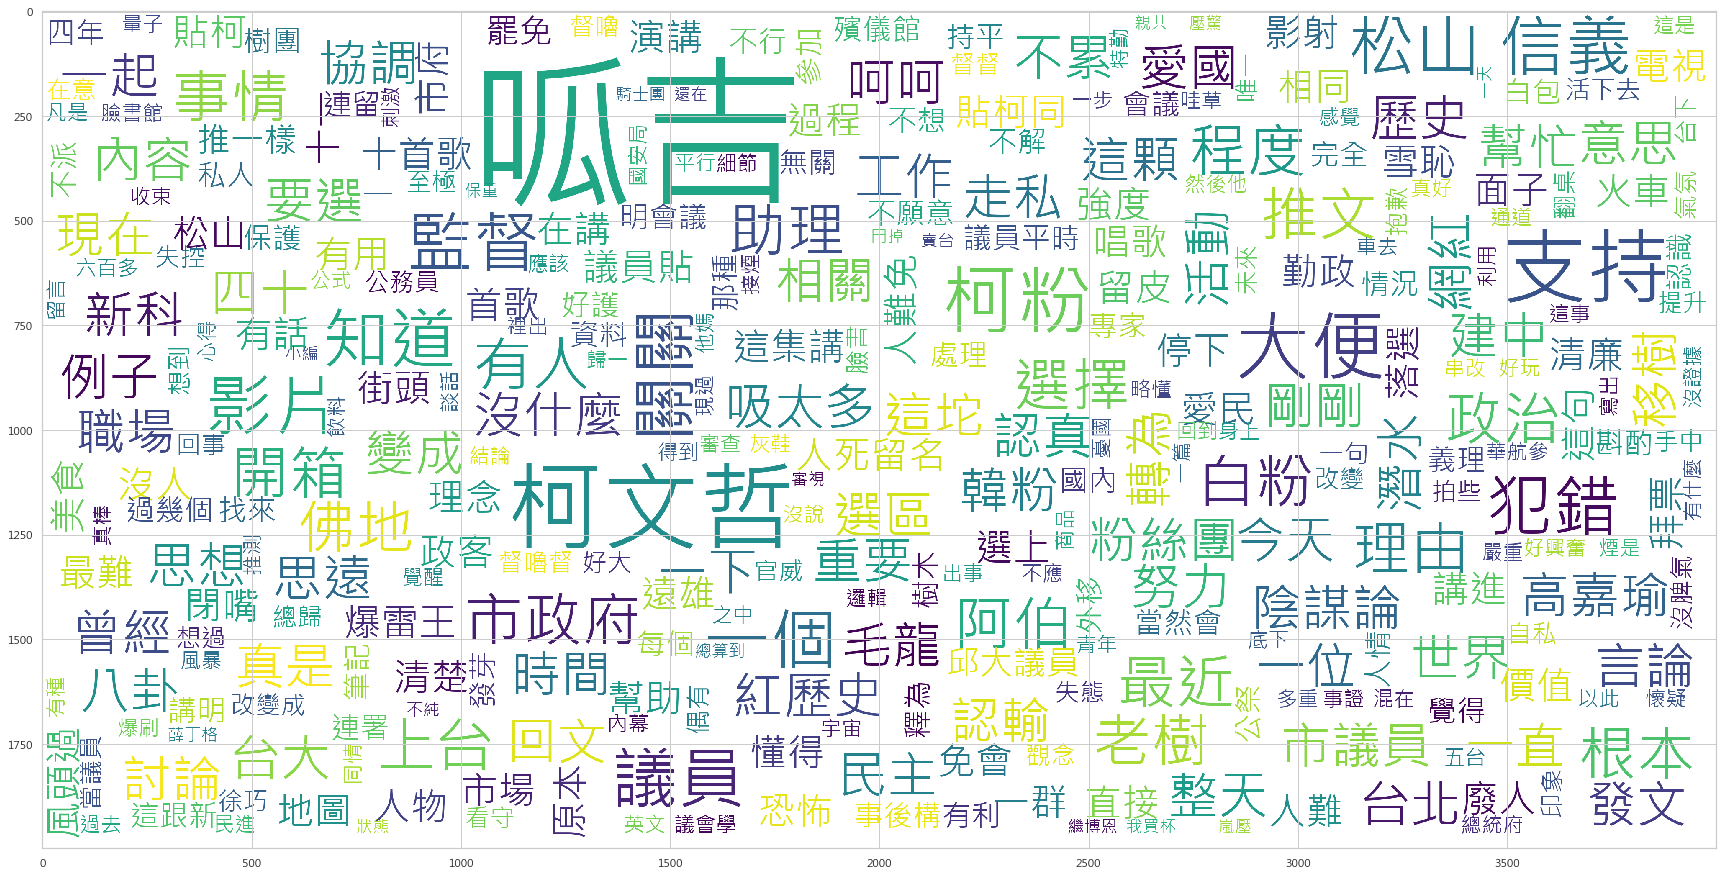

In [794]:
word_c(c4)

#### F. 呱吉事件分析

a. 公共住宅問題<br>
b. 大巨蛋議題<br>
c. 嗆別人吸白粉<br>
d. 大港開唱脫褲子嗆韓市長<br>

呱吉多次登上熱搜版面即因有條理，理性的質詢柯市長，而爆紅，我們就來看看網友們怎麼看

#### a. 公共住宅問題
四月為呱吉首度針對柯市長進行公宅質詢，因此討論度提高，而呱吉也有在每次質詢時持續追蹤此議題，因此討論度有一直延續

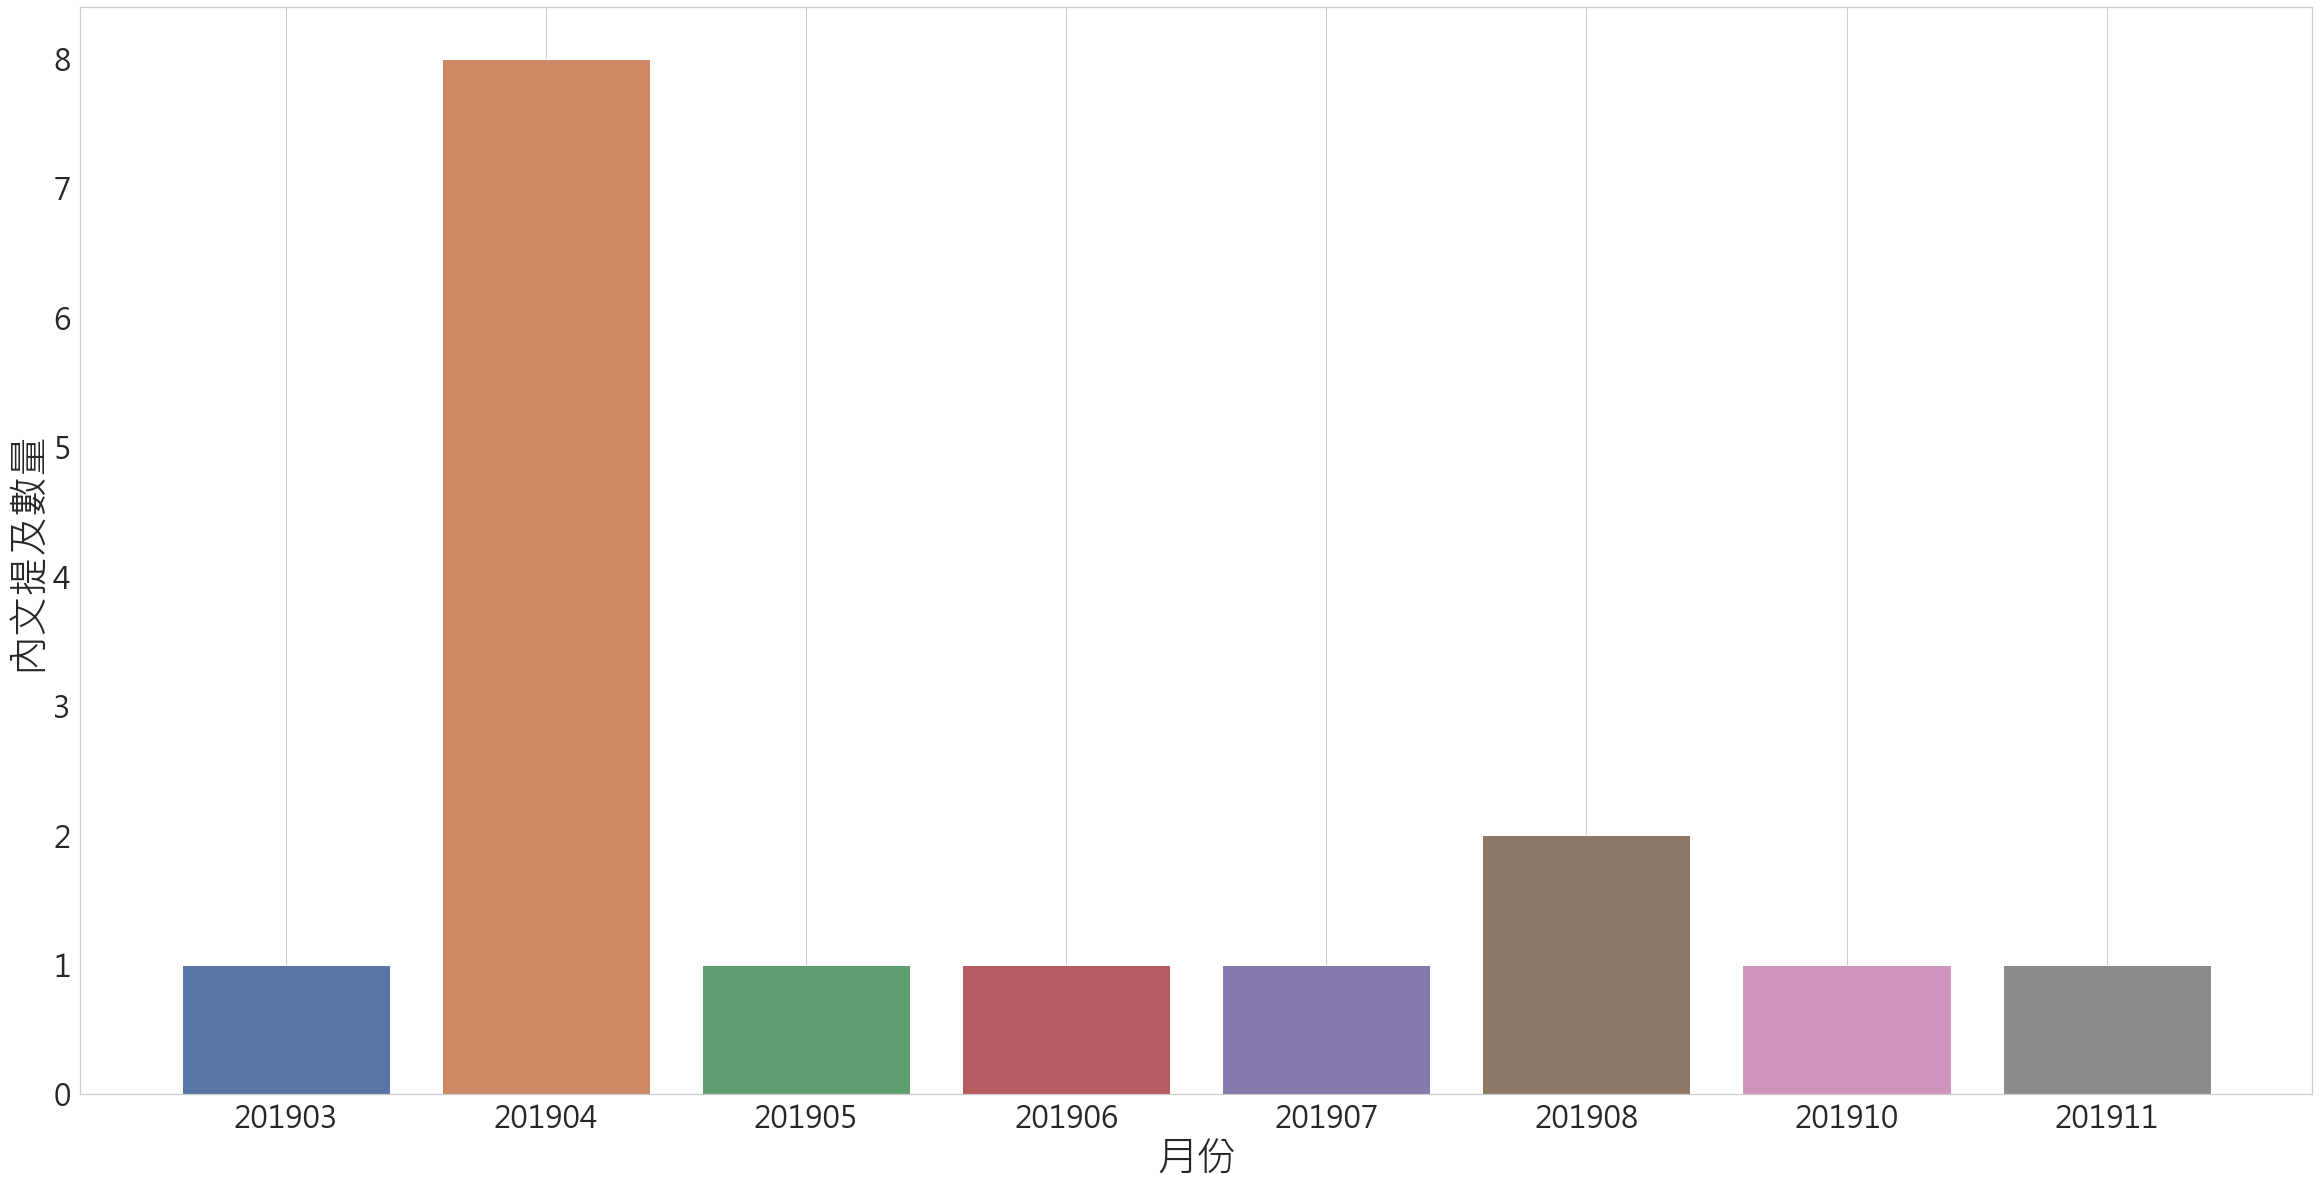

In [80]:
kp_frog_live = df_frog_c[([True  if ('住宅' in i or '公宅' in i or '公共住宅' in i)else False for i in df_frog_c['內文'] ])]
plot = kp_frog_live.groupby(by='YM').count().reset_index()
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=plot, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('內文提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### 我們以留言做正負面統計，使用SnowNLP做情緒分析，判斷是正面情緒的機率，因此這邊以0.4作為閥值，大於閥值則為正面

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(-1.1067212195175775,
 1.1003200580722656,
 -1.1038843585098435,
 1.1065975881968364)

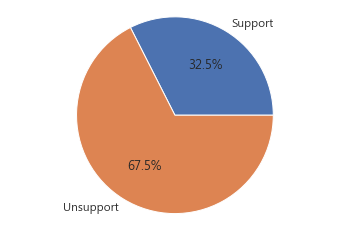

In [113]:
def score(x):
    list_merge = []
    for i in range(len(x)):
        list_ = []
        s = SnowNLP(x[i])
        score = SnowNLP(s.sentences[0]).sentiments
        score = round(score,2)
        list_.append(score)
        list_merge.append(list_)
    return list_merge

kp_frog_live['score'] = kp_frog_live['評論內容'].apply(lambda x : score(x))

score = [z for i in kp_frog_live['score'] for x in i for z in x]
score = ['Support' if i >=0.5 else 'Unsupport' for i in score]
support =sum([1 for i in score if i == 'Support'])
unsupport =sum([1 for i in score if i == 'Unsupport'])
plt.pie([support,unsupport] , labels = ['Support','Unsupport'],autopct='%1.1f%%')
plt.axis('equal')

與新聞報導不太一樣其實是有原因的，新聞報導多報導為理性問政，言之有物，但是其實進一步去查看PTT鄉民或是其他論壇討論，多在批判呱吉不懂的換位思考，作為市長需要考慮的事情很多而不是房租貴就便宜一點，因此有許多網友認為呱吉不夠務實，只是理想化的質詢

#### b. 大巨蛋議題

呱吉於三月開始對大巨蛋的質詢，並且對於搬遷老樹等議題持續關心

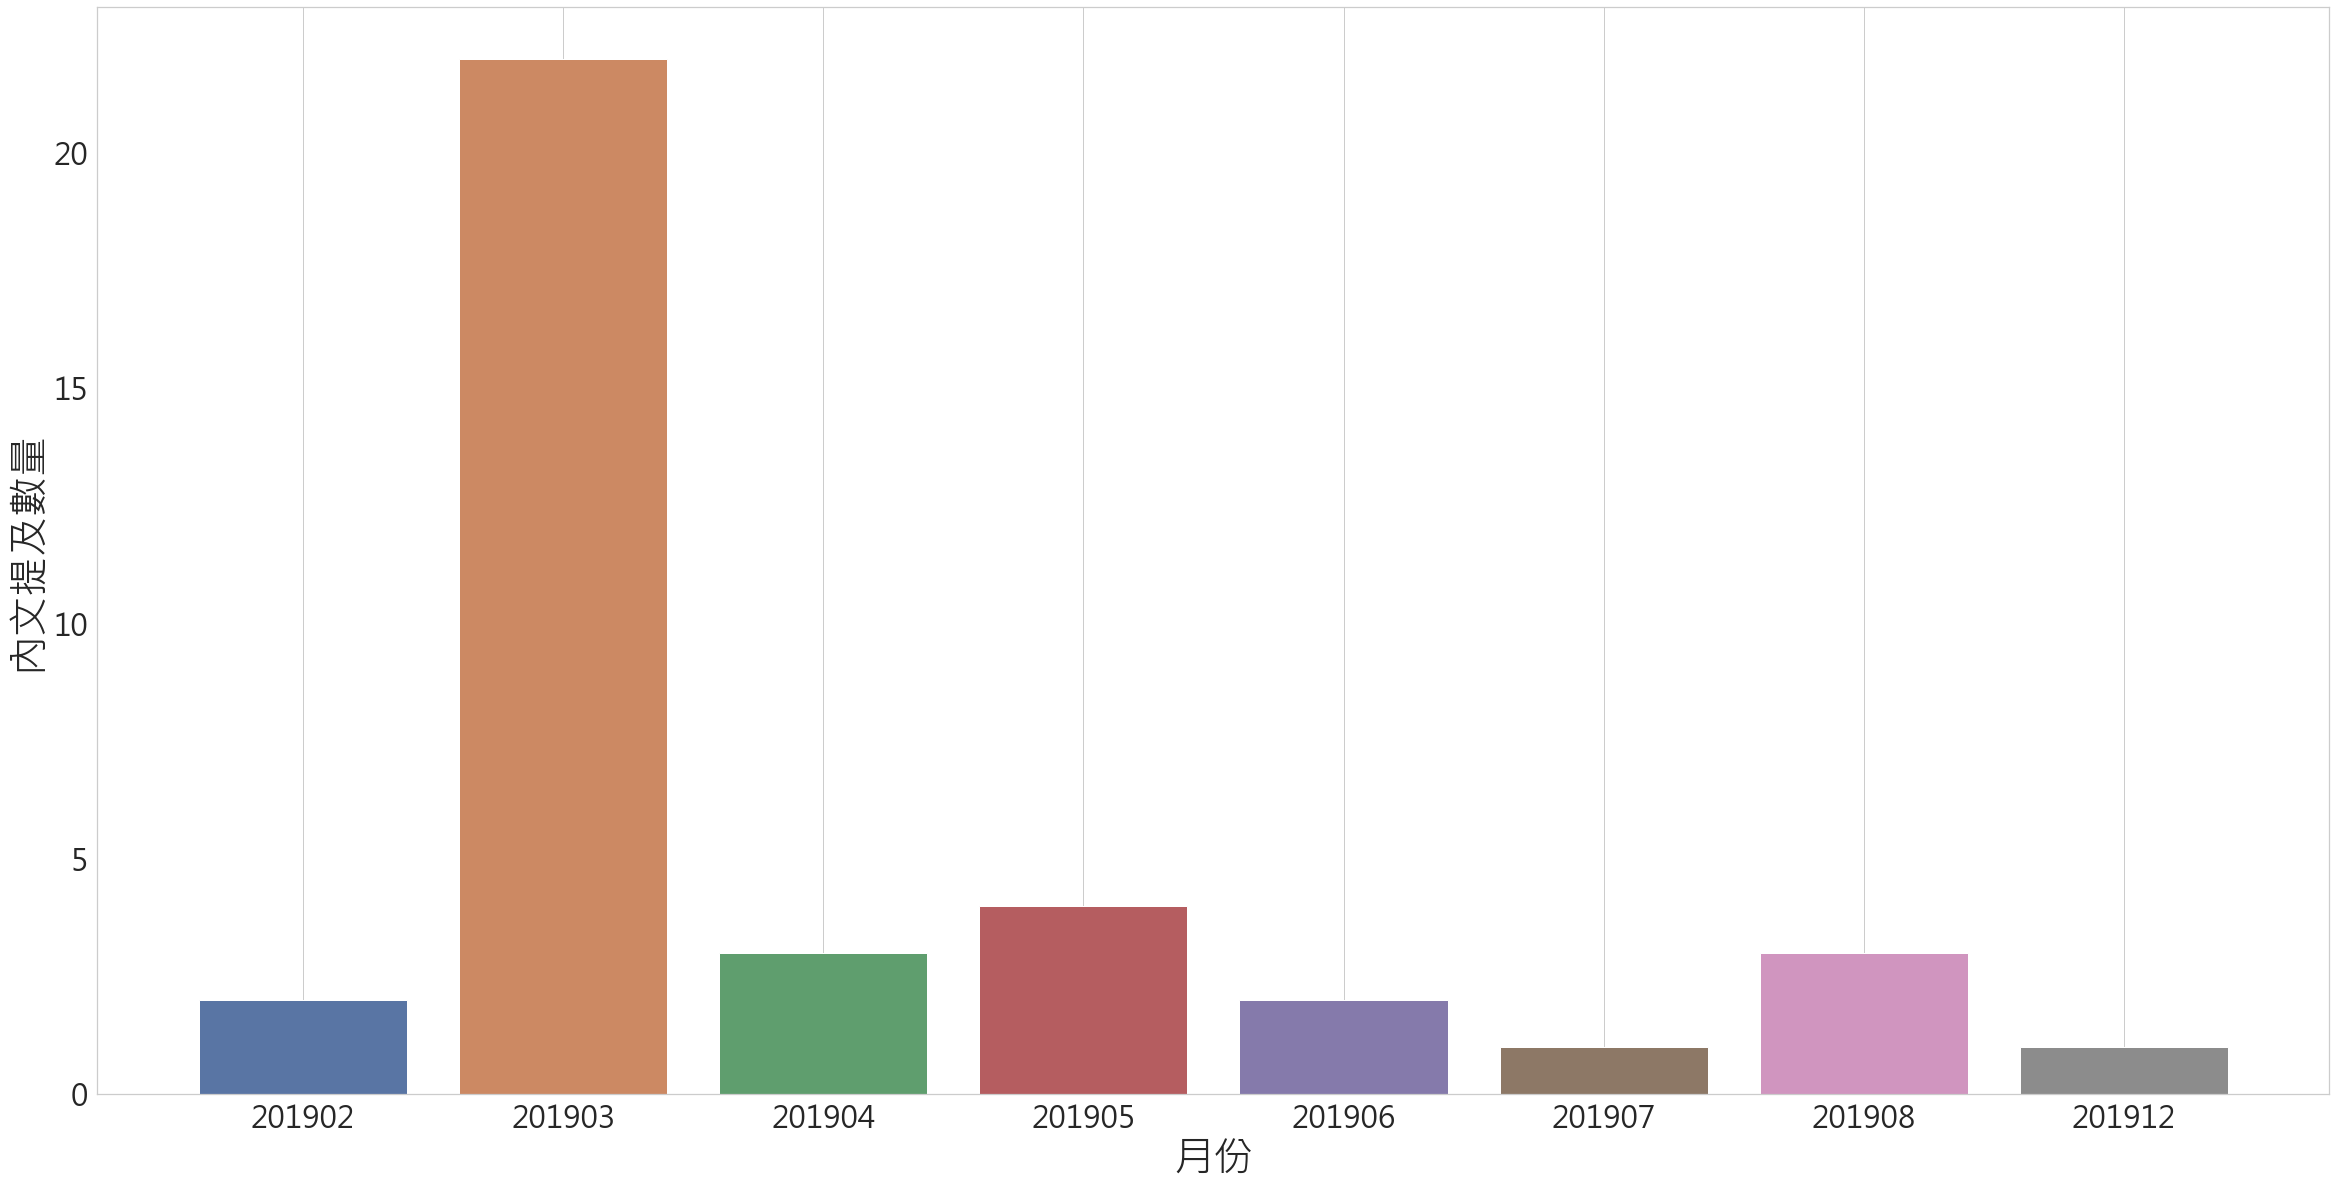

In [82]:
kp_frog_egg = df_frog_c[([True  if ('巨蛋' in i or '老樹' in i) else False for i in df_frog_c['內文'] ])]
plot = kp_frog_egg.groupby(by='YM').count().reset_index()
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=plot, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('內文提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(-1.103063321135552,
 1.1001458724350264,
 -1.1017208990668312,
 1.1031933575215067)

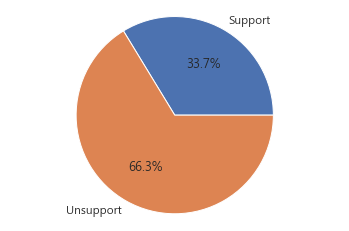

In [112]:
def score(x):
    list_merge = []
    for i in range(len(x)):
        list_ = []
        s = SnowNLP(x[i])
        score = SnowNLP(s.sentences[0]).sentiments
        score = round(score,2)
        list_.append(score)
        list_merge.append(list_)
    return list_merge

kp_frog_egg['score'] = kp_frog_egg['評論內容'].apply(lambda x : score(x))

score = [z for i in kp_frog_egg['score'] for x in i for z in x]
score = ['Support' if i >=0.5 else 'Unsupport' for i in score]
support =sum([1 for i in score if i == 'Support'])
unsupport =sum([1 for i in score if i == 'Unsupport'])
plt.pie([support,unsupport] , labels = ['Support','Unsupport'],autopct='%1.1f%%')
plt.axis('equal')

對於呱吉質詢大巨蛋多數的網友認為這是在炒冷飯，因為過去多位議員已經針對此議題質詢過柯市長，並且在質詢或是老樹遷移時，呱吉皆有因為態度不佳或飆罵基層人員而受到大家的批平，因此大部份的網民依舊對呱吉的質詢不買單

#### c. 嗆別人吸白粉

吸白粉意思為『吸引中間選民』，也指柯文哲等無政黨政治人物的粉絲，事件起因為呱吉被鄉民質疑花很多時間在公祭等等外務，不如柯市長準時上下班，因此回嗆酸民，此事件於三月時爆發開來，後續也不斷的有網民指出呱吉需要為此事件道歉。

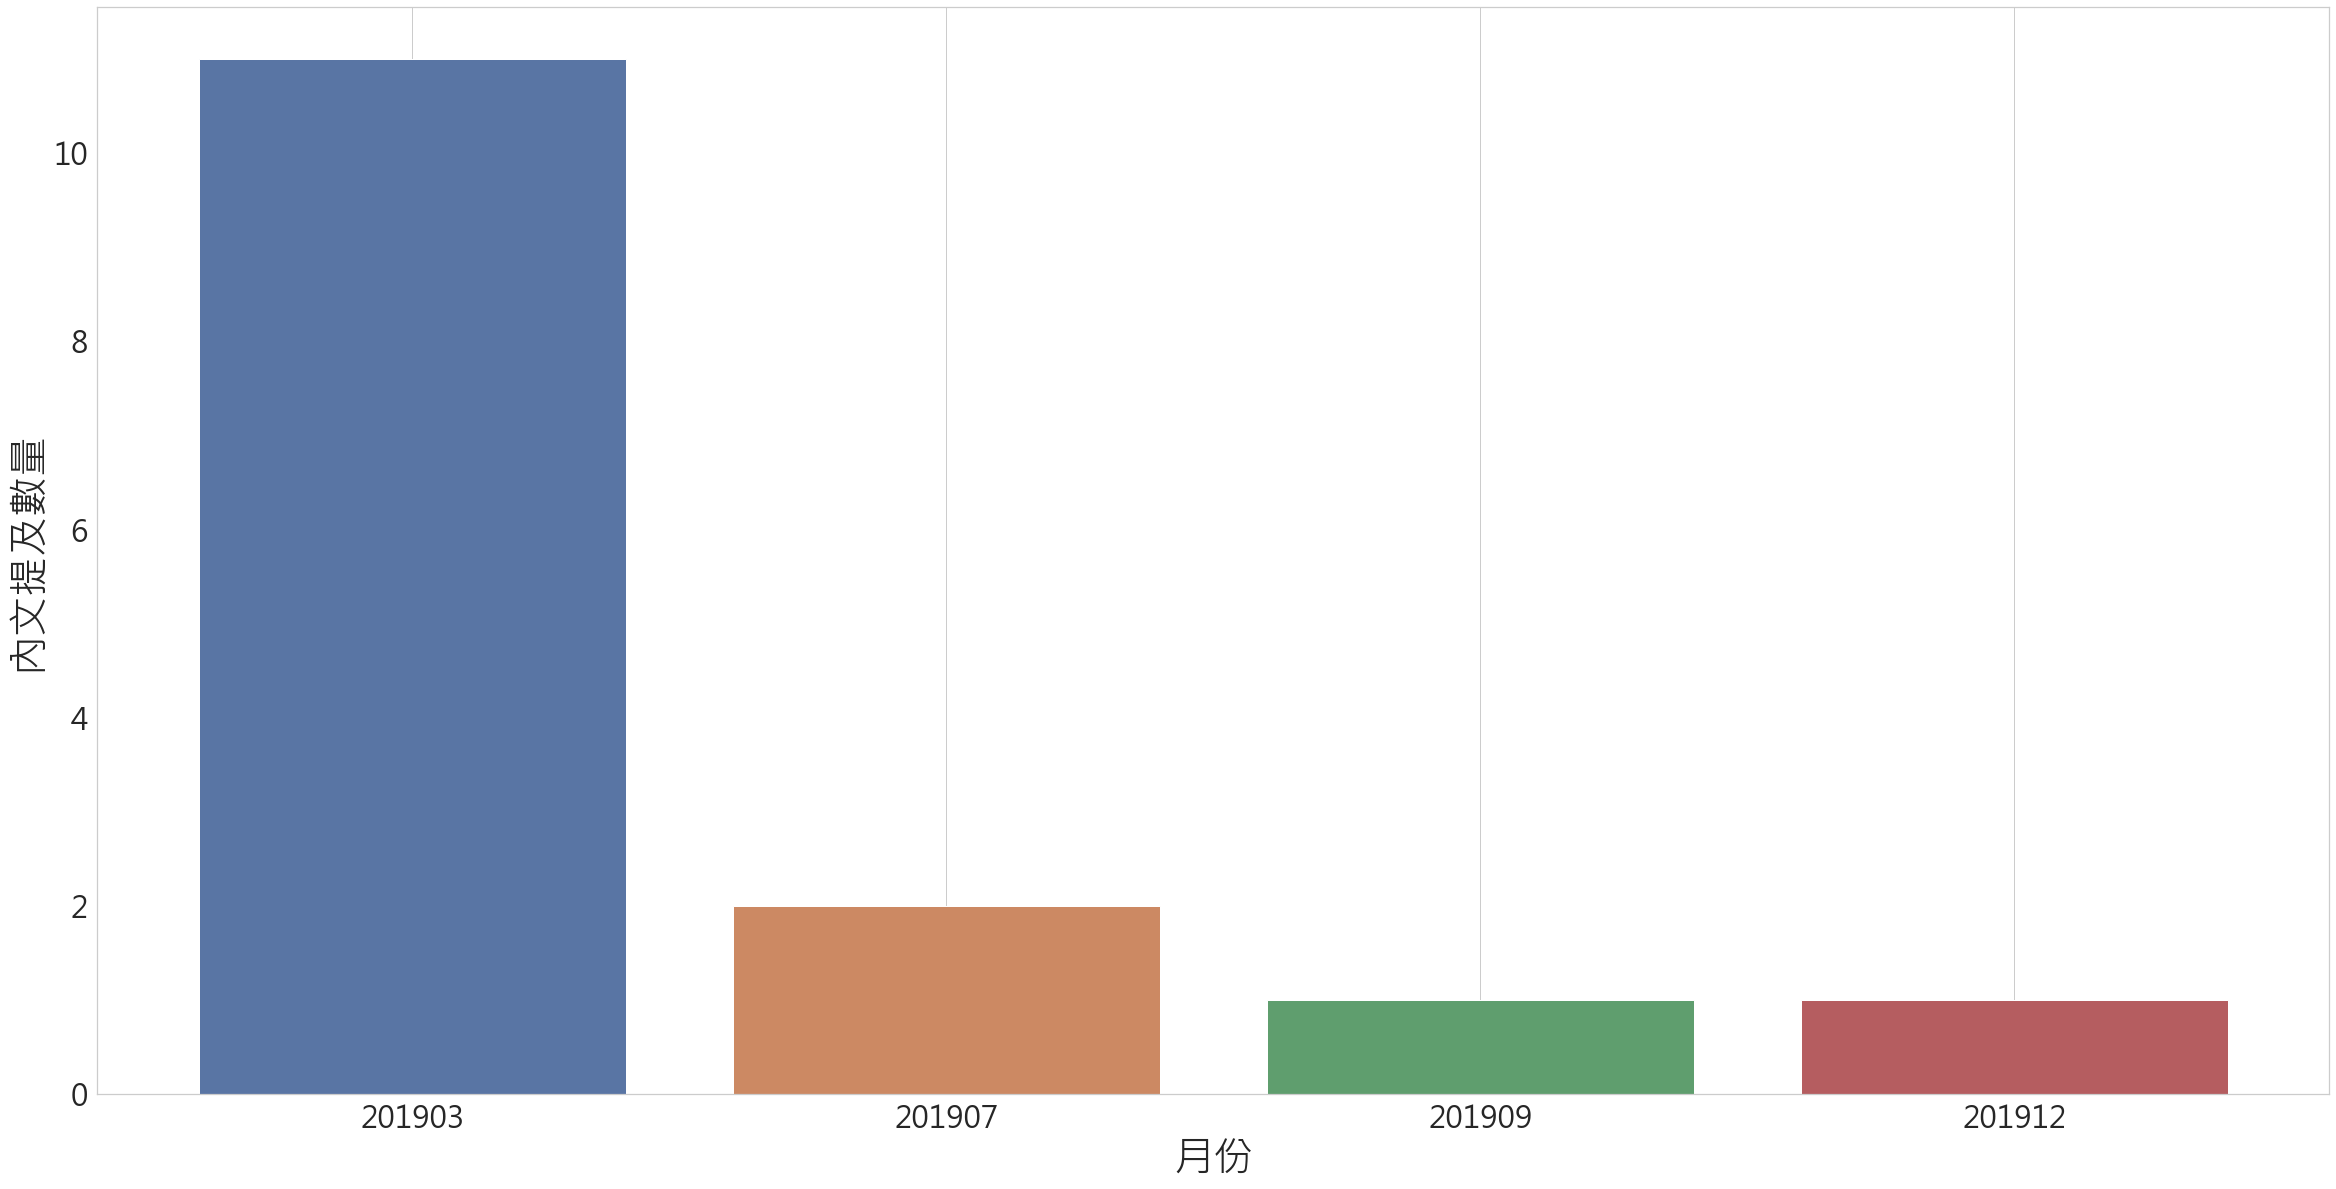

In [121]:
kp_frog_k = df_frog_c[([True  if ('白粉' in i) else False for i in df_frog_c['內文'] ])]
plot = kp_frog_k.groupby(by='YM').count().reset_index()
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=plot, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('內文提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(-1.107588587078522, 1.100361385195607, -1.107874279149343, 1.1034629622086871)

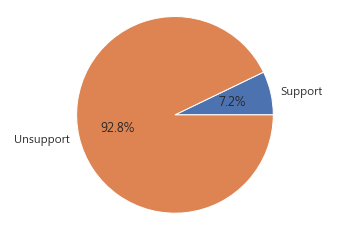

In [120]:
def score(x):
    list_merge = []
    for i in range(len(x)):
        list_ = []
        s = SnowNLP(x[i])
        score = SnowNLP(s.sentences[0]).sentiments
        score = round(score,2)
        list_.append(score)
        list_merge.append(list_)
    return list_merge

kp_frog_k['score'] = kp_frog_k['評論內容'].apply(lambda x : score(x))

score = [z for i in kp_frog_k['score'] for x in i for z in x]
score = ['Support' if i >=0.5 else 'Unsupport' for i in score]
support =sum([1 for i in score if i == 'Support'])
unsupport =sum([1 for i in score if i == 'Unsupport'])
plt.pie([support,unsupport] , labels = ['Support','Unsupport'],autopct='%1.1f%%')
plt.axis('equal')

可以看到超過90%的網民都不支持此事件，且後續只要提到呱吉，許多網民就會在底下留言呼籲呱吉需要為白粉事件道歉

#### d. 大港開唱事件

此事件於九月爆發開來，由於脫褲子、嗆韓國瑜等等拖續行為對年輕人來說，根本不是什麼大事情，也有許多網民認為只是韓國瑜團隊在大做文章(p.s. 也有可能是大家討厭韓國瑜的程度遠大於呱吉)

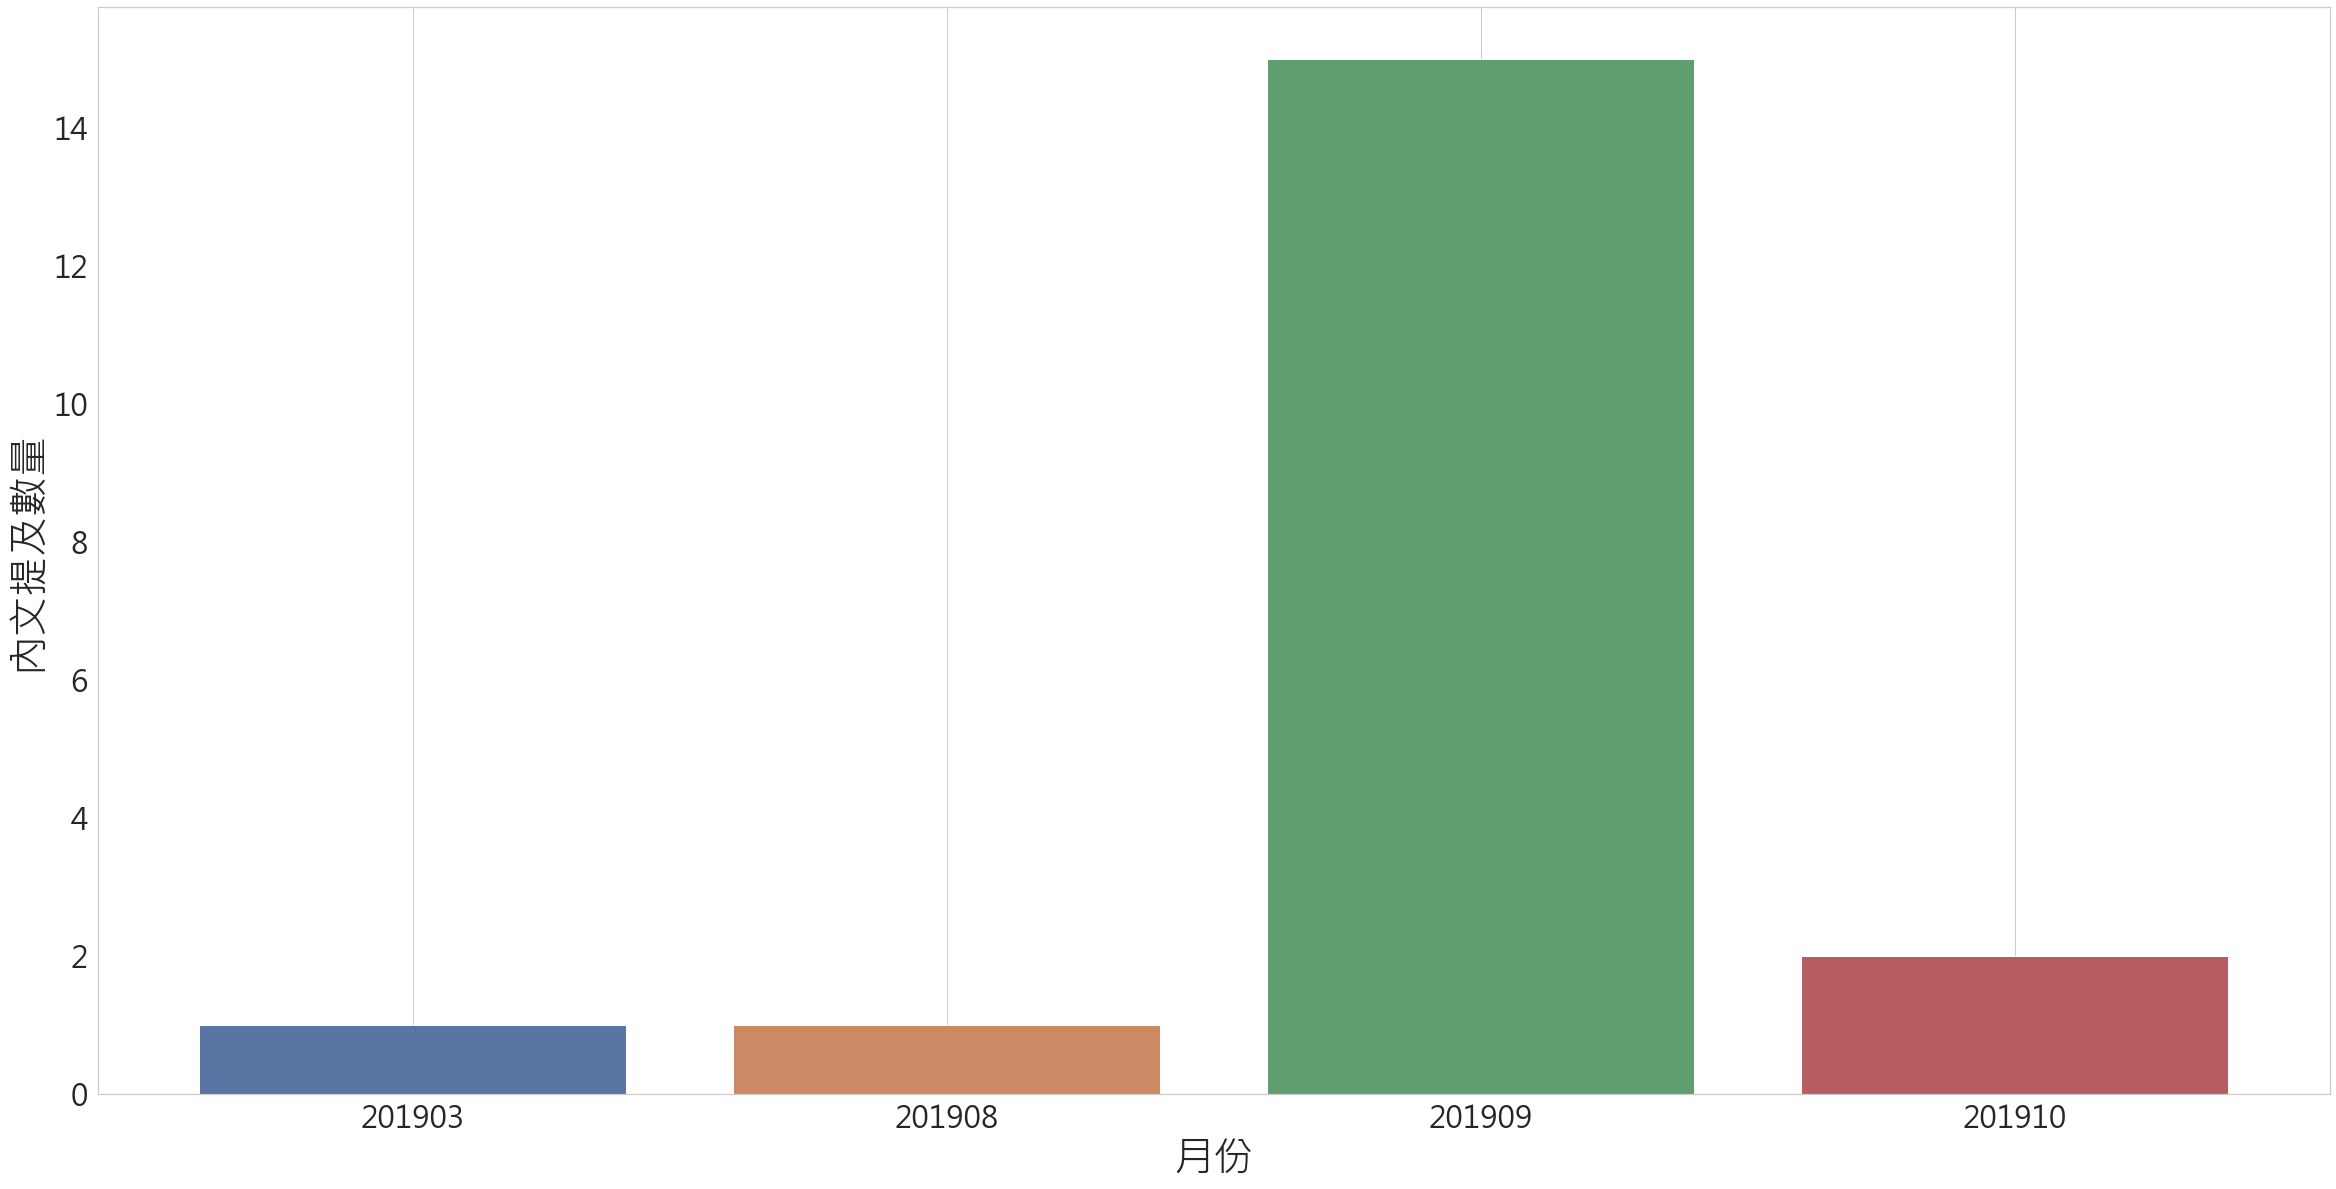

In [123]:
kp_frog_d = df_frog_c[([True  if ('大港' in i or '開唱' in i or '脫褲子' in i) else False for i in df_frog_c['內文'] ])]
plot = kp_frog_d.groupby(by='YM').count().reset_index()
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="YM", y="Y", data=plot, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('內文提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(-1.1043087827749938,
 1.1002051801321426,
 -1.1054360594232362,
 1.1027897054483495)

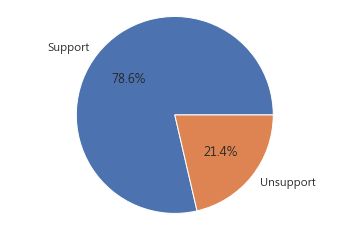

In [128]:
def score(x):
    list_merge = []
    for i in range(len(x)):
        list_ = []
        s = SnowNLP(x[i])
        score = SnowNLP(s.sentences[0]).sentiments
        score = round(score,2)
        list_.append(score)
        list_merge.append(list_)
    return list_merge

kp_frog_d['score'] = kp_frog_d['評論內容'].apply(lambda x : score(x))

score = [z for i in kp_frog_d['score'] for x in i for z in x]
score = ['Support' if i >=0.5 else 'Unsupport' for i in score]
support =sum([1 for i in score if i == 'Support'])
unsupport =sum([1 for i in score if i == 'Unsupport'])
plt.pie([support,unsupport] , labels = ['Support','Unsupport'],autopct='%1.1f%%')
plt.axis('equal')

可以看到此事件多數網民認為呱吉於大港開唱事件並非正式場合，且對於台下觀眾的反應也沒有不悅，因此認為次事件為呱吉被惡意抹黑及造謠

#### 小結論：可以看出其實PTT網民對於呱吉的質詢狀況不是特別的滿意，有一大部分原因為認為呱吉的質詢不切實際，隨然是理性問政，但是在內容上扔然難以得到網民的認同，且有部分原因為呱吉是上班不要看的老闆，部分網民認為他有慣老闆的架子，並且沒有換位思考站在市長的角度看事情

### Youtube

A. 預處理<br>
B. Overview<br>
C. 情緒分析<br>
D. 文字雲<br>

我們在Youtube挑選呱吉問政留言超過200則的影片

#### A. 預處理

In [233]:
youtube = pd.read_csv('youtube.csv')
youtube['like'] = youtube['like'].apply(lambda x : int(x.replace('萬','0000').replace('.','')))
df = pd.read_table('parent_video_comment.csv',encoding='utf-8',sep=',')
z=[]
for i in range(len(df)):
    try:
        z.append(df['publishedAt'][i].split('-')[1])
    except:
        z.append('no')
df['month'] = z
df = df.dropna()
df = df.reset_index(drop=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### B. Overview

#### 每個影片的倒讚比例

可以看到倒讚的比例幾乎為最高也只有6%，可見呱吉在Youtube上的評價非常高

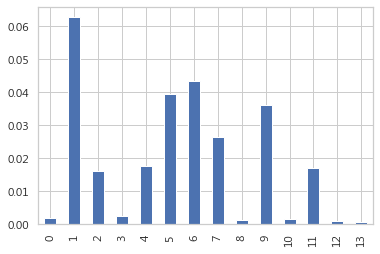

In [165]:
x = youtube[['name','like','unlike']]
(x['unlike']/x['like']).plot(kind='bar', stacked=True)

#### 每個時間的留言數

會呈現這樣的分佈主因是問政幾乎都集中在4,5,6月因此我們抓的影片也多集中在這三個月

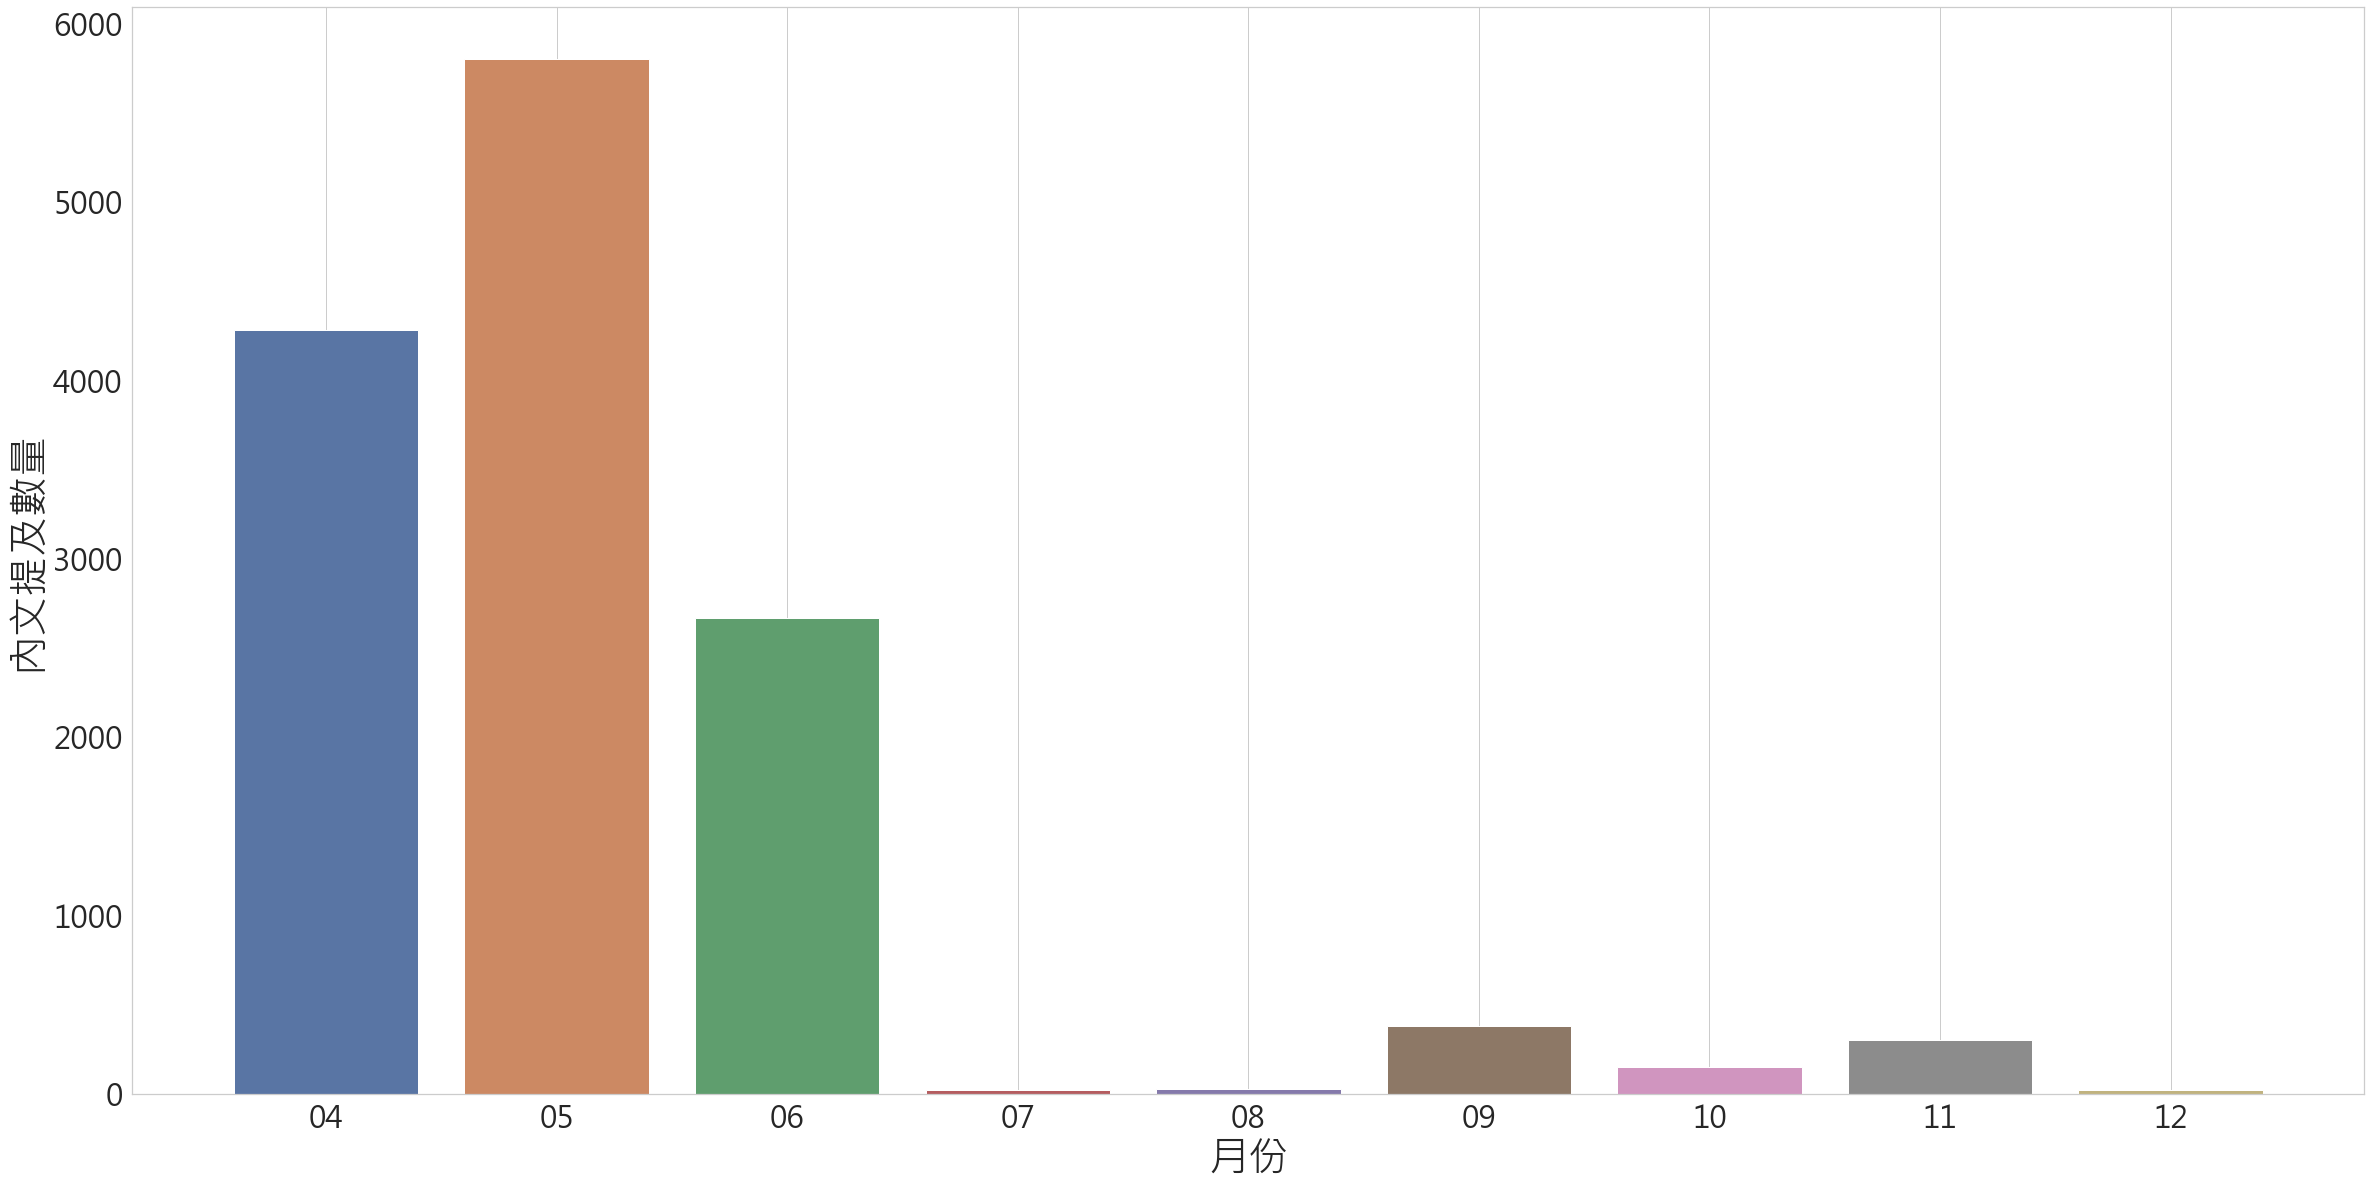

In [234]:
plot = df.groupby(by='month').count().reset_index()
plt.figure(figsize=(40, 20))
ax = sns.barplot(x="month", y="comment", data=plot, estimator=sum)
label = ax.get_xticklabels()
plt.ylabel('內文提及數量',fontsize=40)
plt.xlabel('月份',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
_ = plt.plot()

#### C. 情緒分析

由於留言都是對呱吉的問政做留言因此我們不做文字分群，直接做情緒分析

可以看到支持的留言佔了很大的百分比，推測原因在於許多支持留言讚的是呱吉的問政態度，與內容無絕對的關聯

(-1.1168811762315536,
 1.1008038929891277,
 -1.110425115892048,
 1.119322104527822)

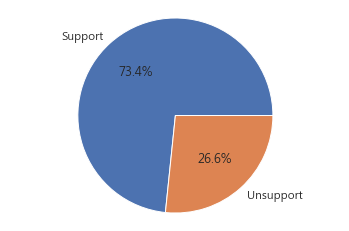

In [242]:
def score(x):
    s = SnowNLP(x)
    score = SnowNLP(s.sentences[0]).sentiments
    score = round(score,2)
    return score
df['score'] = df['comment'].apply(lambda x: score(x))
score = ['Support' if i >=0.1 else 'Unsupport' for i in list(df['score'])]
support =sum([1 for i in score if i == 'Support'])
unsupport =sum([1 for i in score if i == 'Unsupport'])
plt.pie([support,unsupport] , labels = ['Support','Unsupport'],autopct='%1.1f%%')
plt.axis('equal')

#### D. 文字雲呈現

可以看到各種正面評語都出現在了文字雲中，"專業"、"清楚"、"正常"、"理性"、"水準"，都代表著對呱吉問政表現的稱讚

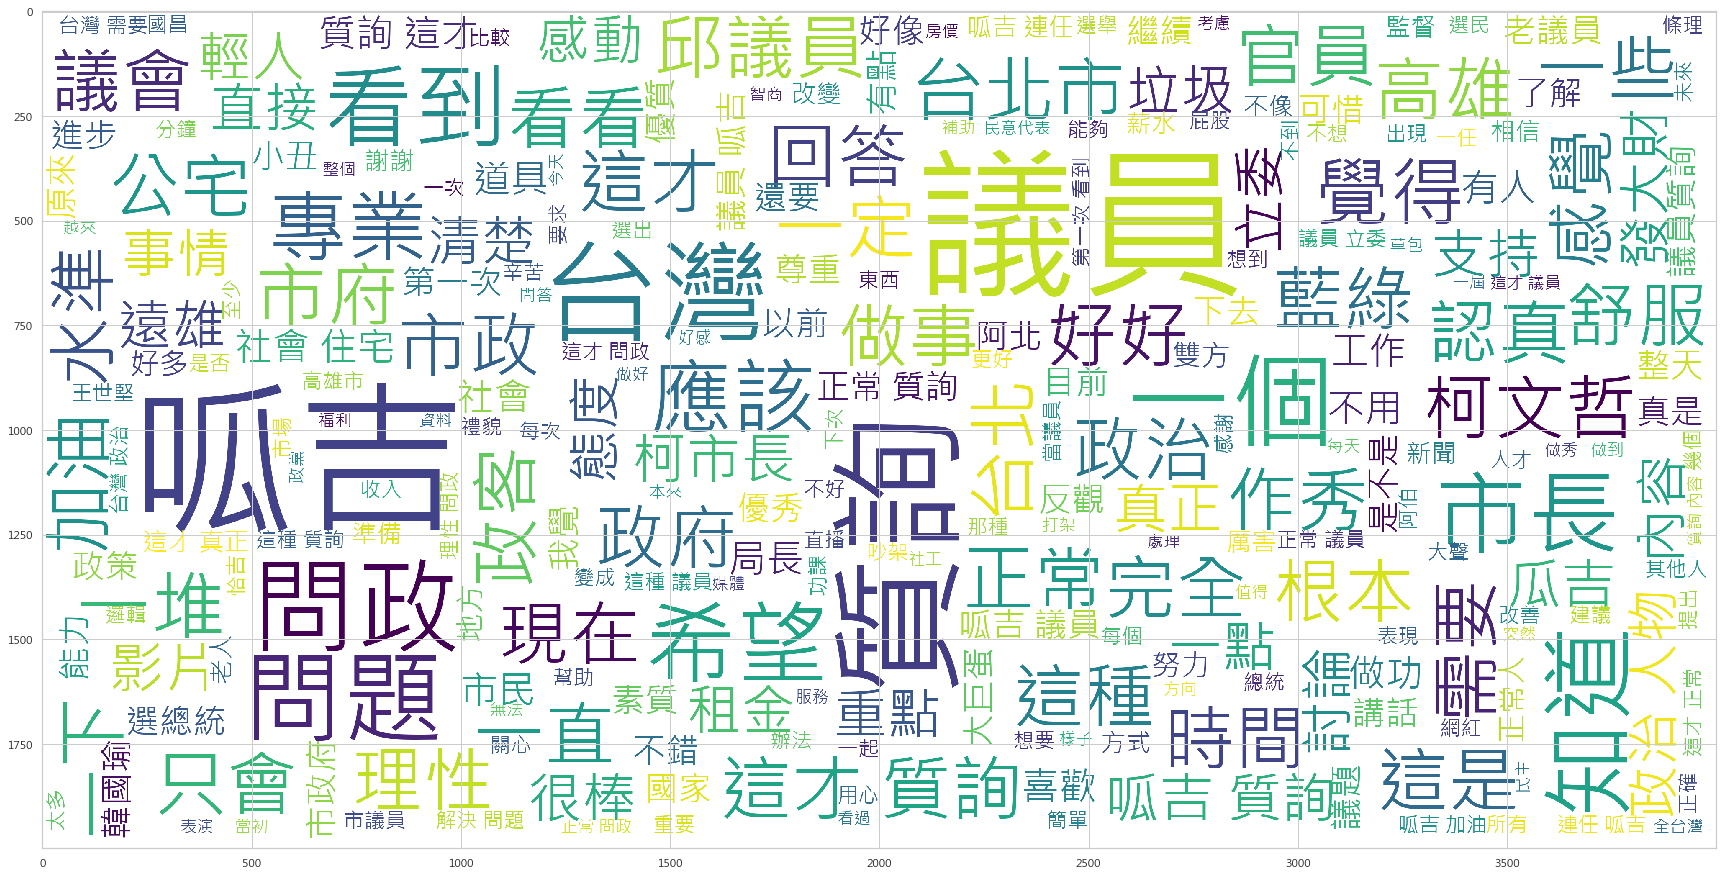

In [248]:
word_c(''.join(list(df['comment'])))

### 4.結論

1.政治獻金分析，以政治獻金的觀點來看，我們可以知道呱吉是一個有想法的議員，認真想要為了市政做改變，為整個選舉制度做改變，也成功地在政治獻金上面做到了跟以前不一樣的理念，並且鼓勵同樣想要改變的年輕人站出來，這點呱吉做得非常好。<br>
<br>
2.粉絲人數推估，以訂閱數以及人口數來做推估，可以發現其實呱吉的得票來自粉絲的比例其實不算高，因此可以把功勞歸給在選前呱吉在地方所做的努力，例如肥皂箱會議等等。<br>
<br>
3.PTT留言分析，我們對PTT的留言分析過後，其實是發生了意想不到的結果，因為之前我也被主流或網路媒體所報導的呱吉問政有條理所誤以為呱吉的問政內容是有力的，但是經過分析後才發現其實多數在PTT做出評論的留言，他們看完呱吉的質詢內容之後反而不以為然，因此我認為這是呱吉需要去加強的，有條有理的問政已經比多數的議員好太多，但是要做得更好必須讓內容更有建設性，並且我們也發現了在質詢內容中或是內文中完全沒有提到呱吉所提倡的七大政見，有部分原因有可能是因為這些事情是不需要拿來質詢市長的，但也有部分原因是呱吉多數時間拿來監督大巨蛋或是公共住宅，這部分如果是為了人民福祉則是可以被諒解的，但是還是認為呱吉必須謹守當初的承諾對政見負責。<br>
<br>
4.Youtube留言分析，這點即為上述所提到的問政內容，到底留言者有多少對內容思考過，因為多數的留言並不是指出呱吉提出的問題犀利、一針見血、指出通點等等，而是說有條有理、認真質詢，是否我們大部分的人都被這樣的外表而屏蔽了對內容辨別的能力，是我們都需要去思考的，問政態度固然重要，但是其實最重要的還是有解決問題。